In [1]:
!pip install flair

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import os, re, csv, string, random
import flair
# print(flair.__version__)


import nltk
from nltk.tokenize import RegexpTokenizer

from flair.data import Sentence, Span, Corpus, Dictionary, Token
from flair.embeddings import WordEmbeddings, DocumentPoolEmbeddings, FlairEmbeddings, StackedEmbeddings, TokenEmbeddings
from flair.models import SequenceTagger

from flair.datasets import ColumnCorpus
from flair.trainers import ModelTrainer

from typing import List, Tuple

from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
import pickle

from tqdm.auto import tqdm, trange

# import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
# from flair.data import Sentence

In [3]:
from google.colab import drive
drive.mount("/content/drive")

os.chdir('/content/drive/MyDrive/SI 630 project')
# os.listdir('.')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
os.listdir('datasets/CADEC/CADEC.v2/cadec')


['sct',
 'text',
 'original - unedited version of edited files',
 'meddra - unedited version of edited files',
 'sct - unedited version of edited files',
 'original',
 'meddra']

In [5]:
suf = '_v2'

data_save_dir = 'data'+suf

suf += '_Bio_ClinicalBERT'

In [6]:
meddra_counts = pd.read_csv(data_save_dir+'/meddra_counts.csv')
meddra_counts

,ner,meddra,counts_exploded,counts,counts_exploded_rank
0,Drug,Lipitor,1081,1073,1
1,ADR,CONCEPT_LESS,1016,266,2
2,ADR,Severe_pain,722,247,3
3,ADR,Myalgia,619,305,4
4,ADR,Pain,292,260,5
...,...,...,...,...,...
1294,Finding,Senility,1,1,1233
1295,Drug,Seroquel,1,1,1233
1296,Drug,Solaraze,1,1,1233
1297,Drug,Tagamet,1,1,1233


In [7]:
meddra_counts.loc[meddra_counts.ner == 'ADR',:]

,ner,meddra,counts_exploded,counts,counts_exploded_rank
1,ADR,CONCEPT_LESS,1016,266,2
2,ADR,Severe_pain,722,247,3
3,ADR,Myalgia,619,305,4
4,ADR,Pain,292,260,5
5,ADR,Arthralgia,280,163,6
...,...,...,...,...,...
1268,ADR,Labyrinthitis,1,1,1233
1269,ADR,Dysphagia,1,1,1233
1275,ADR,Lupus_erythematosus,1,1,1233
1278,ADR,Cataract,1,1,1233


In [8]:
with open(data_save_dir+'/cadec_flair_objects.pkl', 'rb') as f:
    docs = pickle.load(f)
docs[:10]

[Sentence[117]: "i feel a bit drowsy & have a little blurred vision , so far no gastric problems . ive been on arthrotec 50 for over 10 years on and off , only taking it when i needed it . due to my arthritis getting progressively worse , to the point where i am in tears with the agony , gp ' s started me on 75 twice a day and i have to take it . every day for the next month to see how i get on , here goes . so far its been very good , pains almost gone , but i feel a bit weird , didnt have that when on 50 ." → ["i"/O/O, "feel"/O/O, "a"/O/O, "bit"/B-ADR/B-Drowsy, "drowsy"/E-ADR/E-Drowsy, "&"/O/O, "have"/O/O, "a"/O/O, "little"/B-ADR/B-Blurred_vision_-_hazy, "blurred"/I-ADR/I-Blurred_vision_-_hazy, "vision"/E-ADR/E-Blurred_vision_-_hazy, ","/O/O, "so"/O/O, "far"/O/O, "no"/O/O, "gastric"/B-ADR/B-Excessive_upper_gastrointestinal_gas, "problems"/E-ADR/E-Excessive_upper_gastrointestinal_gas, "."/O/O, "ive"/O/O, "been"/O/O, "on"/O/O, "arthrotec"/S-Drug/S-Arthrotec, "50"/O/O, "for"/O/O, "over"

In [9]:
len(docs)

1186

In [10]:
temp = docs[0]
temp

Sentence[117]: "i feel a bit drowsy & have a little blurred vision , so far no gastric problems . ive been on arthrotec 50 for over 10 years on and off , only taking it when i needed it . due to my arthritis getting progressively worse , to the point where i am in tears with the agony , gp ' s started me on 75 twice a day and i have to take it . every day for the next month to see how i get on , here goes . so far its been very good , pains almost gone , but i feel a bit weird , didnt have that when on 50 ." → ["i"/O/O, "feel"/O/O, "a"/O/O, "bit"/B-ADR/B-Drowsy, "drowsy"/E-ADR/E-Drowsy, "&"/O/O, "have"/O/O, "a"/O/O, "little"/B-ADR/B-Blurred_vision_-_hazy, "blurred"/I-ADR/I-Blurred_vision_-_hazy, "vision"/E-ADR/E-Blurred_vision_-_hazy, ","/O/O, "so"/O/O, "far"/O/O, "no"/O/O, "gastric"/B-ADR/B-Excessive_upper_gastrointestinal_gas, "problems"/E-ADR/E-Excessive_upper_gastrointestinal_gas, "."/O/O, "ive"/O/O, "been"/O/O, "on"/O/O, "arthrotec"/S-Drug/S-Arthrotec, "50"/O/O, "for"/O/O, "over"/

In [11]:
temp.annotation_layers

{'ner': ['Token[0]: "i"'/'O' (1.0),
  'Token[1]: "feel"'/'O' (1.0),
  'Token[2]: "a"'/'O' (1.0),
  'Token[3]: "bit"'/'B-ADR' (1.0),
  'Token[4]: "drowsy"'/'E-ADR' (1.0),
  'Token[5]: "&"'/'O' (1.0),
  'Token[6]: "have"'/'O' (1.0),
  'Token[7]: "a"'/'O' (1.0),
  'Token[8]: "little"'/'B-ADR' (1.0),
  'Token[9]: "blurred"'/'I-ADR' (1.0),
  'Token[10]: "vision"'/'E-ADR' (1.0),
  'Token[11]: ","'/'O' (1.0),
  'Token[12]: "so"'/'O' (1.0),
  'Token[13]: "far"'/'O' (1.0),
  'Token[14]: "no"'/'O' (1.0),
  'Token[15]: "gastric"'/'B-ADR' (1.0),
  'Token[16]: "problems"'/'E-ADR' (1.0),
  'Token[17]: "."'/'O' (1.0),
  'Token[18]: "ive"'/'O' (1.0),
  'Token[19]: "been"'/'O' (1.0),
  'Token[20]: "on"'/'O' (1.0),
  'Token[21]: "arthrotec"'/'S-Drug' (1.0),
  'Token[22]: "50"'/'O' (1.0),
  'Token[23]: "for"'/'O' (1.0),
  'Token[24]: "over"'/'O' (1.0),
  'Token[25]: "10"'/'O' (1.0),
  'Token[26]: "years"'/'O' (1.0),
  'Token[27]: "on"'/'O' (1.0),
  'Token[28]: "and"'/'O' (1.0),
  'Token[29]: "off"'/'O' (

In [12]:

# define your NER tags
label_dict = {
    'ADR': 'ADR',
    'Drug': 'Drug',
    'Finding': 'Finding',
    'Symptom': 'Symptom',
    'Disease': 'Disease'
}

In [13]:
from flair.data import Corpus
# from flair.datasets import SentenceDataset
from flair.embeddings import WordEmbeddings, FlairEmbeddings, StackedEmbeddings, TransformerWordEmbeddings
from flair.models import SequenceTagger
from flair.trainers import ModelTrainer
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset
from torch.optim import AdamW, SGD

from flair.visual.training_curves import Plotter
plotter = Plotter()



train_docs, test_docs = train_test_split(docs, test_size=0.2, random_state=321)
dev_docs, test_docs = train_test_split(test_docs, test_size=0.5, random_state=123)

corpus = Corpus(train=train_docs, dev=dev_docs, test=test_docs) # Corpus: 948 train + 119 dev + 119 test sentences
corpus.filter_empty_sentences()
# # create a tag dictionary
labels = ['ADR', 'Drug', 'Finding', 'Symptom', 'Disease']
# tag_dictionary = Dictionary(add_unk=True)
# for label in labels:
#     tag_dictionary.add_item(label)
tag_dictionary = corpus.make_label_dictionary(label_type='ner')
print(tag_dictionary.span_labels)

# create a stacked embedding using GloVe and Flair embeddings
# stacked_embeddings = StackedEmbeddings([
#     WordEmbeddings('glove',
#                    force_cpu=False,
#                 #    embedding_length=1024,
#                   #  fine_tune=True,
#                    ),
#     # TransformerWordEmbeddings('emilyalsentzer/Bio_ClinicalBERT', layers="-1",
#     #                                    subtoken_pooling="first",
#     #                                    is_document_embedding=True,
#     #                                    fine_tune=True,
#     #                                    use_context=True,
#     #                                    max_seq_length=1024,
#     #                                    ),
#     FlairEmbeddings('news-forward',
#                     # fine_tune=True
#                     ),
#     FlairEmbeddings('news-backward',
#                     # fine_tune=True
#                     ),
# ])
# https://github.com/flairNLP/flair/blob/master/resources/docs/embeddings/FLAIR_EMBEDDINGS.md


embeddings = TransformerWordEmbeddings(model='emilyalsentzer/Bio_ClinicalBERT',
                                       layers="-1",
                                       subtoken_pooling="first",
                                       fine_tune=True,
                                       use_context=True,
                                       force_max_length=True,
                                      #  truncate=True, # not accepted here
                                      # #  is_document_embedding=True, # False is default
                                      #  allow_long_sentences=True, # True is default; doesnt go through
                                      #  embedding_length=512,
                                       )
# embeddings.allow_long_sentences = False
embeddings.truncate = True
# embeddings.embedding_length_internal = 512
print(embeddings.force_max_length,embeddings.truncate,embeddings.allow_long_sentences,embeddings.embedding_length_internal)
embeddings.tokenizer.model_max_length=512
print(embeddings.to_args())
print(embeddings.tokenizer)


# create a SequenceTagger object and specify the tag dictionary and embeddings to use
tagger = SequenceTagger(hidden_size=256,
                        # embeddings=stacked_embeddings,
                        embeddings=embeddings,
                        tag_dictionary=tag_dictionary,
                        tag_type='ner',
                        use_crf=False,
                        use_rnn=False,
                        # reproject_embeddings=False
                        )
tagger.predict_spans = False

print(tagger._determine_if_span_prediction_problem(tagger.label_dictionary))
print(tagger.predict_spans)

# https://github.com/flairNLP/flair/blob/master/flair/trainers/trainer.py
# create a ModelTrainer object and train the tagger
trainer = ModelTrainer(tagger, corpus)

2023-04-21 15:35:44,421 Filtering empty sentences
2023-04-21 15:35:44,442 Corpus: 948 train + 119 dev + 119 test sentences
2023-04-21 15:35:44,443 Computing label dictionary. Progress:


948it [00:00, 6600.69it/s]

2023-04-21 15:35:44,592 Dictionary created for label 'ner' with 22 values: O (seen 79057 times), I-ADR (seen 4449 times), E-ADR (seen 3506 times), B-ADR (seen 3349 times), S-ADR (seen 1363 times), S-Drug (seen 1286 times), B-Finding (seen 200 times), E-Finding (seen 200 times), I-Finding (seen 149 times), B-Disease (seen 119 times), E-Disease (seen 119 times), E-Symptom (seen 114 times), S-Disease (seen 112 times), S-Symptom (seen 112 times), E-Drug (seen 111 times), B-Symptom (seen 110 times), B-Drug (seen 110 times), S-Finding (seen 109 times), I-Symptom (seen 104 times), I-Drug (seen 50 times)
False


True True False 768
{'is_token_embedding': True, 'is_document_embedding': False, 'allow_long_sentences': False, 'tokenizer': BertTokenizerFast(name_or_path='emilyalsentzer/Bio_ClinicalBERT', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]', 'additional_special_tokens': ['[FLERT]']}, clean_up_tokenization_spaces=True), 'context_length': 64, 'context_dropout': 0.5, 'respect_document_boundaries': True, 'truncate': True, 'stride': 0, 'embedding_length': 768, 'name': 'transformer-emilyalsentzer/Bio_ClinicalBERT', 'fine_tune': True, 'use_lang_emb': False, 'force_max_length': True, 'feature_extractor': None, 'use_context_separator': True, 'needs_manual_ocr': False}
BertTokenizerFast(name_or_path='emilyalsentzer/Bio_ClinicalBERT', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_s

In [14]:
# !tensorboard --logdir=runs
# http://localhost:6006/

In [15]:
hist = trainer.train('flair_ner_model'+suf,
              embeddings_storage_mode='gpu',
              gold_label_dictionary_for_eval=tag_dictionary,
              mini_batch_size = 40,
              eval_batch_size = 40,
              patience=1,
              anneal_factor = 0.8,
              anneal_against_dev_loss=True,
              main_evaluation_metric = ("weighted avg", "f1-score"),
              metrics_for_tensorboard=[("weighted avg", 'precision'), ("weighted avg", 'recall'), ("macro avg", 'f1-score'), ("macro avg", 'precision'), ("macro avg", 'recall')],
              use_tensorboard=True,
              tensorboard_comment='Flair NER',
              tensorboard_log_dir='runs/tb_logs'+suf,
              min_learning_rate=3e-8,
              optimizer=AdamW,
              learning_rate=5.0e-6,
              weight_decay=0.001,
              max_epochs=100,
              monitor_train=True,
              save_optimizer_state=True,)
# hist

2023-04-21 15:35:49,541 tensorboard logging path is runs/tb_logs_v2_Bio_ClinicalBERT


/usr/local/lib/python3.9/dist-packages/flair/trainers/trainer.py:69: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2023-04-21 15:35:49,750 ----------------------------------------------------------------------------------------------------
2023-04-21 15:35:49,753 Model: "SequenceTagger(
  (embeddings): TransformerWordEmbeddings(
    (model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(28997, 768)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(

100%|██████████| 24/24 [00:10<00:00,  2.21it/s]

2023-04-21 15:36:27,038 Evaluating as a multi-label problem: True


2023-04-21 15:36:30,791 TRAIN : loss 1.5179344415664673 - f1-score (weighted avg)  0.0001


100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

2023-04-21 15:36:32,289 Evaluating as a multi-label problem: False
2023-04-21 15:36:32,350 DEV : loss 1.5258961915969849 - f1-score (weighted avg)  0.0
2023-04-21 15:36:32,369 BAD EPOCHS (no improvement): 0
2023-04-21 15:36:32,374 saving best model


2023-04-21 15:36:35,362 ----------------------------------------------------------------------------------------------------
2023-04-21 15:36:37,459 epoch 2 - iter 2/24 - loss 1.62005371 - time (sec): 2.09 - samples/sec: 3484.95 - lr: 0.000005
2023-04-21 15:36:39,552 epoch 2 - iter 4/24 - loss 1.49425011 - time (sec): 4.19 - samples/sec: 3627.30 - lr: 0.000005
2023-04-21 15:36:41,660 epoch 2 - iter 6/24 - loss 1.45345277 - time (sec): 6.30 - samples/sec: 3675.94 - lr: 0.000005
2023-04-21 15:36:43,716 epoch 2 - iter 8/24 - loss 1.40255649 - time (sec): 8.35 - samples/sec: 3791.26 - lr: 0.000005
2023-04-21 15:36:45,768 epoch 2 - iter 10/24 - loss 1.35991373 - time (sec): 10.40 - samples/sec: 3752.89 - lr: 0.000005
2023-04-21 15:36:47,942 epoch 2 - iter 12/24 - loss 1.32210284 - time (sec): 12.58 - samples/sec: 3753.06 - lr: 0.000005
2023-04-21 15:36:50,286 epoch 2 - iter 14/24 - loss 1.28121573 - time (sec): 14.92 - samples/sec: 3775.75 - lr: 0.000005
2023-04-21 15:36:52,300 epoch 2 - it

100%|██████████| 24/24 [00:10<00:00,  2.40it/s]

2023-04-21 15:37:10,950 Evaluating as a multi-label problem: True


2023-04-21 15:37:13,631 TRAIN : loss 0.9102762341499329 - f1-score (weighted avg)  0.0001


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

2023-04-21 15:37:15,143 Evaluating as a multi-label problem: False
2023-04-21 15:37:15,206 DEV : loss 0.9028670787811279 - f1-score (weighted avg)  0.0
2023-04-21 15:37:15,225 BAD EPOCHS (no improvement): 0
2023-04-21 15:37:15,230 saving best model


2023-04-21 15:37:18,529 ----------------------------------------------------------------------------------------------------
2023-04-21 15:37:20,684 epoch 3 - iter 2/24 - loss 0.89185883 - time (sec): 2.15 - samples/sec: 3773.40 - lr: 0.000005
2023-04-21 15:37:22,811 epoch 3 - iter 4/24 - loss 0.90324167 - time (sec): 4.28 - samples/sec: 3954.03 - lr: 0.000005
2023-04-21 15:37:24,946 epoch 3 - iter 6/24 - loss 0.90000806 - time (sec): 6.42 - samples/sec: 3891.35 - lr: 0.000005
2023-04-21 15:37:27,019 epoch 3 - iter 8/24 - loss 0.90670090 - time (sec): 8.49 - samples/sec: 3865.81 - lr: 0.000005
2023-04-21 15:37:29,452 epoch 3 - iter 10/24 - loss 0.92535350 - time (sec): 10.92 - samples/sec: 3761.87 - lr: 0.000005
2023-04-21 15:37:31,526 epoch 3 - iter 12/24 - loss 0.91248229 - time (sec): 13.00 - samples/sec: 3734.77 - lr: 0.000005
2023-04-21 15:37:33,615 epoch 3 - iter 14/24 - loss 0.90439098 - time (sec): 15.08 - samples/sec: 3701.75 - lr: 0.000005
2023-04-21 15:37:35,639 epoch 3 - it

100%|██████████| 24/24 [00:10<00:00,  2.19it/s]

2023-04-21 15:37:54,870 Evaluating as a multi-label problem: True


2023-04-21 15:37:57,534 TRAIN : loss 0.7233665585517883 - f1-score (weighted avg)  0.0001


100%|██████████| 3/3 [00:01<00:00,  2.22it/s]

2023-04-21 15:37:59,036 Evaluating as a multi-label problem: False
2023-04-21 15:37:59,104 DEV : loss 0.7228750586509705 - f1-score (weighted avg)  0.0
2023-04-21 15:37:59,125 BAD EPOCHS (no improvement): 0
2023-04-21 15:37:59,129 saving best model


2023-04-21 15:38:02,320 ----------------------------------------------------------------------------------------------------
2023-04-21 15:38:04,463 epoch 4 - iter 2/24 - loss 0.77416928 - time (sec): 2.14 - samples/sec: 3741.24 - lr: 0.000005
2023-04-21 15:38:06,558 epoch 4 - iter 4/24 - loss 0.76155765 - time (sec): 4.23 - samples/sec: 3859.40 - lr: 0.000005
2023-04-21 15:38:09,774 epoch 4 - iter 6/24 - loss 0.73613031 - time (sec): 7.45 - samples/sec: 3336.50 - lr: 0.000005
2023-04-21 15:38:11,886 epoch 4 - iter 8/24 - loss 0.73703101 - time (sec): 9.56 - samples/sec: 3582.99 - lr: 0.000005
2023-04-21 15:38:14,006 epoch 4 - iter 10/24 - loss 0.74189729 - time (sec): 11.68 - samples/sec: 3528.02 - lr: 0.000005
2023-04-21 15:38:16,070 epoch 4 - iter 12/24 - loss 0.74638099 - time (sec): 13.75 - samples/sec: 3501.12 - lr: 0.000005
2023-04-21 15:38:18,637 epoch 4 - iter 14/24 - loss 0.74865937 - time (sec): 16.31 - samples/sec: 3529.49 - lr: 0.000005
2023-04-21 15:38:20,732 epoch 4 - it

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 15:38:39,097 Evaluating as a multi-label problem: True


2023-04-21 15:38:42,925 TRAIN : loss 0.5868856906890869 - f1-score (weighted avg)  0.0457


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

2023-04-21 15:38:44,462 Evaluating as a multi-label problem: False
2023-04-21 15:38:44,526 DEV : loss 0.6008151769638062 - f1-score (weighted avg)  0.0493
2023-04-21 15:38:44,547 BAD EPOCHS (no improvement): 0
2023-04-21 15:38:44,551 saving best model


2023-04-21 15:38:47,813 ----------------------------------------------------------------------------------------------------
2023-04-21 15:38:49,957 epoch 5 - iter 2/24 - loss 0.57342843 - time (sec): 2.14 - samples/sec: 3632.88 - lr: 0.000005
2023-04-21 15:38:51,980 epoch 5 - iter 4/24 - loss 0.57322758 - time (sec): 4.16 - samples/sec: 3946.53 - lr: 0.000005
2023-04-21 15:38:54,077 epoch 5 - iter 6/24 - loss 0.57149773 - time (sec): 6.26 - samples/sec: 3947.71 - lr: 0.000005
2023-04-21 15:38:56,151 epoch 5 - iter 8/24 - loss 0.58675672 - time (sec): 8.33 - samples/sec: 3890.88 - lr: 0.000005
2023-04-21 15:38:58,357 epoch 5 - iter 10/24 - loss 0.58576811 - time (sec): 10.54 - samples/sec: 3929.09 - lr: 0.000005
2023-04-21 15:39:00,705 epoch 5 - iter 12/24 - loss 0.60970088 - time (sec): 12.89 - samples/sec: 3914.35 - lr: 0.000005
2023-04-21 15:39:02,830 epoch 5 - iter 14/24 - loss 0.60212328 - time (sec): 15.01 - samples/sec: 3899.47 - lr: 0.000005
2023-04-21 15:39:05,066 epoch 5 - it

100%|██████████| 24/24 [00:09<00:00,  2.40it/s]

2023-04-21 15:39:23,314 Evaluating as a multi-label problem: True


2023-04-21 15:39:27,180 TRAIN : loss 0.5190421342849731 - f1-score (weighted avg)  0.3114


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

2023-04-21 15:39:28,687 Evaluating as a multi-label problem: False
2023-04-21 15:39:28,753 DEV : loss 0.5366393327713013 - f1-score (weighted avg)  0.3109
2023-04-21 15:39:28,773 BAD EPOCHS (no improvement): 0
2023-04-21 15:39:28,777 saving best model


2023-04-21 15:39:32,034 ----------------------------------------------------------------------------------------------------
2023-04-21 15:39:34,269 epoch 6 - iter 2/24 - loss 0.48051915 - time (sec): 2.23 - samples/sec: 3537.10 - lr: 0.000005
2023-04-21 15:39:36,478 epoch 6 - iter 4/24 - loss 0.53107594 - time (sec): 4.44 - samples/sec: 3540.91 - lr: 0.000005
2023-04-21 15:39:38,534 epoch 6 - iter 6/24 - loss 0.51854003 - time (sec): 6.50 - samples/sec: 3634.88 - lr: 0.000005
2023-04-21 15:39:40,600 epoch 6 - iter 8/24 - loss 0.52766262 - time (sec): 8.56 - samples/sec: 3663.56 - lr: 0.000005
2023-04-21 15:39:42,682 epoch 6 - iter 10/24 - loss 0.53377989 - time (sec): 10.65 - samples/sec: 3684.83 - lr: 0.000005
2023-04-21 15:39:45,185 epoch 6 - iter 12/24 - loss 0.56147153 - time (sec): 13.15 - samples/sec: 3638.26 - lr: 0.000005
2023-04-21 15:39:47,304 epoch 6 - iter 14/24 - loss 0.55728607 - time (sec): 15.27 - samples/sec: 3701.63 - lr: 0.000005
2023-04-21 15:39:49,406 epoch 6 - it

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 15:40:07,690 Evaluating as a multi-label problem: True


2023-04-21 15:40:10,401 TRAIN : loss 0.4639450013637543 - f1-score (weighted avg)  0.406


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

2023-04-21 15:40:11,929 Evaluating as a multi-label problem: False
2023-04-21 15:40:11,995 DEV : loss 0.4882453382015228 - f1-score (weighted avg)  0.3777
2023-04-21 15:40:12,015 BAD EPOCHS (no improvement): 0
2023-04-21 15:40:12,019 saving best model


2023-04-21 15:40:15,236 ----------------------------------------------------------------------------------------------------
2023-04-21 15:40:17,375 epoch 7 - iter 2/24 - loss 0.50837533 - time (sec): 2.14 - samples/sec: 3570.84 - lr: 0.000005
2023-04-21 15:40:19,505 epoch 7 - iter 4/24 - loss 0.52429333 - time (sec): 4.27 - samples/sec: 3608.91 - lr: 0.000005
2023-04-21 15:40:21,555 epoch 7 - iter 6/24 - loss 0.50715964 - time (sec): 6.32 - samples/sec: 3684.66 - lr: 0.000005
2023-04-21 15:40:23,631 epoch 7 - iter 8/24 - loss 0.50627285 - time (sec): 8.39 - samples/sec: 3713.65 - lr: 0.000005
2023-04-21 15:40:25,719 epoch 7 - iter 10/24 - loss 0.49723706 - time (sec): 10.48 - samples/sec: 3721.46 - lr: 0.000005
2023-04-21 15:40:29,115 epoch 7 - iter 12/24 - loss 0.51084792 - time (sec): 13.88 - samples/sec: 3420.63 - lr: 0.000005
2023-04-21 15:40:31,281 epoch 7 - iter 14/24 - loss 0.50310324 - time (sec): 16.04 - samples/sec: 3516.12 - lr: 0.000005
2023-04-21 15:40:33,397 epoch 7 - it

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 15:40:51,880 Evaluating as a multi-label problem: True


2023-04-21 15:40:55,722 TRAIN : loss 0.42805400490760803 - f1-score (weighted avg)  0.4387


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

2023-04-21 15:40:57,255 Evaluating as a multi-label problem: False
2023-04-21 15:40:57,325 DEV : loss 0.4546288847923279 - f1-score (weighted avg)  0.4031
2023-04-21 15:40:57,346 BAD EPOCHS (no improvement): 0
2023-04-21 15:40:57,351 saving best model


2023-04-21 15:41:00,537 ----------------------------------------------------------------------------------------------------
2023-04-21 15:41:02,748 epoch 8 - iter 2/24 - loss 0.51191619 - time (sec): 2.21 - samples/sec: 4013.34 - lr: 0.000005
2023-04-21 15:41:04,824 epoch 8 - iter 4/24 - loss 0.48272858 - time (sec): 4.29 - samples/sec: 3960.96 - lr: 0.000005
2023-04-21 15:41:06,898 epoch 8 - iter 6/24 - loss 0.46966950 - time (sec): 6.36 - samples/sec: 3918.32 - lr: 0.000005
2023-04-21 15:41:08,984 epoch 8 - iter 8/24 - loss 0.46322262 - time (sec): 8.45 - samples/sec: 3942.23 - lr: 0.000005
2023-04-21 15:41:11,101 epoch 8 - iter 10/24 - loss 0.46767266 - time (sec): 10.56 - samples/sec: 3888.78 - lr: 0.000005
2023-04-21 15:41:13,202 epoch 8 - iter 12/24 - loss 0.46339075 - time (sec): 12.66 - samples/sec: 3857.18 - lr: 0.000005
2023-04-21 15:41:15,261 epoch 8 - iter 14/24 - loss 0.45356740 - time (sec): 14.72 - samples/sec: 3846.59 - lr: 0.000005
2023-04-21 15:41:17,374 epoch 8 - it

100%|██████████| 24/24 [00:10<00:00,  2.36it/s]

2023-04-21 15:41:36,156 Evaluating as a multi-label problem: True


2023-04-21 15:41:40,099 TRAIN : loss 0.40006259083747864 - f1-score (weighted avg)  0.4444


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

2023-04-21 15:41:41,612 Evaluating as a multi-label problem: False
2023-04-21 15:41:41,679 DEV : loss 0.4289088845252991 - f1-score (weighted avg)  0.4041
2023-04-21 15:41:41,700 BAD EPOCHS (no improvement): 0
2023-04-21 15:41:41,704 saving best model


2023-04-21 15:41:44,967 ----------------------------------------------------------------------------------------------------
2023-04-21 15:41:47,247 epoch 9 - iter 2/24 - loss 0.48312802 - time (sec): 2.28 - samples/sec: 3595.00 - lr: 0.000005
2023-04-21 15:41:49,307 epoch 9 - iter 4/24 - loss 0.42347625 - time (sec): 4.34 - samples/sec: 3799.28 - lr: 0.000005
2023-04-21 15:41:51,428 epoch 9 - iter 6/24 - loss 0.43247792 - time (sec): 6.46 - samples/sec: 3756.82 - lr: 0.000005
2023-04-21 15:41:53,616 epoch 9 - iter 8/24 - loss 0.43515071 - time (sec): 8.65 - samples/sec: 3659.89 - lr: 0.000005
2023-04-21 15:41:55,657 epoch 9 - iter 10/24 - loss 0.42812627 - time (sec): 10.69 - samples/sec: 3615.22 - lr: 0.000005
2023-04-21 15:41:57,799 epoch 9 - iter 12/24 - loss 0.42213058 - time (sec): 12.83 - samples/sec: 3735.65 - lr: 0.000005
2023-04-21 15:41:59,822 epoch 9 - iter 14/24 - loss 0.41788934 - time (sec): 14.85 - samples/sec: 3685.45 - lr: 0.000005
2023-04-21 15:42:01,898 epoch 9 - it

100%|██████████| 24/24 [00:10<00:00,  2.35it/s]

2023-04-21 15:42:20,639 Evaluating as a multi-label problem: True


2023-04-21 15:42:23,399 TRAIN : loss 0.3673950135707855 - f1-score (weighted avg)  0.502


100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

2023-04-21 15:42:25,962 Evaluating as a multi-label problem: False
2023-04-21 15:42:26,029 DEV : loss 0.40099459886550903 - f1-score (weighted avg)  0.4613
2023-04-21 15:42:26,048 BAD EPOCHS (no improvement): 0
2023-04-21 15:42:26,064 saving best model


2023-04-21 15:42:29,251 ----------------------------------------------------------------------------------------------------
2023-04-21 15:42:31,659 epoch 10 - iter 2/24 - loss 0.49686371 - time (sec): 2.41 - samples/sec: 3703.59 - lr: 0.000005
2023-04-21 15:42:33,780 epoch 10 - iter 4/24 - loss 0.44575768 - time (sec): 4.53 - samples/sec: 3778.11 - lr: 0.000005
2023-04-21 15:42:35,925 epoch 10 - iter 6/24 - loss 0.42484406 - time (sec): 6.67 - samples/sec: 3827.08 - lr: 0.000005
2023-04-21 15:42:38,203 epoch 10 - iter 8/24 - loss 0.43518493 - time (sec): 8.95 - samples/sec: 3746.79 - lr: 0.000005
2023-04-21 15:42:40,252 epoch 10 - iter 10/24 - loss 0.42078935 - time (sec): 11.00 - samples/sec: 3732.92 - lr: 0.000005
2023-04-21 15:42:42,387 epoch 10 - iter 12/24 - loss 0.41376779 - time (sec): 13.13 - samples/sec: 3737.65 - lr: 0.000005
2023-04-21 15:42:44,470 epoch 10 - iter 14/24 - loss 0.40925663 - time (sec): 15.22 - samples/sec: 3676.30 - lr: 0.000005
2023-04-21 15:42:46,543 epoch

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 15:43:05,101 Evaluating as a multi-label problem: True


2023-04-21 15:43:08,960 TRAIN : loss 0.34109529852867126 - f1-score (weighted avg)  0.5493


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

2023-04-21 15:43:10,478 Evaluating as a multi-label problem: False
2023-04-21 15:43:10,546 DEV : loss 0.37978169322013855 - f1-score (weighted avg)  0.4908
2023-04-21 15:43:10,565 BAD EPOCHS (no improvement): 0
2023-04-21 15:43:10,569 saving best model


2023-04-21 15:43:13,771 ----------------------------------------------------------------------------------------------------
2023-04-21 15:43:15,928 epoch 11 - iter 2/24 - loss 0.37016594 - time (sec): 2.15 - samples/sec: 3404.18 - lr: 0.000005
2023-04-21 15:43:18,052 epoch 11 - iter 4/24 - loss 0.34752056 - time (sec): 4.28 - samples/sec: 3535.14 - lr: 0.000005
2023-04-21 15:43:20,475 epoch 11 - iter 6/24 - loss 0.41559603 - time (sec): 6.70 - samples/sec: 3409.19 - lr: 0.000005
2023-04-21 15:43:22,767 epoch 11 - iter 8/24 - loss 0.41586326 - time (sec): 8.99 - samples/sec: 3609.75 - lr: 0.000005
2023-04-21 15:43:24,978 epoch 11 - iter 10/24 - loss 0.40896241 - time (sec): 11.20 - samples/sec: 3618.42 - lr: 0.000005
2023-04-21 15:43:27,033 epoch 11 - iter 12/24 - loss 0.39488148 - time (sec): 13.26 - samples/sec: 3611.98 - lr: 0.000005
2023-04-21 15:43:29,139 epoch 11 - iter 14/24 - loss 0.38335967 - time (sec): 15.37 - samples/sec: 3660.87 - lr: 0.000005
2023-04-21 15:43:31,222 epoch

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 15:43:49,595 Evaluating as a multi-label problem: True


2023-04-21 15:43:53,449 TRAIN : loss 0.3185730576515198 - f1-score (weighted avg)  0.5841


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

2023-04-21 15:43:54,966 Evaluating as a multi-label problem: False
2023-04-21 15:43:55,035 DEV : loss 0.3629409968852997 - f1-score (weighted avg)  0.5171
2023-04-21 15:43:55,054 BAD EPOCHS (no improvement): 0
2023-04-21 15:43:55,059 saving best model


2023-04-21 15:43:58,262 ----------------------------------------------------------------------------------------------------
2023-04-21 15:44:00,478 epoch 12 - iter 2/24 - loss 0.30639237 - time (sec): 2.21 - samples/sec: 4059.44 - lr: 0.000005
2023-04-21 15:44:02,529 epoch 12 - iter 4/24 - loss 0.29152846 - time (sec): 4.27 - samples/sec: 3911.94 - lr: 0.000005
2023-04-21 15:44:04,771 epoch 12 - iter 6/24 - loss 0.32585086 - time (sec): 6.51 - samples/sec: 3867.68 - lr: 0.000005
2023-04-21 15:44:06,822 epoch 12 - iter 8/24 - loss 0.32972928 - time (sec): 8.56 - samples/sec: 3940.84 - lr: 0.000005
2023-04-21 15:44:08,934 epoch 12 - iter 10/24 - loss 0.32978928 - time (sec): 10.67 - samples/sec: 3860.64 - lr: 0.000005
2023-04-21 15:44:11,047 epoch 12 - iter 12/24 - loss 0.33741720 - time (sec): 12.78 - samples/sec: 3814.49 - lr: 0.000005
2023-04-21 15:44:13,481 epoch 12 - iter 14/24 - loss 0.36066419 - time (sec): 15.22 - samples/sec: 3791.92 - lr: 0.000005
2023-04-21 15:44:15,565 epoch

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 15:44:34,070 Evaluating as a multi-label problem: True


2023-04-21 15:44:37,970 TRAIN : loss 0.2982182502746582 - f1-score (weighted avg)  0.6189


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

2023-04-21 15:44:39,489 Evaluating as a multi-label problem: False
2023-04-21 15:44:39,559 DEV : loss 0.348649263381958 - f1-score (weighted avg)  0.5539
2023-04-21 15:44:39,579 BAD EPOCHS (no improvement): 0
2023-04-21 15:44:39,584 saving best model


2023-04-21 15:44:42,912 ----------------------------------------------------------------------------------------------------
2023-04-21 15:44:44,990 epoch 13 - iter 2/24 - loss 0.32651397 - time (sec): 2.08 - samples/sec: 4010.27 - lr: 0.000005
2023-04-21 15:44:47,112 epoch 13 - iter 4/24 - loss 0.31990530 - time (sec): 4.20 - samples/sec: 3956.23 - lr: 0.000005
2023-04-21 15:44:49,231 epoch 13 - iter 6/24 - loss 0.31081729 - time (sec): 6.32 - samples/sec: 3957.71 - lr: 0.000005
2023-04-21 15:44:51,332 epoch 13 - iter 8/24 - loss 0.31612323 - time (sec): 8.42 - samples/sec: 3905.73 - lr: 0.000005
2023-04-21 15:44:53,583 epoch 13 - iter 10/24 - loss 0.32310055 - time (sec): 10.67 - samples/sec: 3810.07 - lr: 0.000005
2023-04-21 15:44:55,661 epoch 13 - iter 12/24 - loss 0.32197271 - time (sec): 12.75 - samples/sec: 3775.89 - lr: 0.000005
2023-04-21 15:44:58,143 epoch 13 - iter 14/24 - loss 0.33583743 - time (sec): 15.23 - samples/sec: 3743.88 - lr: 0.000005
2023-04-21 15:45:00,266 epoch

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 15:45:18,593 Evaluating as a multi-label problem: True


2023-04-21 15:45:22,544 TRAIN : loss 0.28303036093711853 - f1-score (weighted avg)  0.6512


100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

2023-04-21 15:45:24,105 Evaluating as a multi-label problem: False
2023-04-21 15:45:24,174 DEV : loss 0.34025391936302185 - f1-score (weighted avg)  0.5831
2023-04-21 15:45:24,194 BAD EPOCHS (no improvement): 0
2023-04-21 15:45:24,198 saving best model


2023-04-21 15:45:29,777 ----------------------------------------------------------------------------------------------------
2023-04-21 15:45:31,934 epoch 14 - iter 2/24 - loss 0.31037383 - time (sec): 2.15 - samples/sec: 4304.09 - lr: 0.000005
2023-04-21 15:45:34,286 epoch 14 - iter 4/24 - loss 0.37069144 - time (sec): 4.51 - samples/sec: 3964.63 - lr: 0.000005
2023-04-21 15:45:36,346 epoch 14 - iter 6/24 - loss 0.34902056 - time (sec): 6.57 - samples/sec: 3878.26 - lr: 0.000005
2023-04-21 15:45:38,449 epoch 14 - iter 8/24 - loss 0.32805889 - time (sec): 8.67 - samples/sec: 3807.41 - lr: 0.000005
2023-04-21 15:45:40,573 epoch 14 - iter 10/24 - loss 0.31179711 - time (sec): 10.79 - samples/sec: 3843.81 - lr: 0.000005
2023-04-21 15:45:42,627 epoch 14 - iter 12/24 - loss 0.30799216 - time (sec): 12.85 - samples/sec: 3789.92 - lr: 0.000005
2023-04-21 15:45:44,759 epoch 14 - iter 14/24 - loss 0.30960310 - time (sec): 14.98 - samples/sec: 3726.19 - lr: 0.000005
2023-04-21 15:45:46,806 epoch

100%|██████████| 24/24 [00:10<00:00,  2.35it/s]

2023-04-21 15:46:05,461 Evaluating as a multi-label problem: True


2023-04-21 15:46:09,376 TRAIN : loss 0.26829928159713745 - f1-score (weighted avg)  0.6676


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

2023-04-21 15:46:10,886 Evaluating as a multi-label problem: False
2023-04-21 15:46:10,954 DEV : loss 0.3297281861305237 - f1-score (weighted avg)  0.5897
2023-04-21 15:46:10,974 BAD EPOCHS (no improvement): 0
2023-04-21 15:46:10,978 saving best model


2023-04-21 15:46:14,239 ----------------------------------------------------------------------------------------------------
2023-04-21 15:46:16,392 epoch 15 - iter 2/24 - loss 0.31422387 - time (sec): 2.15 - samples/sec: 3760.08 - lr: 0.000005
2023-04-21 15:46:18,645 epoch 15 - iter 4/24 - loss 0.31221509 - time (sec): 4.40 - samples/sec: 3500.67 - lr: 0.000005
2023-04-21 15:46:20,850 epoch 15 - iter 6/24 - loss 0.31120676 - time (sec): 6.61 - samples/sec: 3431.27 - lr: 0.000005
2023-04-21 15:46:22,933 epoch 15 - iter 8/24 - loss 0.30376452 - time (sec): 8.69 - samples/sec: 3520.74 - lr: 0.000005
2023-04-21 15:46:25,048 epoch 15 - iter 10/24 - loss 0.30298960 - time (sec): 10.81 - samples/sec: 3563.18 - lr: 0.000005
2023-04-21 15:46:27,071 epoch 15 - iter 12/24 - loss 0.30096597 - time (sec): 12.83 - samples/sec: 3590.92 - lr: 0.000005
2023-04-21 15:46:29,504 epoch 15 - iter 14/24 - loss 0.31591944 - time (sec): 15.26 - samples/sec: 3627.63 - lr: 0.000005
2023-04-21 15:46:31,622 epoch

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 15:46:50,101 Evaluating as a multi-label problem: True


2023-04-21 15:46:54,059 TRAIN : loss 0.2590849697589874 - f1-score (weighted avg)  0.6752


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

2023-04-21 15:46:55,589 Evaluating as a multi-label problem: False
2023-04-21 15:46:55,657 DEV : loss 0.32519692182540894 - f1-score (weighted avg)  0.5903
2023-04-21 15:46:55,678 BAD EPOCHS (no improvement): 0
2023-04-21 15:46:55,682 saving best model


2023-04-21 15:46:58,890 ----------------------------------------------------------------------------------------------------
2023-04-21 15:47:01,017 epoch 16 - iter 2/24 - loss 0.22658043 - time (sec): 2.13 - samples/sec: 3607.70 - lr: 0.000005
2023-04-21 15:47:03,096 epoch 16 - iter 4/24 - loss 0.24463808 - time (sec): 4.20 - samples/sec: 3591.55 - lr: 0.000005
2023-04-21 15:47:05,187 epoch 16 - iter 6/24 - loss 0.25848674 - time (sec): 6.29 - samples/sec: 3580.01 - lr: 0.000005
2023-04-21 15:47:07,266 epoch 16 - iter 8/24 - loss 0.25856292 - time (sec): 8.37 - samples/sec: 3604.63 - lr: 0.000005
2023-04-21 15:47:09,291 epoch 16 - iter 10/24 - loss 0.26502409 - time (sec): 10.40 - samples/sec: 3651.20 - lr: 0.000005
2023-04-21 15:47:11,435 epoch 16 - iter 12/24 - loss 0.26040228 - time (sec): 12.54 - samples/sec: 3635.05 - lr: 0.000005
2023-04-21 15:47:13,549 epoch 16 - iter 14/24 - loss 0.26059789 - time (sec): 14.66 - samples/sec: 3720.09 - lr: 0.000005
2023-04-21 15:47:15,627 epoch

100%|██████████| 24/24 [00:10<00:00,  2.36it/s]

2023-04-21 15:47:34,550 Evaluating as a multi-label problem: True


2023-04-21 15:47:38,480 TRAIN : loss 0.2492038607597351 - f1-score (weighted avg)  0.6821


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

2023-04-21 15:47:40,017 Evaluating as a multi-label problem: False
2023-04-21 15:47:40,085 DEV : loss 0.3237982392311096 - f1-score (weighted avg)  0.593
2023-04-21 15:47:40,106 BAD EPOCHS (no improvement): 0
2023-04-21 15:47:40,110 saving best model


2023-04-21 15:47:43,357 ----------------------------------------------------------------------------------------------------
2023-04-21 15:47:45,477 epoch 17 - iter 2/24 - loss 0.25724267 - time (sec): 2.12 - samples/sec: 3618.24 - lr: 0.000005
2023-04-21 15:47:47,583 epoch 17 - iter 4/24 - loss 0.27963981 - time (sec): 4.22 - samples/sec: 3848.41 - lr: 0.000005
2023-04-21 15:47:49,641 epoch 17 - iter 6/24 - loss 0.28869128 - time (sec): 6.28 - samples/sec: 3755.98 - lr: 0.000005
2023-04-21 15:47:51,709 epoch 17 - iter 8/24 - loss 0.27985266 - time (sec): 8.35 - samples/sec: 3760.30 - lr: 0.000005
2023-04-21 15:47:53,765 epoch 17 - iter 10/24 - loss 0.27936266 - time (sec): 10.41 - samples/sec: 3755.94 - lr: 0.000005
2023-04-21 15:47:56,028 epoch 17 - iter 12/24 - loss 0.28178098 - time (sec): 12.67 - samples/sec: 3713.95 - lr: 0.000005
2023-04-21 15:47:58,084 epoch 17 - iter 14/24 - loss 0.28010572 - time (sec): 14.73 - samples/sec: 3677.74 - lr: 0.000005
2023-04-21 15:48:00,161 epoch

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 15:48:18,832 Evaluating as a multi-label problem: True


2023-04-21 15:48:22,766 TRAIN : loss 0.23839688301086426 - f1-score (weighted avg)  0.6932


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

2023-04-21 15:48:24,305 Evaluating as a multi-label problem: False
2023-04-21 15:48:24,374 DEV : loss 0.31959280371665955 - f1-score (weighted avg)  0.6
2023-04-21 15:48:24,394 BAD EPOCHS (no improvement): 0
2023-04-21 15:48:24,399 saving best model


2023-04-21 15:48:27,591 ----------------------------------------------------------------------------------------------------
2023-04-21 15:48:29,678 epoch 18 - iter 2/24 - loss 0.24078648 - time (sec): 2.09 - samples/sec: 3729.16 - lr: 0.000005
2023-04-21 15:48:31,835 epoch 18 - iter 4/24 - loss 0.25297416 - time (sec): 4.24 - samples/sec: 3931.42 - lr: 0.000005
2023-04-21 15:48:33,932 epoch 18 - iter 6/24 - loss 0.25773353 - time (sec): 6.34 - samples/sec: 3848.91 - lr: 0.000005
2023-04-21 15:48:36,098 epoch 18 - iter 8/24 - loss 0.26060265 - time (sec): 8.51 - samples/sec: 3817.97 - lr: 0.000005
2023-04-21 15:48:38,155 epoch 18 - iter 10/24 - loss 0.26248995 - time (sec): 10.56 - samples/sec: 3738.43 - lr: 0.000005
2023-04-21 15:48:40,327 epoch 18 - iter 12/24 - loss 0.25423067 - time (sec): 12.73 - samples/sec: 3696.44 - lr: 0.000005
2023-04-21 15:48:42,482 epoch 18 - iter 14/24 - loss 0.25344754 - time (sec): 14.89 - samples/sec: 3819.34 - lr: 0.000005
2023-04-21 15:48:44,910 epoch

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 15:49:03,513 Evaluating as a multi-label problem: True


2023-04-21 15:49:06,246 TRAIN : loss 0.23559676110744476 - f1-score (weighted avg)  0.6942


100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

2023-04-21 15:49:08,840 Evaluating as a multi-label problem: False
2023-04-21 15:49:08,910 DEV : loss 0.3216804563999176 - f1-score (weighted avg)  0.5994
2023-04-21 15:49:08,930 BAD EPOCHS (no improvement): 1
2023-04-21 15:49:08,934 ----------------------------------------------------------------------------------------------------


2023-04-21 15:49:11,221 epoch 19 - iter 2/24 - loss 0.29992598 - time (sec): 2.28 - samples/sec: 3864.83 - lr: 0.000005
2023-04-21 15:49:13,615 epoch 19 - iter 4/24 - loss 0.32281963 - time (sec): 4.68 - samples/sec: 3735.00 - lr: 0.000005
2023-04-21 15:49:15,776 epoch 19 - iter 6/24 - loss 0.30093526 - time (sec): 6.84 - samples/sec: 3779.08 - lr: 0.000005
2023-04-21 15:49:17,852 epoch 19 - iter 8/24 - loss 0.29720034 - time (sec): 8.92 - samples/sec: 3738.54 - lr: 0.000005
2023-04-21 15:49:19,967 epoch 19 - iter 10/24 - loss 0.28759366 - time (sec): 11.03 - samples/sec: 3770.28 - lr: 0.000005
2023-04-21 15:49:22,060 epoch 19 - iter 12/24 - loss 0.27683938 - time (sec): 13.12 - samples/sec: 3795.84 - lr: 0.000005
2023-04-21 15:49:24,102 epoch 19 - iter 14/24 - loss 0.27341977 - time (sec): 15.17 - samples/sec: 3723.58 - lr: 0.000005
2023-04-21 15:49:26,162 epoch 19 - iter 16/24 - loss 0.26716858 - time (sec): 17.23 - samples/sec: 3690.46 - lr: 0.000005
2023-04-21 15:49:28,226 epoch 19

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 15:49:44,415 Evaluating as a multi-label problem: True


2023-04-21 15:49:48,329 TRAIN : loss 0.22641754150390625 - f1-score (weighted avg)  0.7025


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

2023-04-21 15:49:49,873 Evaluating as a multi-label problem: False
2023-04-21 15:49:49,941 DEV : loss 0.31879130005836487 - f1-score (weighted avg)  0.6001
2023-04-21 15:49:49,961 BAD EPOCHS (no improvement): 0
2023-04-21 15:49:49,965 saving best model


2023-04-21 15:49:53,214 ----------------------------------------------------------------------------------------------------
2023-04-21 15:49:55,620 epoch 20 - iter 2/24 - loss 0.37770778 - time (sec): 2.40 - samples/sec: 3815.50 - lr: 0.000005
2023-04-21 15:49:57,762 epoch 20 - iter 4/24 - loss 0.32496353 - time (sec): 4.55 - samples/sec: 3684.95 - lr: 0.000005
2023-04-21 15:49:59,890 epoch 20 - iter 6/24 - loss 0.29518814 - time (sec): 6.67 - samples/sec: 3777.62 - lr: 0.000005
2023-04-21 15:50:01,954 epoch 20 - iter 8/24 - loss 0.27437170 - time (sec): 8.74 - samples/sec: 3768.57 - lr: 0.000005
2023-04-21 15:50:04,024 epoch 20 - iter 10/24 - loss 0.26955177 - time (sec): 10.81 - samples/sec: 3761.97 - lr: 0.000005
2023-04-21 15:50:06,117 epoch 20 - iter 12/24 - loss 0.26085836 - time (sec): 12.90 - samples/sec: 3831.05 - lr: 0.000005
2023-04-21 15:50:08,382 epoch 20 - iter 14/24 - loss 0.26451328 - time (sec): 15.17 - samples/sec: 3774.46 - lr: 0.000005
2023-04-21 15:50:10,481 epoch

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 15:50:28,884 Evaluating as a multi-label problem: True


2023-04-21 15:50:32,812 TRAIN : loss 0.21763019263744354 - f1-score (weighted avg)  0.7081


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

2023-04-21 15:50:34,351 Evaluating as a multi-label problem: False
2023-04-21 15:50:34,420 DEV : loss 0.3162033259868622 - f1-score (weighted avg)  0.6019
2023-04-21 15:50:34,440 BAD EPOCHS (no improvement): 0
2023-04-21 15:50:34,444 saving best model


2023-04-21 15:50:37,593 ----------------------------------------------------------------------------------------------------
2023-04-21 15:50:39,807 epoch 21 - iter 2/24 - loss 0.25141486 - time (sec): 2.21 - samples/sec: 3667.27 - lr: 0.000005
2023-04-21 15:50:41,921 epoch 21 - iter 4/24 - loss 0.24031155 - time (sec): 4.33 - samples/sec: 3655.23 - lr: 0.000005
2023-04-21 15:50:43,983 epoch 21 - iter 6/24 - loss 0.24015089 - time (sec): 6.39 - samples/sec: 3659.17 - lr: 0.000005
2023-04-21 15:50:46,124 epoch 21 - iter 8/24 - loss 0.21866412 - time (sec): 8.53 - samples/sec: 3802.26 - lr: 0.000005
2023-04-21 15:50:48,232 epoch 21 - iter 10/24 - loss 0.21726374 - time (sec): 10.64 - samples/sec: 3664.07 - lr: 0.000005
2023-04-21 15:50:50,306 epoch 21 - iter 12/24 - loss 0.21769687 - time (sec): 12.71 - samples/sec: 3724.92 - lr: 0.000005
2023-04-21 15:50:52,386 epoch 21 - iter 14/24 - loss 0.22276040 - time (sec): 14.79 - samples/sec: 3730.83 - lr: 0.000005
2023-04-21 15:50:54,460 epoch

100%|██████████| 24/24 [00:10<00:00,  2.36it/s]

2023-04-21 15:51:13,219 Evaluating as a multi-label problem: True


2023-04-21 15:51:17,103 TRAIN : loss 0.20984892547130585 - f1-score (weighted avg)  0.7147


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

2023-04-21 15:51:18,640 Evaluating as a multi-label problem: False
2023-04-21 15:51:18,707 DEV : loss 0.3135586977005005 - f1-score (weighted avg)  0.6004
2023-04-21 15:51:18,726 BAD EPOCHS (no improvement): 0
2023-04-21 15:51:18,730 saving best model


2023-04-21 15:51:21,880 ----------------------------------------------------------------------------------------------------
2023-04-21 15:51:24,062 epoch 22 - iter 2/24 - loss 0.20882197 - time (sec): 2.18 - samples/sec: 3722.36 - lr: 0.000005
2023-04-21 15:51:26,148 epoch 22 - iter 4/24 - loss 0.21356412 - time (sec): 4.27 - samples/sec: 3625.94 - lr: 0.000005
2023-04-21 15:51:28,218 epoch 22 - iter 6/24 - loss 0.21296943 - time (sec): 6.34 - samples/sec: 3560.87 - lr: 0.000005
2023-04-21 15:51:30,357 epoch 22 - iter 8/24 - loss 0.21603617 - time (sec): 8.48 - samples/sec: 3690.28 - lr: 0.000005
2023-04-21 15:51:32,438 epoch 22 - iter 10/24 - loss 0.21485725 - time (sec): 10.56 - samples/sec: 3658.16 - lr: 0.000005
2023-04-21 15:51:34,625 epoch 22 - iter 12/24 - loss 0.21857806 - time (sec): 12.74 - samples/sec: 3682.37 - lr: 0.000005
2023-04-21 15:51:36,857 epoch 22 - iter 14/24 - loss 0.23073366 - time (sec): 14.98 - samples/sec: 3609.83 - lr: 0.000005
2023-04-21 15:51:39,253 epoch

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 15:51:57,697 Evaluating as a multi-label problem: True


2023-04-21 15:52:01,598 TRAIN : loss 0.2034568041563034 - f1-score (weighted avg)  0.7202


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

2023-04-21 15:52:03,144 Evaluating as a multi-label problem: False
2023-04-21 15:52:03,214 DEV : loss 0.31257274746894836 - f1-score (weighted avg)  0.6078
2023-04-21 15:52:03,234 BAD EPOCHS (no improvement): 0
2023-04-21 15:52:03,238 saving best model


2023-04-21 15:52:06,501 ----------------------------------------------------------------------------------------------------
2023-04-21 15:52:08,624 epoch 23 - iter 2/24 - loss 0.21254160 - time (sec): 2.12 - samples/sec: 4152.88 - lr: 0.000005
2023-04-21 15:52:10,662 epoch 23 - iter 4/24 - loss 0.22279024 - time (sec): 4.16 - samples/sec: 3785.08 - lr: 0.000005
2023-04-21 15:52:12,826 epoch 23 - iter 6/24 - loss 0.21914667 - time (sec): 6.32 - samples/sec: 3850.24 - lr: 0.000005
2023-04-21 15:52:15,173 epoch 23 - iter 8/24 - loss 0.24563577 - time (sec): 8.67 - samples/sec: 3826.40 - lr: 0.000005
2023-04-21 15:52:17,343 epoch 23 - iter 10/24 - loss 0.23959564 - time (sec): 10.84 - samples/sec: 3905.97 - lr: 0.000005
2023-04-21 15:52:19,458 epoch 23 - iter 12/24 - loss 0.23856147 - time (sec): 12.95 - samples/sec: 3891.34 - lr: 0.000005
2023-04-21 15:52:21,526 epoch 23 - iter 14/24 - loss 0.23789525 - time (sec): 15.02 - samples/sec: 3841.12 - lr: 0.000005
2023-04-21 15:52:23,672 epoch

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 15:52:42,124 Evaluating as a multi-label problem: True


2023-04-21 15:52:46,041 TRAIN : loss 0.19563889503479004 - f1-score (weighted avg)  0.7261


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

2023-04-21 15:52:47,560 Evaluating as a multi-label problem: False
2023-04-21 15:52:47,629 DEV : loss 0.3107152581214905 - f1-score (weighted avg)  0.6045
2023-04-21 15:52:47,650 BAD EPOCHS (no improvement): 0
2023-04-21 15:52:47,654 saving best model


2023-04-21 15:52:50,859 ----------------------------------------------------------------------------------------------------
2023-04-21 15:52:53,096 epoch 24 - iter 2/24 - loss 0.23457423 - time (sec): 2.23 - samples/sec: 4176.14 - lr: 0.000005
2023-04-21 15:52:55,161 epoch 24 - iter 4/24 - loss 0.20945501 - time (sec): 4.30 - samples/sec: 4241.80 - lr: 0.000005
2023-04-21 15:52:57,475 epoch 24 - iter 6/24 - loss 0.26158552 - time (sec): 6.61 - samples/sec: 3904.04 - lr: 0.000005
2023-04-21 15:52:59,594 epoch 24 - iter 8/24 - loss 0.25957228 - time (sec): 8.73 - samples/sec: 3878.96 - lr: 0.000005
2023-04-21 15:53:01,648 epoch 24 - iter 10/24 - loss 0.25207452 - time (sec): 10.79 - samples/sec: 3837.27 - lr: 0.000005
2023-04-21 15:53:03,732 epoch 24 - iter 12/24 - loss 0.24212287 - time (sec): 12.87 - samples/sec: 3808.14 - lr: 0.000005
2023-04-21 15:53:05,838 epoch 24 - iter 14/24 - loss 0.24057923 - time (sec): 14.98 - samples/sec: 3762.29 - lr: 0.000005
2023-04-21 15:53:07,970 epoch

100%|██████████| 24/24 [00:10<00:00,  2.36it/s]

2023-04-21 15:53:26,422 Evaluating as a multi-label problem: True


2023-04-21 15:53:30,368 TRAIN : loss 0.190591961145401 - f1-score (weighted avg)  0.7308


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

2023-04-21 15:53:31,893 Evaluating as a multi-label problem: False
2023-04-21 15:53:31,963 DEV : loss 0.31405124068260193 - f1-score (weighted avg)  0.6067
2023-04-21 15:53:31,983 BAD EPOCHS (no improvement): 1
2023-04-21 15:53:31,987 ----------------------------------------------------------------------------------------------------


2023-04-21 15:53:34,106 epoch 25 - iter 2/24 - loss 0.19354190 - time (sec): 2.12 - samples/sec: 3685.32 - lr: 0.000005
2023-04-21 15:53:36,278 epoch 25 - iter 4/24 - loss 0.21263504 - time (sec): 4.29 - samples/sec: 3864.98 - lr: 0.000005
2023-04-21 15:53:38,385 epoch 25 - iter 6/24 - loss 0.20837598 - time (sec): 6.40 - samples/sec: 3749.35 - lr: 0.000005
2023-04-21 15:53:40,499 epoch 25 - iter 8/24 - loss 0.19858419 - time (sec): 8.51 - samples/sec: 3715.94 - lr: 0.000005
2023-04-21 15:53:42,535 epoch 25 - iter 10/24 - loss 0.20632934 - time (sec): 10.55 - samples/sec: 3622.74 - lr: 0.000005
2023-04-21 15:53:44,796 epoch 25 - iter 12/24 - loss 0.21124519 - time (sec): 12.81 - samples/sec: 3636.58 - lr: 0.000005
2023-04-21 15:53:46,842 epoch 25 - iter 14/24 - loss 0.20914406 - time (sec): 14.85 - samples/sec: 3664.11 - lr: 0.000005
2023-04-21 15:53:48,912 epoch 25 - iter 16/24 - loss 0.21371981 - time (sec): 16.92 - samples/sec: 3669.21 - lr: 0.000005
2023-04-21 15:53:50,991 epoch 25

100%|██████████| 24/24 [00:10<00:00,  2.36it/s]

2023-04-21 15:54:07,421 Evaluating as a multi-label problem: True


2023-04-21 15:54:11,373 TRAIN : loss 0.18450091779232025 - f1-score (weighted avg)  0.7369


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

2023-04-21 15:54:12,915 Evaluating as a multi-label problem: False
2023-04-21 15:54:12,984 DEV : loss 0.31447380781173706 - f1-score (weighted avg)  0.6055
2023-04-21 15:54:13,004 Epoch    25: reducing learning rate of group 0 to 4.0000e-06.
2023-04-21 15:54:13,007 BAD EPOCHS (no improvement): 2
2023-04-21 15:54:13,010 ----------------------------------------------------------------------------------------------------


2023-04-21 15:54:15,089 epoch 26 - iter 2/24 - loss 0.17129853 - time (sec): 2.08 - samples/sec: 4117.20 - lr: 0.000004
2023-04-21 15:54:17,180 epoch 26 - iter 4/24 - loss 0.18614928 - time (sec): 4.17 - samples/sec: 3910.76 - lr: 0.000004
2023-04-21 15:54:19,599 epoch 26 - iter 6/24 - loss 0.23496939 - time (sec): 6.59 - samples/sec: 3769.39 - lr: 0.000004
2023-04-21 15:54:21,644 epoch 26 - iter 8/24 - loss 0.22412022 - time (sec): 8.63 - samples/sec: 3797.27 - lr: 0.000004
2023-04-21 15:54:23,924 epoch 26 - iter 10/24 - loss 0.22863495 - time (sec): 10.91 - samples/sec: 3787.65 - lr: 0.000004
2023-04-21 15:54:25,977 epoch 26 - iter 12/24 - loss 0.22003693 - time (sec): 12.97 - samples/sec: 3764.69 - lr: 0.000004
2023-04-21 15:54:28,117 epoch 26 - iter 14/24 - loss 0.21368785 - time (sec): 15.10 - samples/sec: 3765.38 - lr: 0.000004
2023-04-21 15:54:30,277 epoch 26 - iter 16/24 - loss 0.21115526 - time (sec): 17.26 - samples/sec: 3739.97 - lr: 0.000004
2023-04-21 15:54:32,332 epoch 26

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 15:54:48,648 Evaluating as a multi-label problem: True


2023-04-21 15:54:51,381 TRAIN : loss 0.1834673285484314 - f1-score (weighted avg)  0.7382


100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

2023-04-21 15:54:53,990 Evaluating as a multi-label problem: False
2023-04-21 15:54:54,061 DEV : loss 0.3155559003353119 - f1-score (weighted avg)  0.6062
2023-04-21 15:54:54,082 BAD EPOCHS (no improvement): 1
2023-04-21 15:54:54,087 ----------------------------------------------------------------------------------------------------


2023-04-21 15:54:56,320 epoch 27 - iter 2/24 - loss 0.23308758 - time (sec): 2.23 - samples/sec: 3578.96 - lr: 0.000004
2023-04-21 15:54:58,438 epoch 27 - iter 4/24 - loss 0.22632490 - time (sec): 4.35 - samples/sec: 3956.46 - lr: 0.000004
2023-04-21 15:55:00,499 epoch 27 - iter 6/24 - loss 0.21346358 - time (sec): 6.41 - samples/sec: 3964.77 - lr: 0.000004
2023-04-21 15:55:02,537 epoch 27 - iter 8/24 - loss 0.21405655 - time (sec): 8.45 - samples/sec: 3906.63 - lr: 0.000004
2023-04-21 15:55:04,573 epoch 27 - iter 10/24 - loss 0.20919395 - time (sec): 10.48 - samples/sec: 3806.24 - lr: 0.000004
2023-04-21 15:55:06,686 epoch 27 - iter 12/24 - loss 0.20778986 - time (sec): 12.60 - samples/sec: 3778.50 - lr: 0.000004
2023-04-21 15:55:08,814 epoch 27 - iter 14/24 - loss 0.21042734 - time (sec): 14.73 - samples/sec: 3801.99 - lr: 0.000004
2023-04-21 15:55:10,987 epoch 27 - iter 16/24 - loss 0.21192893 - time (sec): 16.90 - samples/sec: 3770.05 - lr: 0.000004
2023-04-21 15:55:13,022 epoch 27

100%|██████████| 24/24 [00:10<00:00,  2.36it/s]

2023-04-21 15:55:29,660 Evaluating as a multi-label problem: True


2023-04-21 15:55:33,557 TRAIN : loss 0.1794329434633255 - f1-score (weighted avg)  0.7418


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

2023-04-21 15:55:35,103 Evaluating as a multi-label problem: False
2023-04-21 15:55:35,175 DEV : loss 0.31355682015419006 - f1-score (weighted avg)  0.6111
2023-04-21 15:55:35,195 Epoch    27: reducing learning rate of group 0 to 3.2000e-06.
2023-04-21 15:55:35,197 BAD EPOCHS (no improvement): 2
2023-04-21 15:55:35,201 ----------------------------------------------------------------------------------------------------


2023-04-21 15:55:37,316 epoch 28 - iter 2/24 - loss 0.18932573 - time (sec): 2.11 - samples/sec: 3953.72 - lr: 0.000003
2023-04-21 15:55:39,475 epoch 28 - iter 4/24 - loss 0.19658419 - time (sec): 4.27 - samples/sec: 3778.23 - lr: 0.000003
2023-04-21 15:55:41,508 epoch 28 - iter 6/24 - loss 0.19675180 - time (sec): 6.31 - samples/sec: 3800.56 - lr: 0.000003
2023-04-21 15:55:43,611 epoch 28 - iter 8/24 - loss 0.20473032 - time (sec): 8.41 - samples/sec: 3615.17 - lr: 0.000003
2023-04-21 15:55:45,862 epoch 28 - iter 10/24 - loss 0.20906028 - time (sec): 10.66 - samples/sec: 3638.01 - lr: 0.000003
2023-04-21 15:55:48,237 epoch 28 - iter 12/24 - loss 0.22554408 - time (sec): 13.03 - samples/sec: 3668.36 - lr: 0.000003
2023-04-21 15:55:50,298 epoch 28 - iter 14/24 - loss 0.22021059 - time (sec): 15.10 - samples/sec: 3697.51 - lr: 0.000003
2023-04-21 15:55:52,366 epoch 28 - iter 16/24 - loss 0.21529302 - time (sec): 17.16 - samples/sec: 3698.25 - lr: 0.000003
2023-04-21 15:55:54,441 epoch 28

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 15:56:10,670 Evaluating as a multi-label problem: True


2023-04-21 15:56:14,579 TRAIN : loss 0.17379885911941528 - f1-score (weighted avg)  0.7486


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

2023-04-21 15:56:16,129 Evaluating as a multi-label problem: False
2023-04-21 15:56:16,197 DEV : loss 0.31128355860710144 - f1-score (weighted avg)  0.6123
2023-04-21 15:56:16,216 BAD EPOCHS (no improvement): 1
2023-04-21 15:56:16,234 ----------------------------------------------------------------------------------------------------


2023-04-21 15:56:18,315 epoch 29 - iter 2/24 - loss 0.18036945 - time (sec): 2.08 - samples/sec: 3972.15 - lr: 0.000003
2023-04-21 15:56:20,378 epoch 29 - iter 4/24 - loss 0.18564003 - time (sec): 4.14 - samples/sec: 3924.93 - lr: 0.000003
2023-04-21 15:56:22,540 epoch 29 - iter 6/24 - loss 0.18531052 - time (sec): 6.30 - samples/sec: 4097.74 - lr: 0.000003
2023-04-21 15:56:24,772 epoch 29 - iter 8/24 - loss 0.19614291 - time (sec): 8.54 - samples/sec: 3909.88 - lr: 0.000003
2023-04-21 15:56:27,225 epoch 29 - iter 10/24 - loss 0.22324087 - time (sec): 10.99 - samples/sec: 3779.99 - lr: 0.000003
2023-04-21 15:56:29,296 epoch 29 - iter 12/24 - loss 0.21904090 - time (sec): 13.06 - samples/sec: 3786.63 - lr: 0.000003
2023-04-21 15:56:31,380 epoch 29 - iter 14/24 - loss 0.21370619 - time (sec): 15.15 - samples/sec: 3770.75 - lr: 0.000003
2023-04-21 15:56:33,444 epoch 29 - iter 16/24 - loss 0.20881956 - time (sec): 17.21 - samples/sec: 3681.43 - lr: 0.000003
2023-04-21 15:56:35,573 epoch 29

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 15:56:51,851 Evaluating as a multi-label problem: True


2023-04-21 15:56:55,846 TRAIN : loss 0.16976039111614227 - f1-score (weighted avg)  0.7537


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

2023-04-21 15:56:57,395 Evaluating as a multi-label problem: False
2023-04-21 15:56:57,463 DEV : loss 0.3163415193557739 - f1-score (weighted avg)  0.6172
2023-04-21 15:56:57,483 Epoch    29: reducing learning rate of group 0 to 2.5600e-06.
2023-04-21 15:56:57,485 BAD EPOCHS (no improvement): 2
2023-04-21 15:56:57,489 ----------------------------------------------------------------------------------------------------


2023-04-21 15:56:59,545 epoch 30 - iter 2/24 - loss 0.18201995 - time (sec): 2.06 - samples/sec: 3803.79 - lr: 0.000003
2023-04-21 15:57:01,612 epoch 30 - iter 4/24 - loss 0.17990065 - time (sec): 4.12 - samples/sec: 3818.25 - lr: 0.000003
2023-04-21 15:57:03,711 epoch 30 - iter 6/24 - loss 0.18045395 - time (sec): 6.22 - samples/sec: 3797.65 - lr: 0.000003
2023-04-21 15:57:05,970 epoch 30 - iter 8/24 - loss 0.20842980 - time (sec): 8.48 - samples/sec: 3801.86 - lr: 0.000003
2023-04-21 15:57:08,038 epoch 30 - iter 10/24 - loss 0.20897219 - time (sec): 10.55 - samples/sec: 3794.75 - lr: 0.000003
2023-04-21 15:57:10,143 epoch 30 - iter 12/24 - loss 0.20499191 - time (sec): 12.65 - samples/sec: 3838.94 - lr: 0.000003
2023-04-21 15:57:12,188 epoch 30 - iter 14/24 - loss 0.20029493 - time (sec): 14.70 - samples/sec: 3779.77 - lr: 0.000003
2023-04-21 15:57:14,315 epoch 30 - iter 16/24 - loss 0.19508930 - time (sec): 16.82 - samples/sec: 3782.31 - lr: 0.000003
2023-04-21 15:57:16,669 epoch 30

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 15:57:32,992 Evaluating as a multi-label problem: True


2023-04-21 15:57:36,969 TRAIN : loss 0.16654275357723236 - f1-score (weighted avg)  0.758


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

2023-04-21 15:57:38,509 Evaluating as a multi-label problem: False
2023-04-21 15:57:38,578 DEV : loss 0.31209439039230347 - f1-score (weighted avg)  0.6178
2023-04-21 15:57:38,598 BAD EPOCHS (no improvement): 1
2023-04-21 15:57:38,603 ----------------------------------------------------------------------------------------------------


2023-04-21 15:57:40,704 epoch 31 - iter 2/24 - loss 0.19400742 - time (sec): 2.10 - samples/sec: 3909.36 - lr: 0.000003
2023-04-21 15:57:42,777 epoch 31 - iter 4/24 - loss 0.19867620 - time (sec): 4.17 - samples/sec: 3855.79 - lr: 0.000003
2023-04-21 15:57:44,840 epoch 31 - iter 6/24 - loss 0.18156124 - time (sec): 6.24 - samples/sec: 3834.65 - lr: 0.000003
2023-04-21 15:57:46,875 epoch 31 - iter 8/24 - loss 0.18288957 - time (sec): 8.27 - samples/sec: 3822.97 - lr: 0.000003
2023-04-21 15:57:49,078 epoch 31 - iter 10/24 - loss 0.18722636 - time (sec): 10.47 - samples/sec: 3731.95 - lr: 0.000003
2023-04-21 15:57:51,442 epoch 31 - iter 12/24 - loss 0.20863759 - time (sec): 12.84 - samples/sec: 3766.84 - lr: 0.000003
2023-04-21 15:57:53,651 epoch 31 - iter 14/24 - loss 0.20586242 - time (sec): 15.05 - samples/sec: 3739.46 - lr: 0.000003
2023-04-21 15:57:55,742 epoch 31 - iter 16/24 - loss 0.20650596 - time (sec): 17.14 - samples/sec: 3689.64 - lr: 0.000003
2023-04-21 15:57:57,908 epoch 31

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 15:58:14,071 Evaluating as a multi-label problem: True


2023-04-21 15:58:16,824 TRAIN : loss 0.1632482409477234 - f1-score (weighted avg)  0.763


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

2023-04-21 15:58:18,352 Evaluating as a multi-label problem: False
2023-04-21 15:58:18,421 DEV : loss 0.3152558207511902 - f1-score (weighted avg)  0.6222
2023-04-21 15:58:18,441 Epoch    31: reducing learning rate of group 0 to 2.0480e-06.
2023-04-21 15:58:18,443 BAD EPOCHS (no improvement): 2
2023-04-21 15:58:18,446 ----------------------------------------------------------------------------------------------------


2023-04-21 15:58:21,709 epoch 32 - iter 2/24 - loss 0.25357147 - time (sec): 3.26 - samples/sec: 2312.12 - lr: 0.000002
2023-04-21 15:58:23,779 epoch 32 - iter 4/24 - loss 0.21586823 - time (sec): 5.33 - samples/sec: 2669.84 - lr: 0.000002
2023-04-21 15:58:25,900 epoch 32 - iter 6/24 - loss 0.19713698 - time (sec): 7.45 - samples/sec: 3077.01 - lr: 0.000002
2023-04-21 15:58:27,959 epoch 32 - iter 8/24 - loss 0.19246237 - time (sec): 9.51 - samples/sec: 3204.01 - lr: 0.000002
2023-04-21 15:58:30,112 epoch 32 - iter 10/24 - loss 0.18318337 - time (sec): 11.67 - samples/sec: 3401.65 - lr: 0.000002
2023-04-21 15:58:32,496 epoch 32 - iter 12/24 - loss 0.20796476 - time (sec): 14.05 - samples/sec: 3383.00 - lr: 0.000002
2023-04-21 15:58:34,564 epoch 32 - iter 14/24 - loss 0.20372157 - time (sec): 16.12 - samples/sec: 3396.12 - lr: 0.000002
2023-04-21 15:58:36,733 epoch 32 - iter 16/24 - loss 0.19515288 - time (sec): 18.29 - samples/sec: 3501.38 - lr: 0.000002
2023-04-21 15:58:38,912 epoch 32

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 15:58:55,011 Evaluating as a multi-label problem: True


2023-04-21 15:58:58,963 TRAIN : loss 0.1636420041322708 - f1-score (weighted avg)  0.7625


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

2023-04-21 15:59:00,482 Evaluating as a multi-label problem: False
2023-04-21 15:59:00,550 DEV : loss 0.31694725155830383 - f1-score (weighted avg)  0.6264
2023-04-21 15:59:00,570 BAD EPOCHS (no improvement): 1
2023-04-21 15:59:00,574 ----------------------------------------------------------------------------------------------------


2023-04-21 15:59:02,627 epoch 33 - iter 2/24 - loss 0.19614215 - time (sec): 2.05 - samples/sec: 3622.05 - lr: 0.000002
2023-04-21 15:59:04,738 epoch 33 - iter 4/24 - loss 0.18917405 - time (sec): 4.16 - samples/sec: 3701.12 - lr: 0.000002
2023-04-21 15:59:06,797 epoch 33 - iter 6/24 - loss 0.17397000 - time (sec): 6.22 - samples/sec: 3659.52 - lr: 0.000002
2023-04-21 15:59:09,089 epoch 33 - iter 8/24 - loss 0.18903588 - time (sec): 8.51 - samples/sec: 3554.28 - lr: 0.000002
2023-04-21 15:59:11,152 epoch 33 - iter 10/24 - loss 0.17678517 - time (sec): 10.58 - samples/sec: 3691.67 - lr: 0.000002
2023-04-21 15:59:13,222 epoch 33 - iter 12/24 - loss 0.17648447 - time (sec): 12.65 - samples/sec: 3712.52 - lr: 0.000002
2023-04-21 15:59:15,283 epoch 33 - iter 14/24 - loss 0.17815880 - time (sec): 14.71 - samples/sec: 3706.74 - lr: 0.000002
2023-04-21 15:59:17,333 epoch 33 - iter 16/24 - loss 0.17891751 - time (sec): 16.76 - samples/sec: 3759.94 - lr: 0.000002
2023-04-21 15:59:19,544 epoch 33

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 15:59:35,959 Evaluating as a multi-label problem: True


2023-04-21 15:59:39,919 TRAIN : loss 0.15846584737300873 - f1-score (weighted avg)  0.7691


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

2023-04-21 15:59:41,471 Evaluating as a multi-label problem: False
2023-04-21 15:59:41,538 DEV : loss 0.31682780385017395 - f1-score (weighted avg)  0.6291
2023-04-21 15:59:41,558 Epoch    33: reducing learning rate of group 0 to 1.6384e-06.
2023-04-21 15:59:41,560 BAD EPOCHS (no improvement): 2
2023-04-21 15:59:41,564 ----------------------------------------------------------------------------------------------------


2023-04-21 15:59:43,639 epoch 34 - iter 2/24 - loss 0.17297757 - time (sec): 2.07 - samples/sec: 3868.55 - lr: 0.000002
2023-04-21 15:59:45,690 epoch 34 - iter 4/24 - loss 0.18491645 - time (sec): 4.12 - samples/sec: 3578.85 - lr: 0.000002
2023-04-21 15:59:47,778 epoch 34 - iter 6/24 - loss 0.18034752 - time (sec): 6.21 - samples/sec: 3821.86 - lr: 0.000002
2023-04-21 15:59:50,140 epoch 34 - iter 8/24 - loss 0.21725779 - time (sec): 8.57 - samples/sec: 3767.96 - lr: 0.000002
2023-04-21 15:59:52,356 epoch 34 - iter 10/24 - loss 0.20881054 - time (sec): 10.79 - samples/sec: 3836.64 - lr: 0.000002
2023-04-21 15:59:54,426 epoch 34 - iter 12/24 - loss 0.20043046 - time (sec): 12.86 - samples/sec: 3920.72 - lr: 0.000002
2023-04-21 15:59:56,447 epoch 34 - iter 14/24 - loss 0.19778800 - time (sec): 14.88 - samples/sec: 3868.67 - lr: 0.000002
2023-04-21 15:59:58,521 epoch 34 - iter 16/24 - loss 0.19458659 - time (sec): 16.96 - samples/sec: 3867.95 - lr: 0.000002
2023-04-21 16:00:00,573 epoch 34

100%|██████████| 24/24 [00:10<00:00,  2.36it/s]

2023-04-21 16:00:16,964 Evaluating as a multi-label problem: True


2023-04-21 16:00:20,914 TRAIN : loss 0.1586059182882309 - f1-score (weighted avg)  0.7688


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

2023-04-21 16:00:22,453 Evaluating as a multi-label problem: False
2023-04-21 16:00:22,525 DEV : loss 0.3147658407688141 - f1-score (weighted avg)  0.6268
2023-04-21 16:00:22,546 BAD EPOCHS (no improvement): 1
2023-04-21 16:00:22,550 ----------------------------------------------------------------------------------------------------


2023-04-21 16:00:24,911 epoch 35 - iter 2/24 - loss 0.30660181 - time (sec): 2.36 - samples/sec: 3748.59 - lr: 0.000002
2023-04-21 16:00:26,992 epoch 35 - iter 4/24 - loss 0.23349026 - time (sec): 4.44 - samples/sec: 3993.06 - lr: 0.000002
2023-04-21 16:00:29,123 epoch 35 - iter 6/24 - loss 0.21188937 - time (sec): 6.57 - samples/sec: 3949.50 - lr: 0.000002
2023-04-21 16:00:31,390 epoch 35 - iter 8/24 - loss 0.21672816 - time (sec): 8.84 - samples/sec: 3954.74 - lr: 0.000002
2023-04-21 16:00:33,445 epoch 35 - iter 10/24 - loss 0.20895312 - time (sec): 10.89 - samples/sec: 3856.88 - lr: 0.000002
2023-04-21 16:00:35,484 epoch 35 - iter 12/24 - loss 0.20212446 - time (sec): 12.93 - samples/sec: 3795.53 - lr: 0.000002
2023-04-21 16:00:37,588 epoch 35 - iter 14/24 - loss 0.19709767 - time (sec): 15.04 - samples/sec: 3752.52 - lr: 0.000002
2023-04-21 16:00:39,665 epoch 35 - iter 16/24 - loss 0.19922146 - time (sec): 17.11 - samples/sec: 3737.88 - lr: 0.000002
2023-04-21 16:00:41,774 epoch 35

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 16:00:57,974 Evaluating as a multi-label problem: True


2023-04-21 16:01:01,932 TRAIN : loss 0.16215205192565918 - f1-score (weighted avg)  0.7661


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

2023-04-21 16:01:03,459 Evaluating as a multi-label problem: False
2023-04-21 16:01:03,528 DEV : loss 0.31884923577308655 - f1-score (weighted avg)  0.6238
2023-04-21 16:01:03,551 Epoch    35: reducing learning rate of group 0 to 1.3107e-06.
2023-04-21 16:01:03,553 BAD EPOCHS (no improvement): 2
2023-04-21 16:01:03,556 ----------------------------------------------------------------------------------------------------


2023-04-21 16:01:05,643 epoch 36 - iter 2/24 - loss 0.17223094 - time (sec): 2.08 - samples/sec: 4098.29 - lr: 0.000001
2023-04-21 16:01:07,688 epoch 36 - iter 4/24 - loss 0.15918467 - time (sec): 4.13 - samples/sec: 4097.20 - lr: 0.000001
2023-04-21 16:01:09,747 epoch 36 - iter 6/24 - loss 0.16153124 - time (sec): 6.19 - samples/sec: 4029.09 - lr: 0.000001
2023-04-21 16:01:11,844 epoch 36 - iter 8/24 - loss 0.16323465 - time (sec): 8.29 - samples/sec: 4013.64 - lr: 0.000001
2023-04-21 16:01:13,890 epoch 36 - iter 10/24 - loss 0.16447611 - time (sec): 10.33 - samples/sec: 3984.33 - lr: 0.000001
2023-04-21 16:01:16,163 epoch 36 - iter 12/24 - loss 0.17128948 - time (sec): 12.60 - samples/sec: 3884.82 - lr: 0.000001
2023-04-21 16:01:18,371 epoch 36 - iter 14/24 - loss 0.17171401 - time (sec): 14.81 - samples/sec: 3929.43 - lr: 0.000001
2023-04-21 16:01:20,471 epoch 36 - iter 16/24 - loss 0.17092919 - time (sec): 16.91 - samples/sec: 3857.50 - lr: 0.000001
2023-04-21 16:01:22,599 epoch 36

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 16:01:39,023 Evaluating as a multi-label problem: True


2023-04-21 16:01:41,747 TRAIN : loss 0.15709343552589417 - f1-score (weighted avg)  0.772


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

2023-04-21 16:01:43,284 Evaluating as a multi-label problem: False
2023-04-21 16:01:43,353 DEV : loss 0.31741341948509216 - f1-score (weighted avg)  0.6273
2023-04-21 16:01:43,372 BAD EPOCHS (no improvement): 1
2023-04-21 16:01:43,377 ----------------------------------------------------------------------------------------------------


2023-04-21 16:01:45,460 epoch 37 - iter 2/24 - loss 0.17736281 - time (sec): 2.08 - samples/sec: 3717.80 - lr: 0.000001
2023-04-21 16:01:47,514 epoch 37 - iter 4/24 - loss 0.16512323 - time (sec): 4.14 - samples/sec: 3741.05 - lr: 0.000001
2023-04-21 16:01:50,943 epoch 37 - iter 6/24 - loss 0.19322805 - time (sec): 7.56 - samples/sec: 3412.65 - lr: 0.000001
2023-04-21 16:01:53,091 epoch 37 - iter 8/24 - loss 0.18414008 - time (sec): 9.71 - samples/sec: 3582.45 - lr: 0.000001
2023-04-21 16:01:55,316 epoch 37 - iter 10/24 - loss 0.19844535 - time (sec): 11.94 - samples/sec: 3535.59 - lr: 0.000001
2023-04-21 16:01:57,396 epoch 37 - iter 12/24 - loss 0.19342684 - time (sec): 14.02 - samples/sec: 3559.26 - lr: 0.000001
2023-04-21 16:01:59,549 epoch 37 - iter 14/24 - loss 0.19171141 - time (sec): 16.17 - samples/sec: 3567.59 - lr: 0.000001
2023-04-21 16:02:01,573 epoch 37 - iter 16/24 - loss 0.19658189 - time (sec): 18.19 - samples/sec: 3556.83 - lr: 0.000001
2023-04-21 16:02:03,623 epoch 37

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 16:02:19,926 Evaluating as a multi-label problem: True


2023-04-21 16:02:23,878 TRAIN : loss 0.1546487659215927 - f1-score (weighted avg)  0.7744


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

2023-04-21 16:02:25,412 Evaluating as a multi-label problem: False
2023-04-21 16:02:25,481 DEV : loss 0.31744059920310974 - f1-score (weighted avg)  0.6286
2023-04-21 16:02:25,501 Epoch    37: reducing learning rate of group 0 to 1.0486e-06.
2023-04-21 16:02:25,503 BAD EPOCHS (no improvement): 2
2023-04-21 16:02:25,511 ----------------------------------------------------------------------------------------------------


2023-04-21 16:02:27,573 epoch 38 - iter 2/24 - loss 0.16697941 - time (sec): 2.06 - samples/sec: 4081.42 - lr: 0.000001
2023-04-21 16:02:29,680 epoch 38 - iter 4/24 - loss 0.15449306 - time (sec): 4.17 - samples/sec: 3797.57 - lr: 0.000001
2023-04-21 16:02:31,763 epoch 38 - iter 6/24 - loss 0.16387096 - time (sec): 6.25 - samples/sec: 3740.65 - lr: 0.000001
2023-04-21 16:02:34,146 epoch 38 - iter 8/24 - loss 0.21031287 - time (sec): 8.63 - samples/sec: 3811.58 - lr: 0.000001
2023-04-21 16:02:36,251 epoch 38 - iter 10/24 - loss 0.20147459 - time (sec): 10.74 - samples/sec: 3838.82 - lr: 0.000001
2023-04-21 16:02:38,327 epoch 38 - iter 12/24 - loss 0.19542628 - time (sec): 12.81 - samples/sec: 3840.75 - lr: 0.000001
2023-04-21 16:02:40,394 epoch 38 - iter 14/24 - loss 0.19238184 - time (sec): 14.88 - samples/sec: 3796.18 - lr: 0.000001
2023-04-21 16:02:42,460 epoch 38 - iter 16/24 - loss 0.18687417 - time (sec): 16.95 - samples/sec: 3778.37 - lr: 0.000001
2023-04-21 16:02:44,512 epoch 38

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 16:03:00,813 Evaluating as a multi-label problem: True


2023-04-21 16:03:04,785 TRAIN : loss 0.1528981775045395 - f1-score (weighted avg)  0.7772


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

2023-04-21 16:03:06,316 Evaluating as a multi-label problem: False
2023-04-21 16:03:06,385 DEV : loss 0.32130780816078186 - f1-score (weighted avg)  0.629
2023-04-21 16:03:06,405 BAD EPOCHS (no improvement): 1
2023-04-21 16:03:06,409 ----------------------------------------------------------------------------------------------------


2023-04-21 16:03:08,504 epoch 39 - iter 2/24 - loss 0.18084770 - time (sec): 2.09 - samples/sec: 3441.26 - lr: 0.000001
2023-04-21 16:03:10,602 epoch 39 - iter 4/24 - loss 0.16623599 - time (sec): 4.19 - samples/sec: 3683.74 - lr: 0.000001
2023-04-21 16:03:12,726 epoch 39 - iter 6/24 - loss 0.15967427 - time (sec): 6.32 - samples/sec: 3674.84 - lr: 0.000001
2023-04-21 16:03:14,801 epoch 39 - iter 8/24 - loss 0.15896823 - time (sec): 8.39 - samples/sec: 3710.07 - lr: 0.000001
2023-04-21 16:03:16,851 epoch 39 - iter 10/24 - loss 0.15942029 - time (sec): 10.44 - samples/sec: 3753.46 - lr: 0.000001
2023-04-21 16:03:19,144 epoch 39 - iter 12/24 - loss 0.16631765 - time (sec): 12.73 - samples/sec: 3795.45 - lr: 0.000001
2023-04-21 16:03:21,241 epoch 39 - iter 14/24 - loss 0.16357647 - time (sec): 14.83 - samples/sec: 3807.77 - lr: 0.000001
2023-04-21 16:03:23,318 epoch 39 - iter 16/24 - loss 0.16540077 - time (sec): 16.91 - samples/sec: 3789.98 - lr: 0.000001
2023-04-21 16:03:25,326 epoch 39

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 16:03:41,999 Evaluating as a multi-label problem: True


2023-04-21 16:03:46,006 TRAIN : loss 0.15431055426597595 - f1-score (weighted avg)  0.7747


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

2023-04-21 16:03:47,538 Evaluating as a multi-label problem: False
2023-04-21 16:03:47,606 DEV : loss 0.319719523191452 - f1-score (weighted avg)  0.6297
2023-04-21 16:03:47,626 Epoch    39: reducing learning rate of group 0 to 8.3886e-07.
2023-04-21 16:03:47,628 BAD EPOCHS (no improvement): 2
2023-04-21 16:03:47,632 ----------------------------------------------------------------------------------------------------


2023-04-21 16:03:49,708 epoch 40 - iter 2/24 - loss 0.16823810 - time (sec): 2.07 - samples/sec: 3166.01 - lr: 0.000001
2023-04-21 16:03:51,813 epoch 40 - iter 4/24 - loss 0.17617057 - time (sec): 4.18 - samples/sec: 3694.39 - lr: 0.000001
2023-04-21 16:03:53,852 epoch 40 - iter 6/24 - loss 0.16236452 - time (sec): 6.22 - samples/sec: 3819.45 - lr: 0.000001
2023-04-21 16:03:55,879 epoch 40 - iter 8/24 - loss 0.16312929 - time (sec): 8.25 - samples/sec: 3756.71 - lr: 0.000001
2023-04-21 16:03:58,019 epoch 40 - iter 10/24 - loss 0.16630227 - time (sec): 10.38 - samples/sec: 3761.58 - lr: 0.000001
2023-04-21 16:04:00,276 epoch 40 - iter 12/24 - loss 0.17271195 - time (sec): 12.64 - samples/sec: 3759.98 - lr: 0.000001
2023-04-21 16:04:02,314 epoch 40 - iter 14/24 - loss 0.17609336 - time (sec): 14.68 - samples/sec: 3743.11 - lr: 0.000001
2023-04-21 16:04:04,711 epoch 40 - iter 16/24 - loss 0.19015036 - time (sec): 17.08 - samples/sec: 3764.19 - lr: 0.000001
2023-04-21 16:04:06,822 epoch 40

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 16:04:23,019 Evaluating as a multi-label problem: True


2023-04-21 16:04:25,789 TRAIN : loss 0.15378841757774353 - f1-score (weighted avg)  0.7755


100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

2023-04-21 16:04:28,369 Evaluating as a multi-label problem: False
2023-04-21 16:04:28,437 DEV : loss 0.3199656903743744 - f1-score (weighted avg)  0.6315
2023-04-21 16:04:28,458 BAD EPOCHS (no improvement): 1
2023-04-21 16:04:28,464 ----------------------------------------------------------------------------------------------------


2023-04-21 16:04:30,536 epoch 41 - iter 2/24 - loss 0.15711182 - time (sec): 2.07 - samples/sec: 3696.96 - lr: 0.000001
2023-04-21 16:04:32,604 epoch 41 - iter 4/24 - loss 0.16539522 - time (sec): 4.14 - samples/sec: 3602.14 - lr: 0.000001
2023-04-21 16:04:34,952 epoch 41 - iter 6/24 - loss 0.21659016 - time (sec): 6.49 - samples/sec: 3613.09 - lr: 0.000001
2023-04-21 16:04:37,132 epoch 41 - iter 8/24 - loss 0.20029103 - time (sec): 8.67 - samples/sec: 3631.84 - lr: 0.000001
2023-04-21 16:04:39,316 epoch 41 - iter 10/24 - loss 0.19203454 - time (sec): 10.85 - samples/sec: 3644.94 - lr: 0.000001
2023-04-21 16:04:41,381 epoch 41 - iter 12/24 - loss 0.19220321 - time (sec): 12.92 - samples/sec: 3662.85 - lr: 0.000001
2023-04-21 16:04:43,464 epoch 41 - iter 14/24 - loss 0.18578377 - time (sec): 15.00 - samples/sec: 3660.84 - lr: 0.000001
2023-04-21 16:04:45,573 epoch 41 - iter 16/24 - loss 0.18176684 - time (sec): 17.11 - samples/sec: 3668.08 - lr: 0.000001
2023-04-21 16:04:47,701 epoch 41

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 16:05:04,049 Evaluating as a multi-label problem: True


2023-04-21 16:05:07,986 TRAIN : loss 0.15100373327732086 - f1-score (weighted avg)  0.7794


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

2023-04-21 16:05:09,503 Evaluating as a multi-label problem: False
2023-04-21 16:05:09,571 DEV : loss 0.32128724455833435 - f1-score (weighted avg)  0.6316
2023-04-21 16:05:09,590 Epoch    41: reducing learning rate of group 0 to 6.7109e-07.
2023-04-21 16:05:09,592 BAD EPOCHS (no improvement): 2
2023-04-21 16:05:09,595 ----------------------------------------------------------------------------------------------------


2023-04-21 16:05:11,663 epoch 42 - iter 2/24 - loss 0.16737657 - time (sec): 2.07 - samples/sec: 4062.21 - lr: 0.000001
2023-04-21 16:05:13,735 epoch 42 - iter 4/24 - loss 0.15862268 - time (sec): 4.14 - samples/sec: 3909.82 - lr: 0.000001
2023-04-21 16:05:15,845 epoch 42 - iter 6/24 - loss 0.15884478 - time (sec): 6.25 - samples/sec: 4022.69 - lr: 0.000001
2023-04-21 16:05:18,061 epoch 42 - iter 8/24 - loss 0.16184534 - time (sec): 8.46 - samples/sec: 3893.69 - lr: 0.000001
2023-04-21 16:05:20,476 epoch 42 - iter 10/24 - loss 0.19445152 - time (sec): 10.88 - samples/sec: 3863.93 - lr: 0.000001
2023-04-21 16:05:22,491 epoch 42 - iter 12/24 - loss 0.18800855 - time (sec): 12.89 - samples/sec: 3872.12 - lr: 0.000001
2023-04-21 16:05:24,576 epoch 42 - iter 14/24 - loss 0.19020370 - time (sec): 14.98 - samples/sec: 3822.73 - lr: 0.000001
2023-04-21 16:05:26,854 epoch 42 - iter 16/24 - loss 0.19232923 - time (sec): 17.26 - samples/sec: 3801.53 - lr: 0.000001
2023-04-21 16:05:28,915 epoch 42

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 16:05:45,180 Evaluating as a multi-label problem: True


2023-04-21 16:05:49,155 TRAIN : loss 0.1519218236207962 - f1-score (weighted avg)  0.7784


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

2023-04-21 16:05:50,713 Evaluating as a multi-label problem: False
2023-04-21 16:05:50,782 DEV : loss 0.32051342725753784 - f1-score (weighted avg)  0.6319
2023-04-21 16:05:50,802 BAD EPOCHS (no improvement): 1
2023-04-21 16:05:50,806 ----------------------------------------------------------------------------------------------------


2023-04-21 16:05:52,838 epoch 43 - iter 2/24 - loss 0.17373515 - time (sec): 2.03 - samples/sec: 3246.86 - lr: 0.000001
2023-04-21 16:05:54,935 epoch 43 - iter 4/24 - loss 0.17955341 - time (sec): 4.13 - samples/sec: 3405.54 - lr: 0.000001
2023-04-21 16:05:57,055 epoch 43 - iter 6/24 - loss 0.16112405 - time (sec): 6.25 - samples/sec: 3675.12 - lr: 0.000001
2023-04-21 16:05:59,206 epoch 43 - iter 8/24 - loss 0.15701524 - time (sec): 8.40 - samples/sec: 3674.74 - lr: 0.000001
2023-04-21 16:06:01,432 epoch 43 - iter 10/24 - loss 0.16491226 - time (sec): 10.62 - samples/sec: 3758.83 - lr: 0.000001
2023-04-21 16:06:03,537 epoch 43 - iter 12/24 - loss 0.16130393 - time (sec): 12.73 - samples/sec: 3706.97 - lr: 0.000001
2023-04-21 16:06:05,606 epoch 43 - iter 14/24 - loss 0.16332192 - time (sec): 14.80 - samples/sec: 3681.13 - lr: 0.000001
2023-04-21 16:06:07,681 epoch 43 - iter 16/24 - loss 0.16930546 - time (sec): 16.87 - samples/sec: 3707.50 - lr: 0.000001
2023-04-21 16:06:10,031 epoch 43

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 16:06:26,305 Evaluating as a multi-label problem: True


2023-04-21 16:06:30,286 TRAIN : loss 0.14938974380493164 - f1-score (weighted avg)  0.7814


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

2023-04-21 16:06:31,826 Evaluating as a multi-label problem: False
2023-04-21 16:06:31,896 DEV : loss 0.32128211855888367 - f1-score (weighted avg)  0.6327
2023-04-21 16:06:31,916 Epoch    43: reducing learning rate of group 0 to 5.3687e-07.
2023-04-21 16:06:31,918 BAD EPOCHS (no improvement): 2
2023-04-21 16:06:31,922 ----------------------------------------------------------------------------------------------------


2023-04-21 16:06:34,018 epoch 44 - iter 2/24 - loss 0.13160114 - time (sec): 2.09 - samples/sec: 4022.89 - lr: 0.000001
2023-04-21 16:06:36,351 epoch 44 - iter 4/24 - loss 0.21299829 - time (sec): 4.43 - samples/sec: 3755.88 - lr: 0.000001
2023-04-21 16:06:38,461 epoch 44 - iter 6/24 - loss 0.19235007 - time (sec): 6.54 - samples/sec: 3817.52 - lr: 0.000001
2023-04-21 16:06:40,517 epoch 44 - iter 8/24 - loss 0.18877723 - time (sec): 8.59 - samples/sec: 3880.22 - lr: 0.000001
2023-04-21 16:06:42,606 epoch 44 - iter 10/24 - loss 0.18226699 - time (sec): 10.68 - samples/sec: 3883.11 - lr: 0.000001
2023-04-21 16:06:44,697 epoch 44 - iter 12/24 - loss 0.17699766 - time (sec): 12.77 - samples/sec: 3873.28 - lr: 0.000001
2023-04-21 16:06:46,815 epoch 44 - iter 14/24 - loss 0.17477753 - time (sec): 14.89 - samples/sec: 3877.40 - lr: 0.000001
2023-04-21 16:06:48,959 epoch 44 - iter 16/24 - loss 0.17669386 - time (sec): 17.04 - samples/sec: 3803.02 - lr: 0.000001
2023-04-21 16:06:51,072 epoch 44

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 16:07:07,439 Evaluating as a multi-label problem: True


2023-04-21 16:07:11,407 TRAIN : loss 0.1506493091583252 - f1-score (weighted avg)  0.7797


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

2023-04-21 16:07:12,946 Evaluating as a multi-label problem: False
2023-04-21 16:07:13,016 DEV : loss 0.320896178483963 - f1-score (weighted avg)  0.6317
2023-04-21 16:07:13,035 BAD EPOCHS (no improvement): 1
2023-04-21 16:07:13,040 ----------------------------------------------------------------------------------------------------


2023-04-21 16:07:15,036 epoch 45 - iter 2/24 - loss 0.21498267 - time (sec): 1.99 - samples/sec: 3030.28 - lr: 0.000001
2023-04-21 16:07:17,108 epoch 45 - iter 4/24 - loss 0.17237786 - time (sec): 4.07 - samples/sec: 3531.51 - lr: 0.000001
2023-04-21 16:07:19,199 epoch 45 - iter 6/24 - loss 0.17317771 - time (sec): 6.16 - samples/sec: 3508.77 - lr: 0.000001
2023-04-21 16:07:21,598 epoch 45 - iter 8/24 - loss 0.20785170 - time (sec): 8.56 - samples/sec: 3501.30 - lr: 0.000001
2023-04-21 16:07:23,620 epoch 45 - iter 10/24 - loss 0.19766462 - time (sec): 10.58 - samples/sec: 3493.49 - lr: 0.000001
2023-04-21 16:07:25,718 epoch 45 - iter 12/24 - loss 0.19173126 - time (sec): 12.68 - samples/sec: 3582.83 - lr: 0.000001
2023-04-21 16:07:27,871 epoch 45 - iter 14/24 - loss 0.18254586 - time (sec): 14.83 - samples/sec: 3621.15 - lr: 0.000001
2023-04-21 16:07:29,922 epoch 45 - iter 16/24 - loss 0.17994755 - time (sec): 16.88 - samples/sec: 3627.16 - lr: 0.000001
2023-04-21 16:07:31,990 epoch 45

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 16:07:48,565 Evaluating as a multi-label problem: True


2023-04-21 16:07:52,573 TRAIN : loss 0.14963935315608978 - f1-score (weighted avg)  0.7814


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

2023-04-21 16:07:54,129 Evaluating as a multi-label problem: False
2023-04-21 16:07:54,205 DEV : loss 0.32061171531677246 - f1-score (weighted avg)  0.6329
2023-04-21 16:07:54,226 Epoch    45: reducing learning rate of group 0 to 4.2950e-07.
2023-04-21 16:07:54,228 BAD EPOCHS (no improvement): 2
2023-04-21 16:07:54,232 ----------------------------------------------------------------------------------------------------


2023-04-21 16:07:56,287 epoch 46 - iter 2/24 - loss 0.16675075 - time (sec): 2.05 - samples/sec: 4037.10 - lr: 0.000000
2023-04-21 16:07:58,361 epoch 46 - iter 4/24 - loss 0.16275341 - time (sec): 4.13 - samples/sec: 4052.88 - lr: 0.000000
2023-04-21 16:08:00,733 epoch 46 - iter 6/24 - loss 0.21257713 - time (sec): 6.50 - samples/sec: 3848.91 - lr: 0.000000
2023-04-21 16:08:02,828 epoch 46 - iter 8/24 - loss 0.20391136 - time (sec): 8.59 - samples/sec: 3751.70 - lr: 0.000000
2023-04-21 16:08:05,185 epoch 46 - iter 10/24 - loss 0.20410987 - time (sec): 10.95 - samples/sec: 3821.10 - lr: 0.000000
2023-04-21 16:08:07,270 epoch 46 - iter 12/24 - loss 0.20172381 - time (sec): 13.04 - samples/sec: 3822.22 - lr: 0.000000
2023-04-21 16:08:09,391 epoch 46 - iter 14/24 - loss 0.19821533 - time (sec): 15.16 - samples/sec: 3829.58 - lr: 0.000000
2023-04-21 16:08:11,426 epoch 46 - iter 16/24 - loss 0.19320469 - time (sec): 17.19 - samples/sec: 3782.87 - lr: 0.000000
2023-04-21 16:08:13,544 epoch 46

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 16:08:29,685 Evaluating as a multi-label problem: True


2023-04-21 16:08:32,415 TRAIN : loss 0.1486888974905014 - f1-score (weighted avg)  0.7826


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


2023-04-21 16:08:34,969 Evaluating as a multi-label problem: False
2023-04-21 16:08:35,040 DEV : loss 0.3209458887577057 - f1-score (weighted avg)  0.6339
2023-04-21 16:08:35,060 BAD EPOCHS (no improvement): 1
2023-04-21 16:08:35,067 ----------------------------------------------------------------------------------------------------
2023-04-21 16:08:37,121 epoch 47 - iter 2/24 - loss 0.14900548 - time (sec): 2.05 - samples/sec: 3896.83 - lr: 0.000000
2023-04-21 16:08:39,580 epoch 47 - iter 4/24 - loss 0.23171198 - time (sec): 4.51 - samples/sec: 3745.49 - lr: 0.000000
2023-04-21 16:08:41,647 epoch 47 - iter 6/24 - loss 0.20799811 - time (sec): 6.58 - samples/sec: 3844.64 - lr: 0.000000
2023-04-21 16:08:43,798 epoch 47 - iter 8/24 - loss 0.19040899 - time (sec): 8.73 - samples/sec: 3862.09 - lr: 0.000000
2023-04-21 16:08:45,950 epoch 47 - iter 10/24 - loss 0.18261998 - time (sec): 10.88 - samples/sec: 3934.93 - lr: 0.000000
2023-04-21 16:08:48,025 epoch 47 - iter 12/24 - loss 0.17724031

100%|██████████| 24/24 [00:10<00:00,  2.36it/s]

2023-04-21 16:09:10,599 Evaluating as a multi-label problem: True


2023-04-21 16:09:14,493 TRAIN : loss 0.1487019658088684 - f1-score (weighted avg)  0.7825


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

2023-04-21 16:09:16,021 Evaluating as a multi-label problem: False
2023-04-21 16:09:16,097 DEV : loss 0.3217669129371643 - f1-score (weighted avg)  0.6337
2023-04-21 16:09:16,117 Epoch    47: reducing learning rate of group 0 to 3.4360e-07.
2023-04-21 16:09:16,119 BAD EPOCHS (no improvement): 2
2023-04-21 16:09:16,122 ----------------------------------------------------------------------------------------------------


2023-04-21 16:09:18,172 epoch 48 - iter 2/24 - loss 0.19515821 - time (sec): 2.05 - samples/sec: 3513.19 - lr: 0.000000
2023-04-21 16:09:20,232 epoch 48 - iter 4/24 - loss 0.16926374 - time (sec): 4.11 - samples/sec: 3722.77 - lr: 0.000000
2023-04-21 16:09:22,339 epoch 48 - iter 6/24 - loss 0.16807216 - time (sec): 6.21 - samples/sec: 3603.73 - lr: 0.000000
2023-04-21 16:09:24,484 epoch 48 - iter 8/24 - loss 0.16249739 - time (sec): 8.36 - samples/sec: 3644.53 - lr: 0.000000
2023-04-21 16:09:26,520 epoch 48 - iter 10/24 - loss 0.16770485 - time (sec): 10.40 - samples/sec: 3682.94 - lr: 0.000000
2023-04-21 16:09:28,570 epoch 48 - iter 12/24 - loss 0.16379329 - time (sec): 12.45 - samples/sec: 3702.02 - lr: 0.000000
2023-04-21 16:09:30,652 epoch 48 - iter 14/24 - loss 0.16011795 - time (sec): 14.53 - samples/sec: 3742.46 - lr: 0.000000
2023-04-21 16:09:33,041 epoch 48 - iter 16/24 - loss 0.18050479 - time (sec): 16.92 - samples/sec: 3719.02 - lr: 0.000000
2023-04-21 16:09:35,121 epoch 48

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 16:09:51,576 Evaluating as a multi-label problem: True


2023-04-21 16:09:55,509 TRAIN : loss 0.14898264408111572 - f1-score (weighted avg)  0.7822


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

2023-04-21 16:09:57,037 Evaluating as a multi-label problem: False
2023-04-21 16:09:57,109 DEV : loss 0.321629136800766 - f1-score (weighted avg)  0.6349
2023-04-21 16:09:57,129 BAD EPOCHS (no improvement): 1
2023-04-21 16:09:57,134 ----------------------------------------------------------------------------------------------------


2023-04-21 16:09:59,204 epoch 49 - iter 2/24 - loss 0.16970590 - time (sec): 2.07 - samples/sec: 3678.73 - lr: 0.000000
2023-04-21 16:10:01,505 epoch 49 - iter 4/24 - loss 0.18515088 - time (sec): 4.37 - samples/sec: 3672.37 - lr: 0.000000
2023-04-21 16:10:03,918 epoch 49 - iter 6/24 - loss 0.21872657 - time (sec): 6.78 - samples/sec: 3551.15 - lr: 0.000000
2023-04-21 16:10:05,964 epoch 49 - iter 8/24 - loss 0.20666798 - time (sec): 8.83 - samples/sec: 3557.64 - lr: 0.000000
2023-04-21 16:10:08,019 epoch 49 - iter 10/24 - loss 0.19661698 - time (sec): 10.88 - samples/sec: 3627.26 - lr: 0.000000
2023-04-21 16:10:10,111 epoch 49 - iter 12/24 - loss 0.19224492 - time (sec): 12.98 - samples/sec: 3696.25 - lr: 0.000000
2023-04-21 16:10:12,219 epoch 49 - iter 14/24 - loss 0.18709617 - time (sec): 15.08 - samples/sec: 3736.08 - lr: 0.000000
2023-04-21 16:10:14,262 epoch 49 - iter 16/24 - loss 0.18773293 - time (sec): 17.13 - samples/sec: 3719.41 - lr: 0.000000
2023-04-21 16:10:16,349 epoch 49

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 16:10:32,473 Evaluating as a multi-label problem: True


2023-04-21 16:10:36,434 TRAIN : loss 0.14779187738895416 - f1-score (weighted avg)  0.7845


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

2023-04-21 16:10:37,984 Evaluating as a multi-label problem: False
2023-04-21 16:10:38,055 DEV : loss 0.32178017497062683 - f1-score (weighted avg)  0.6356
2023-04-21 16:10:38,076 Epoch    49: reducing learning rate of group 0 to 2.7488e-07.
2023-04-21 16:10:38,078 BAD EPOCHS (no improvement): 2
2023-04-21 16:10:38,082 ----------------------------------------------------------------------------------------------------


2023-04-21 16:10:40,210 epoch 50 - iter 2/24 - loss 0.16370757 - time (sec): 2.13 - samples/sec: 4013.51 - lr: 0.000000
2023-04-21 16:10:42,285 epoch 50 - iter 4/24 - loss 0.15215470 - time (sec): 4.20 - samples/sec: 4007.23 - lr: 0.000000
2023-04-21 16:10:44,413 epoch 50 - iter 6/24 - loss 0.15564678 - time (sec): 6.33 - samples/sec: 3887.43 - lr: 0.000000
2023-04-21 16:10:46,455 epoch 50 - iter 8/24 - loss 0.15936912 - time (sec): 8.37 - samples/sec: 3860.77 - lr: 0.000000
2023-04-21 16:10:48,543 epoch 50 - iter 10/24 - loss 0.15711671 - time (sec): 10.46 - samples/sec: 3915.48 - lr: 0.000000
2023-04-21 16:10:50,721 epoch 50 - iter 12/24 - loss 0.16469486 - time (sec): 12.64 - samples/sec: 3863.06 - lr: 0.000000
2023-04-21 16:10:52,839 epoch 50 - iter 14/24 - loss 0.16221683 - time (sec): 14.75 - samples/sec: 3857.34 - lr: 0.000000
2023-04-21 16:10:54,875 epoch 50 - iter 16/24 - loss 0.16308628 - time (sec): 16.79 - samples/sec: 3839.41 - lr: 0.000000
2023-04-21 16:10:56,916 epoch 50

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 16:11:13,622 Evaluating as a multi-label problem: True


2023-04-21 16:11:17,605 TRAIN : loss 0.14807003736495972 - f1-score (weighted avg)  0.7837


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

2023-04-21 16:11:19,153 Evaluating as a multi-label problem: False
2023-04-21 16:11:19,223 DEV : loss 0.3218626081943512 - f1-score (weighted avg)  0.6357
2023-04-21 16:11:19,243 BAD EPOCHS (no improvement): 1
2023-04-21 16:11:19,247 ----------------------------------------------------------------------------------------------------


2023-04-21 16:11:21,497 epoch 51 - iter 2/24 - loss 0.20795363 - time (sec): 2.25 - samples/sec: 4169.58 - lr: 0.000000
2023-04-21 16:11:23,567 epoch 51 - iter 4/24 - loss 0.17758435 - time (sec): 4.32 - samples/sec: 4019.89 - lr: 0.000000
2023-04-21 16:11:25,701 epoch 51 - iter 6/24 - loss 0.17031656 - time (sec): 6.45 - samples/sec: 4100.77 - lr: 0.000000
2023-04-21 16:11:28,171 epoch 51 - iter 8/24 - loss 0.20066830 - time (sec): 8.92 - samples/sec: 3982.62 - lr: 0.000000
2023-04-21 16:11:30,291 epoch 51 - iter 10/24 - loss 0.19377385 - time (sec): 11.04 - samples/sec: 3936.42 - lr: 0.000000
2023-04-21 16:11:32,332 epoch 51 - iter 12/24 - loss 0.19024660 - time (sec): 13.08 - samples/sec: 3930.75 - lr: 0.000000
2023-04-21 16:11:34,413 epoch 51 - iter 14/24 - loss 0.18387978 - time (sec): 15.16 - samples/sec: 3951.84 - lr: 0.000000
2023-04-21 16:11:36,512 epoch 51 - iter 16/24 - loss 0.18215025 - time (sec): 17.26 - samples/sec: 3849.33 - lr: 0.000000
2023-04-21 16:11:38,539 epoch 51

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 16:11:54,742 Evaluating as a multi-label problem: True


2023-04-21 16:11:57,476 TRAIN : loss 0.14822396636009216 - f1-score (weighted avg)  0.7835


100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

2023-04-21 16:12:00,038 Evaluating as a multi-label problem: False
2023-04-21 16:12:00,106 DEV : loss 0.32166436314582825 - f1-score (weighted avg)  0.6358
2023-04-21 16:12:00,126 Epoch    51: reducing learning rate of group 0 to 2.1990e-07.
2023-04-21 16:12:00,127 BAD EPOCHS (no improvement): 2
2023-04-21 16:12:00,130 ----------------------------------------------------------------------------------------------------


2023-04-21 16:12:02,263 epoch 52 - iter 2/24 - loss 0.16972429 - time (sec): 2.13 - samples/sec: 3776.41 - lr: 0.000000
2023-04-21 16:12:04,347 epoch 52 - iter 4/24 - loss 0.16047685 - time (sec): 4.21 - samples/sec: 3797.41 - lr: 0.000000
2023-04-21 16:12:06,441 epoch 52 - iter 6/24 - loss 0.15913091 - time (sec): 6.31 - samples/sec: 3638.32 - lr: 0.000000
2023-04-21 16:12:08,482 epoch 52 - iter 8/24 - loss 0.15742143 - time (sec): 8.35 - samples/sec: 3719.86 - lr: 0.000000
2023-04-21 16:12:10,542 epoch 52 - iter 10/24 - loss 0.15827933 - time (sec): 10.41 - samples/sec: 3645.66 - lr: 0.000000
2023-04-21 16:12:12,662 epoch 52 - iter 12/24 - loss 0.15634437 - time (sec): 12.53 - samples/sec: 3764.58 - lr: 0.000000
2023-04-21 16:12:15,024 epoch 52 - iter 14/24 - loss 0.17755961 - time (sec): 14.89 - samples/sec: 3759.70 - lr: 0.000000
2023-04-21 16:12:17,144 epoch 52 - iter 16/24 - loss 0.17912488 - time (sec): 17.01 - samples/sec: 3750.11 - lr: 0.000000
2023-04-21 16:12:19,389 epoch 52

100%|██████████| 24/24 [00:10<00:00,  2.36it/s]

2023-04-21 16:12:35,672 Evaluating as a multi-label problem: True


2023-04-21 16:12:39,597 TRAIN : loss 0.14746852219104767 - f1-score (weighted avg)  0.7847


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

2023-04-21 16:12:41,142 Evaluating as a multi-label problem: False
2023-04-21 16:12:41,211 DEV : loss 0.3216248154640198 - f1-score (weighted avg)  0.6367
2023-04-21 16:12:41,231 BAD EPOCHS (no improvement): 1
2023-04-21 16:12:41,235 ----------------------------------------------------------------------------------------------------


2023-04-21 16:12:43,321 epoch 53 - iter 2/24 - loss 0.15989308 - time (sec): 2.09 - samples/sec: 3687.68 - lr: 0.000000
2023-04-21 16:12:45,368 epoch 53 - iter 4/24 - loss 0.15977590 - time (sec): 4.13 - samples/sec: 3784.15 - lr: 0.000000
2023-04-21 16:12:47,534 epoch 53 - iter 6/24 - loss 0.16324510 - time (sec): 6.30 - samples/sec: 3762.63 - lr: 0.000000
2023-04-21 16:12:49,627 epoch 53 - iter 8/24 - loss 0.16147011 - time (sec): 8.39 - samples/sec: 3741.49 - lr: 0.000000
2023-04-21 16:12:51,707 epoch 53 - iter 10/24 - loss 0.16338404 - time (sec): 10.47 - samples/sec: 3721.84 - lr: 0.000000
2023-04-21 16:12:53,794 epoch 53 - iter 12/24 - loss 0.16086104 - time (sec): 12.56 - samples/sec: 3605.02 - lr: 0.000000
2023-04-21 16:12:56,258 epoch 53 - iter 14/24 - loss 0.18624128 - time (sec): 15.02 - samples/sec: 3639.47 - lr: 0.000000
2023-04-21 16:12:58,314 epoch 53 - iter 16/24 - loss 0.18176188 - time (sec): 17.08 - samples/sec: 3680.04 - lr: 0.000000
2023-04-21 16:13:00,431 epoch 53

100%|██████████| 24/24 [00:10<00:00,  2.36it/s]

2023-04-21 16:13:16,664 Evaluating as a multi-label problem: True


2023-04-21 16:13:20,558 TRAIN : loss 0.1470487415790558 - f1-score (weighted avg)  0.785


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

2023-04-21 16:13:22,083 Evaluating as a multi-label problem: False
2023-04-21 16:13:22,155 DEV : loss 0.32212895154953003 - f1-score (weighted avg)  0.6361
2023-04-21 16:13:22,175 Epoch    53: reducing learning rate of group 0 to 1.7592e-07.
2023-04-21 16:13:22,177 BAD EPOCHS (no improvement): 2
2023-04-21 16:13:22,181 ----------------------------------------------------------------------------------------------------


2023-04-21 16:13:24,328 epoch 54 - iter 2/24 - loss 0.14990206 - time (sec): 2.15 - samples/sec: 3894.00 - lr: 0.000000
2023-04-21 16:13:26,545 epoch 54 - iter 4/24 - loss 0.16952101 - time (sec): 4.36 - samples/sec: 3790.04 - lr: 0.000000
2023-04-21 16:13:28,698 epoch 54 - iter 6/24 - loss 0.16898942 - time (sec): 6.52 - samples/sec: 3879.04 - lr: 0.000000
2023-04-21 16:13:30,757 epoch 54 - iter 8/24 - loss 0.16529356 - time (sec): 8.57 - samples/sec: 3843.35 - lr: 0.000000
2023-04-21 16:13:32,895 epoch 54 - iter 10/24 - loss 0.16497487 - time (sec): 10.71 - samples/sec: 3759.21 - lr: 0.000000
2023-04-21 16:13:34,949 epoch 54 - iter 12/24 - loss 0.16072372 - time (sec): 12.77 - samples/sec: 3808.46 - lr: 0.000000
2023-04-21 16:13:37,021 epoch 54 - iter 14/24 - loss 0.16019643 - time (sec): 14.84 - samples/sec: 3729.72 - lr: 0.000000
2023-04-21 16:13:39,078 epoch 54 - iter 16/24 - loss 0.16111999 - time (sec): 16.90 - samples/sec: 3758.86 - lr: 0.000000
2023-04-21 16:13:41,295 epoch 54

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 16:13:57,757 Evaluating as a multi-label problem: True


2023-04-21 16:14:01,691 TRAIN : loss 0.14684084057807922 - f1-score (weighted avg)  0.7851


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

2023-04-21 16:14:03,238 Evaluating as a multi-label problem: False
2023-04-21 16:14:03,311 DEV : loss 0.32231056690216064 - f1-score (weighted avg)  0.635
2023-04-21 16:14:03,330 BAD EPOCHS (no improvement): 1
2023-04-21 16:14:03,334 ----------------------------------------------------------------------------------------------------


2023-04-21 16:14:05,465 epoch 55 - iter 2/24 - loss 0.17039633 - time (sec): 2.13 - samples/sec: 3660.05 - lr: 0.000000
2023-04-21 16:14:07,589 epoch 55 - iter 4/24 - loss 0.17492667 - time (sec): 4.25 - samples/sec: 3780.63 - lr: 0.000000
2023-04-21 16:14:09,637 epoch 55 - iter 6/24 - loss 0.17888353 - time (sec): 6.30 - samples/sec: 3788.32 - lr: 0.000000
2023-04-21 16:14:11,894 epoch 55 - iter 8/24 - loss 0.18171794 - time (sec): 8.56 - samples/sec: 3801.76 - lr: 0.000000
2023-04-21 16:14:13,945 epoch 55 - iter 10/24 - loss 0.17878542 - time (sec): 10.61 - samples/sec: 3813.91 - lr: 0.000000
2023-04-21 16:14:16,067 epoch 55 - iter 12/24 - loss 0.17391897 - time (sec): 12.73 - samples/sec: 3903.39 - lr: 0.000000
2023-04-21 16:14:18,133 epoch 55 - iter 14/24 - loss 0.17108501 - time (sec): 14.80 - samples/sec: 3901.18 - lr: 0.000000
2023-04-21 16:14:20,476 epoch 55 - iter 16/24 - loss 0.18495709 - time (sec): 17.14 - samples/sec: 3834.96 - lr: 0.000000
2023-04-21 16:14:22,593 epoch 55

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 16:14:38,880 Evaluating as a multi-label problem: True


2023-04-21 16:14:42,850 TRAIN : loss 0.14651867747306824 - f1-score (weighted avg)  0.7856


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

2023-04-21 16:14:44,386 Evaluating as a multi-label problem: False
2023-04-21 16:14:44,458 DEV : loss 0.3224031627178192 - f1-score (weighted avg)  0.6358
2023-04-21 16:14:44,478 Epoch    55: reducing learning rate of group 0 to 1.4074e-07.
2023-04-21 16:14:44,480 BAD EPOCHS (no improvement): 2
2023-04-21 16:14:44,484 ----------------------------------------------------------------------------------------------------


2023-04-21 16:14:46,850 epoch 56 - iter 2/24 - loss 0.29763198 - time (sec): 2.36 - samples/sec: 3811.92 - lr: 0.000000
2023-04-21 16:14:49,022 epoch 56 - iter 4/24 - loss 0.22828377 - time (sec): 4.54 - samples/sec: 3839.79 - lr: 0.000000
2023-04-21 16:14:51,110 epoch 56 - iter 6/24 - loss 0.20008617 - time (sec): 6.62 - samples/sec: 3813.51 - lr: 0.000000
2023-04-21 16:14:53,191 epoch 56 - iter 8/24 - loss 0.19648610 - time (sec): 8.71 - samples/sec: 3843.50 - lr: 0.000000
2023-04-21 16:14:55,286 epoch 56 - iter 10/24 - loss 0.18575457 - time (sec): 10.80 - samples/sec: 3788.89 - lr: 0.000000
2023-04-21 16:14:57,356 epoch 56 - iter 12/24 - loss 0.18478799 - time (sec): 12.87 - samples/sec: 3772.56 - lr: 0.000000
2023-04-21 16:14:59,524 epoch 56 - iter 14/24 - loss 0.18548658 - time (sec): 15.04 - samples/sec: 3843.46 - lr: 0.000000
2023-04-21 16:15:01,612 epoch 56 - iter 16/24 - loss 0.18030717 - time (sec): 17.13 - samples/sec: 3802.18 - lr: 0.000000
2023-04-21 16:15:03,705 epoch 56

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 16:15:20,031 Evaluating as a multi-label problem: True


2023-04-21 16:15:22,785 TRAIN : loss 0.14684878289699554 - f1-score (weighted avg)  0.7851


100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

2023-04-21 16:15:25,349 Evaluating as a multi-label problem: False
2023-04-21 16:15:25,418 DEV : loss 0.32228580117225647 - f1-score (weighted avg)  0.6356
2023-04-21 16:15:25,438 BAD EPOCHS (no improvement): 1
2023-04-21 16:15:25,442 ----------------------------------------------------------------------------------------------------


2023-04-21 16:15:27,595 epoch 57 - iter 2/24 - loss 0.19482709 - time (sec): 2.15 - samples/sec: 3575.01 - lr: 0.000000
2023-04-21 16:15:29,719 epoch 57 - iter 4/24 - loss 0.16270362 - time (sec): 4.28 - samples/sec: 4027.26 - lr: 0.000000
2023-04-21 16:15:31,814 epoch 57 - iter 6/24 - loss 0.15639020 - time (sec): 6.37 - samples/sec: 3823.53 - lr: 0.000000
2023-04-21 16:15:33,926 epoch 57 - iter 8/24 - loss 0.15140405 - time (sec): 8.48 - samples/sec: 3771.26 - lr: 0.000000
2023-04-21 16:15:36,216 epoch 57 - iter 10/24 - loss 0.16140215 - time (sec): 10.77 - samples/sec: 3693.88 - lr: 0.000000
2023-04-21 16:15:38,338 epoch 57 - iter 12/24 - loss 0.16271951 - time (sec): 12.89 - samples/sec: 3731.66 - lr: 0.000000
2023-04-21 16:15:40,440 epoch 57 - iter 14/24 - loss 0.16308405 - time (sec): 15.00 - samples/sec: 3772.15 - lr: 0.000000
2023-04-21 16:15:42,563 epoch 57 - iter 16/24 - loss 0.16248838 - time (sec): 17.12 - samples/sec: 3778.53 - lr: 0.000000
2023-04-21 16:15:44,622 epoch 57

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 16:16:01,077 Evaluating as a multi-label problem: True


2023-04-21 16:16:05,011 TRAIN : loss 0.14666098356246948 - f1-score (weighted avg)  0.7853


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

2023-04-21 16:16:06,541 Evaluating as a multi-label problem: False
2023-04-21 16:16:06,610 DEV : loss 0.3225018382072449 - f1-score (weighted avg)  0.6356
2023-04-21 16:16:06,629 Epoch    57: reducing learning rate of group 0 to 1.1259e-07.
2023-04-21 16:16:06,631 BAD EPOCHS (no improvement): 2
2023-04-21 16:16:06,634 ----------------------------------------------------------------------------------------------------


2023-04-21 16:16:08,749 epoch 58 - iter 2/24 - loss 0.14509089 - time (sec): 2.11 - samples/sec: 3797.77 - lr: 0.000000
2023-04-21 16:16:10,847 epoch 58 - iter 4/24 - loss 0.15858198 - time (sec): 4.21 - samples/sec: 3846.94 - lr: 0.000000
2023-04-21 16:16:13,206 epoch 58 - iter 6/24 - loss 0.18833724 - time (sec): 6.57 - samples/sec: 3981.29 - lr: 0.000000
2023-04-21 16:16:15,311 epoch 58 - iter 8/24 - loss 0.18675041 - time (sec): 8.68 - samples/sec: 4027.93 - lr: 0.000000
2023-04-21 16:16:17,365 epoch 58 - iter 10/24 - loss 0.18002792 - time (sec): 10.73 - samples/sec: 3923.48 - lr: 0.000000
2023-04-21 16:16:19,601 epoch 58 - iter 12/24 - loss 0.18455519 - time (sec): 12.97 - samples/sec: 3885.37 - lr: 0.000000
2023-04-21 16:16:21,663 epoch 58 - iter 14/24 - loss 0.18366637 - time (sec): 15.03 - samples/sec: 3848.54 - lr: 0.000000
2023-04-21 16:16:23,806 epoch 58 - iter 16/24 - loss 0.18090615 - time (sec): 17.17 - samples/sec: 3832.25 - lr: 0.000000
2023-04-21 16:16:25,994 epoch 58

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 16:16:42,187 Evaluating as a multi-label problem: True


2023-04-21 16:16:46,144 TRAIN : loss 0.14665143191814423 - f1-score (weighted avg)  0.7859


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

2023-04-21 16:16:47,671 Evaluating as a multi-label problem: False
2023-04-21 16:16:47,739 DEV : loss 0.3225475549697876 - f1-score (weighted avg)  0.635
2023-04-21 16:16:47,760 BAD EPOCHS (no improvement): 1
2023-04-21 16:16:47,764 ----------------------------------------------------------------------------------------------------


2023-04-21 16:16:50,005 epoch 59 - iter 2/24 - loss 0.18542289 - time (sec): 2.24 - samples/sec: 4186.99 - lr: 0.000000
2023-04-21 16:16:52,168 epoch 59 - iter 4/24 - loss 0.18033741 - time (sec): 4.40 - samples/sec: 3965.85 - lr: 0.000000
2023-04-21 16:16:54,234 epoch 59 - iter 6/24 - loss 0.17055326 - time (sec): 6.47 - samples/sec: 3776.52 - lr: 0.000000
2023-04-21 16:16:56,298 epoch 59 - iter 8/24 - loss 0.16904625 - time (sec): 8.53 - samples/sec: 3876.68 - lr: 0.000000
2023-04-21 16:16:58,406 epoch 59 - iter 10/24 - loss 0.16780042 - time (sec): 10.64 - samples/sec: 3908.32 - lr: 0.000000
2023-04-21 16:17:00,545 epoch 59 - iter 12/24 - loss 0.16689897 - time (sec): 12.78 - samples/sec: 3918.71 - lr: 0.000000
2023-04-21 16:17:02,923 epoch 59 - iter 14/24 - loss 0.18330897 - time (sec): 15.16 - samples/sec: 3810.88 - lr: 0.000000
2023-04-21 16:17:04,965 epoch 59 - iter 16/24 - loss 0.18154620 - time (sec): 17.20 - samples/sec: 3739.89 - lr: 0.000000
2023-04-21 16:17:07,041 epoch 59

100%|██████████| 24/24 [00:10<00:00,  2.36it/s]

2023-04-21 16:17:23,330 Evaluating as a multi-label problem: True


2023-04-21 16:17:27,292 TRAIN : loss 0.14652417600154877 - f1-score (weighted avg)  0.7858


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

2023-04-21 16:17:28,840 Evaluating as a multi-label problem: False
2023-04-21 16:17:28,908 DEV : loss 0.3224460780620575 - f1-score (weighted avg)  0.6363
2023-04-21 16:17:28,928 Epoch    59: reducing learning rate of group 0 to 9.0072e-08.
2023-04-21 16:17:28,930 BAD EPOCHS (no improvement): 2
2023-04-21 16:17:28,933 ----------------------------------------------------------------------------------------------------


2023-04-21 16:17:31,022 epoch 60 - iter 2/24 - loss 0.18043520 - time (sec): 2.09 - samples/sec: 3853.23 - lr: 0.000000
2023-04-21 16:17:33,074 epoch 60 - iter 4/24 - loss 0.17008471 - time (sec): 4.14 - samples/sec: 3809.10 - lr: 0.000000
2023-04-21 16:17:35,194 epoch 60 - iter 6/24 - loss 0.16949361 - time (sec): 6.26 - samples/sec: 3932.76 - lr: 0.000000
2023-04-21 16:17:37,231 epoch 60 - iter 8/24 - loss 0.16808721 - time (sec): 8.30 - samples/sec: 3707.12 - lr: 0.000000
2023-04-21 16:17:39,342 epoch 60 - iter 10/24 - loss 0.16420983 - time (sec): 10.41 - samples/sec: 3739.24 - lr: 0.000000
2023-04-21 16:17:41,430 epoch 60 - iter 12/24 - loss 0.16230475 - time (sec): 12.50 - samples/sec: 3716.60 - lr: 0.000000
2023-04-21 16:17:43,477 epoch 60 - iter 14/24 - loss 0.16333331 - time (sec): 14.54 - samples/sec: 3720.47 - lr: 0.000000
2023-04-21 16:17:45,640 epoch 60 - iter 16/24 - loss 0.16502678 - time (sec): 16.71 - samples/sec: 3732.99 - lr: 0.000000
2023-04-21 16:17:47,706 epoch 60

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 16:18:04,398 Evaluating as a multi-label problem: True


2023-04-21 16:18:08,374 TRAIN : loss 0.14592918753623962 - f1-score (weighted avg)  0.7865


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

2023-04-21 16:18:09,912 Evaluating as a multi-label problem: False
2023-04-21 16:18:09,980 DEV : loss 0.32268497347831726 - f1-score (weighted avg)  0.6356
2023-04-21 16:18:09,999 BAD EPOCHS (no improvement): 1
2023-04-21 16:18:10,004 ----------------------------------------------------------------------------------------------------


2023-04-21 16:18:12,113 epoch 61 - iter 2/24 - loss 0.15806311 - time (sec): 2.11 - samples/sec: 3653.29 - lr: 0.000000
2023-04-21 16:18:14,219 epoch 61 - iter 4/24 - loss 0.15255135 - time (sec): 4.21 - samples/sec: 3557.40 - lr: 0.000000
2023-04-21 16:18:16,343 epoch 61 - iter 6/24 - loss 0.14776228 - time (sec): 6.34 - samples/sec: 3765.87 - lr: 0.000000
2023-04-21 16:18:18,438 epoch 61 - iter 8/24 - loss 0.14948687 - time (sec): 8.43 - samples/sec: 3833.70 - lr: 0.000000
2023-04-21 16:18:20,600 epoch 61 - iter 10/24 - loss 0.15561048 - time (sec): 10.59 - samples/sec: 3742.91 - lr: 0.000000
2023-04-21 16:18:22,602 epoch 61 - iter 12/24 - loss 0.15801600 - time (sec): 12.60 - samples/sec: 3757.66 - lr: 0.000000
2023-04-21 16:18:24,716 epoch 61 - iter 14/24 - loss 0.16249845 - time (sec): 14.71 - samples/sec: 3873.67 - lr: 0.000000
2023-04-21 16:18:26,772 epoch 61 - iter 16/24 - loss 0.15903375 - time (sec): 16.77 - samples/sec: 3819.30 - lr: 0.000000
2023-04-21 16:18:28,811 epoch 61

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 16:18:45,522 Evaluating as a multi-label problem: True


2023-04-21 16:18:48,282 TRAIN : loss 0.1459513008594513 - f1-score (weighted avg)  0.7863


100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

2023-04-21 16:18:50,840 Evaluating as a multi-label problem: False
2023-04-21 16:18:50,908 DEV : loss 0.3227328062057495 - f1-score (weighted avg)  0.6354
2023-04-21 16:18:50,929 Epoch    61: reducing learning rate of group 0 to 7.2058e-08.
2023-04-21 16:18:50,931 BAD EPOCHS (no improvement): 2
2023-04-21 16:18:50,934 ----------------------------------------------------------------------------------------------------


2023-04-21 16:18:53,049 epoch 62 - iter 2/24 - loss 0.16234207 - time (sec): 2.11 - samples/sec: 3719.07 - lr: 0.000000
2023-04-21 16:18:55,281 epoch 62 - iter 4/24 - loss 0.18768658 - time (sec): 4.34 - samples/sec: 3790.22 - lr: 0.000000
2023-04-21 16:18:57,346 epoch 62 - iter 6/24 - loss 0.17405304 - time (sec): 6.41 - samples/sec: 3803.38 - lr: 0.000000
2023-04-21 16:18:59,438 epoch 62 - iter 8/24 - loss 0.16721143 - time (sec): 8.50 - samples/sec: 3837.63 - lr: 0.000000
2023-04-21 16:19:01,489 epoch 62 - iter 10/24 - loss 0.16761001 - time (sec): 10.55 - samples/sec: 3881.44 - lr: 0.000000
2023-04-21 16:19:03,567 epoch 62 - iter 12/24 - loss 0.16540228 - time (sec): 12.63 - samples/sec: 3879.94 - lr: 0.000000
2023-04-21 16:19:05,616 epoch 62 - iter 14/24 - loss 0.16494219 - time (sec): 14.68 - samples/sec: 3779.95 - lr: 0.000000
2023-04-21 16:19:07,847 epoch 62 - iter 16/24 - loss 0.16353346 - time (sec): 16.91 - samples/sec: 3817.04 - lr: 0.000000
2023-04-21 16:19:10,252 epoch 62

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 16:19:26,426 Evaluating as a multi-label problem: True


2023-04-21 16:19:30,376 TRAIN : loss 0.14626027643680573 - f1-score (weighted avg)  0.7861


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

2023-04-21 16:19:31,908 Evaluating as a multi-label problem: False
2023-04-21 16:19:31,977 DEV : loss 0.3226943910121918 - f1-score (weighted avg)  0.6358
2023-04-21 16:19:31,998 BAD EPOCHS (no improvement): 1
2023-04-21 16:19:32,002 ----------------------------------------------------------------------------------------------------


2023-04-21 16:19:34,077 epoch 63 - iter 2/24 - loss 0.14860883 - time (sec): 2.07 - samples/sec: 4073.11 - lr: 0.000000
2023-04-21 16:19:36,147 epoch 63 - iter 4/24 - loss 0.14929419 - time (sec): 4.14 - samples/sec: 3900.51 - lr: 0.000000
2023-04-21 16:19:38,405 epoch 63 - iter 6/24 - loss 0.17073831 - time (sec): 6.40 - samples/sec: 3955.64 - lr: 0.000000
2023-04-21 16:19:40,465 epoch 63 - iter 8/24 - loss 0.17266241 - time (sec): 8.46 - samples/sec: 3961.41 - lr: 0.000000
2023-04-21 16:19:42,570 epoch 63 - iter 10/24 - loss 0.16962214 - time (sec): 10.57 - samples/sec: 3932.49 - lr: 0.000000
2023-04-21 16:19:44,689 epoch 63 - iter 12/24 - loss 0.17303764 - time (sec): 12.69 - samples/sec: 3883.21 - lr: 0.000000
2023-04-21 16:19:47,069 epoch 63 - iter 14/24 - loss 0.19206605 - time (sec): 15.07 - samples/sec: 3865.84 - lr: 0.000000
2023-04-21 16:19:49,122 epoch 63 - iter 16/24 - loss 0.18714591 - time (sec): 17.12 - samples/sec: 3880.65 - lr: 0.000000
2023-04-21 16:19:51,184 epoch 63

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 16:20:07,375 Evaluating as a multi-label problem: True


2023-04-21 16:20:11,340 TRAIN : loss 0.14661358296871185 - f1-score (weighted avg)  0.7855


100%|██████████| 3/3 [00:01<00:00,  2.13it/s]

2023-04-21 16:20:12,906 Evaluating as a multi-label problem: False
2023-04-21 16:20:12,976 DEV : loss 0.3225415050983429 - f1-score (weighted avg)  0.6349
2023-04-21 16:20:12,997 Epoch    63: reducing learning rate of group 0 to 5.7646e-08.
2023-04-21 16:20:12,999 BAD EPOCHS (no improvement): 2
2023-04-21 16:20:13,002 ----------------------------------------------------------------------------------------------------


2023-04-21 16:20:15,111 epoch 64 - iter 2/24 - loss 0.17090442 - time (sec): 2.11 - samples/sec: 3750.98 - lr: 0.000000
2023-04-21 16:20:17,467 epoch 64 - iter 4/24 - loss 0.24034229 - time (sec): 4.46 - samples/sec: 3775.01 - lr: 0.000000
2023-04-21 16:20:19,519 epoch 64 - iter 6/24 - loss 0.21424286 - time (sec): 6.51 - samples/sec: 3831.00 - lr: 0.000000
2023-04-21 16:20:21,782 epoch 64 - iter 8/24 - loss 0.21183220 - time (sec): 8.78 - samples/sec: 3901.15 - lr: 0.000000
2023-04-21 16:20:23,860 epoch 64 - iter 10/24 - loss 0.20178153 - time (sec): 10.86 - samples/sec: 3889.69 - lr: 0.000000
2023-04-21 16:20:25,955 epoch 64 - iter 12/24 - loss 0.19421723 - time (sec): 12.95 - samples/sec: 3824.16 - lr: 0.000000
2023-04-21 16:20:28,027 epoch 64 - iter 14/24 - loss 0.18994574 - time (sec): 15.02 - samples/sec: 3806.39 - lr: 0.000000
2023-04-21 16:20:30,192 epoch 64 - iter 16/24 - loss 0.18436283 - time (sec): 17.19 - samples/sec: 3772.16 - lr: 0.000000
2023-04-21 16:20:32,279 epoch 64

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 16:20:48,451 Evaluating as a multi-label problem: True


2023-04-21 16:20:52,365 TRAIN : loss 0.14654982089996338 - f1-score (weighted avg)  0.7854


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

2023-04-21 16:20:53,902 Evaluating as a multi-label problem: False
2023-04-21 16:20:53,970 DEV : loss 0.32251906394958496 - f1-score (weighted avg)  0.6348
2023-04-21 16:20:53,989 BAD EPOCHS (no improvement): 1
2023-04-21 16:20:53,993 ----------------------------------------------------------------------------------------------------


2023-04-21 16:20:56,129 epoch 65 - iter 2/24 - loss 0.14569217 - time (sec): 2.13 - samples/sec: 3428.22 - lr: 0.000000
2023-04-21 16:20:58,501 epoch 65 - iter 4/24 - loss 0.20871741 - time (sec): 4.51 - samples/sec: 3564.84 - lr: 0.000000
2023-04-21 16:21:00,544 epoch 65 - iter 6/24 - loss 0.19174923 - time (sec): 6.55 - samples/sec: 3628.74 - lr: 0.000000
2023-04-21 16:21:02,664 epoch 65 - iter 8/24 - loss 0.18121656 - time (sec): 8.67 - samples/sec: 3624.04 - lr: 0.000000
2023-04-21 16:21:04,944 epoch 65 - iter 10/24 - loss 0.18266040 - time (sec): 10.95 - samples/sec: 3747.33 - lr: 0.000000
2023-04-21 16:21:07,073 epoch 65 - iter 12/24 - loss 0.17649614 - time (sec): 13.08 - samples/sec: 3864.13 - lr: 0.000000
2023-04-21 16:21:09,198 epoch 65 - iter 14/24 - loss 0.17375394 - time (sec): 15.20 - samples/sec: 3878.78 - lr: 0.000000
2023-04-21 16:21:11,260 epoch 65 - iter 16/24 - loss 0.17176633 - time (sec): 17.27 - samples/sec: 3867.65 - lr: 0.000000
2023-04-21 16:21:13,353 epoch 65

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 16:21:29,445 Evaluating as a multi-label problem: True


2023-04-21 16:21:33,361 TRAIN : loss 0.14633792638778687 - f1-score (weighted avg)  0.786


100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

2023-04-21 16:21:34,933 Evaluating as a multi-label problem: False
2023-04-21 16:21:35,003 DEV : loss 0.32257533073425293 - f1-score (weighted avg)  0.6353
2023-04-21 16:21:35,023 Epoch    65: reducing learning rate of group 0 to 4.6117e-08.
2023-04-21 16:21:35,025 BAD EPOCHS (no improvement): 2
2023-04-21 16:21:35,029 ----------------------------------------------------------------------------------------------------


2023-04-21 16:21:37,152 epoch 66 - iter 2/24 - loss 0.12719254 - time (sec): 2.12 - samples/sec: 3902.66 - lr: 0.000000
2023-04-21 16:21:39,268 epoch 66 - iter 4/24 - loss 0.13648588 - time (sec): 4.24 - samples/sec: 4097.87 - lr: 0.000000
2023-04-21 16:21:41,314 epoch 66 - iter 6/24 - loss 0.14715785 - time (sec): 6.28 - samples/sec: 3954.31 - lr: 0.000000
2023-04-21 16:21:43,357 epoch 66 - iter 8/24 - loss 0.15676071 - time (sec): 8.33 - samples/sec: 3993.34 - lr: 0.000000
2023-04-21 16:21:45,417 epoch 66 - iter 10/24 - loss 0.15510541 - time (sec): 10.39 - samples/sec: 3872.66 - lr: 0.000000
2023-04-21 16:21:47,475 epoch 66 - iter 12/24 - loss 0.15853790 - time (sec): 12.44 - samples/sec: 3879.49 - lr: 0.000000
2023-04-21 16:21:49,649 epoch 66 - iter 14/24 - loss 0.15987780 - time (sec): 14.62 - samples/sec: 3877.44 - lr: 0.000000
2023-04-21 16:21:51,793 epoch 66 - iter 16/24 - loss 0.16071784 - time (sec): 16.76 - samples/sec: 3818.76 - lr: 0.000000
2023-04-21 16:21:53,871 epoch 66

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 16:22:10,475 Evaluating as a multi-label problem: True


2023-04-21 16:22:14,397 TRAIN : loss 0.14617133140563965 - f1-score (weighted avg)  0.7861


100%|██████████| 3/3 [00:01<00:00,  2.13it/s]

2023-04-21 16:22:15,967 Evaluating as a multi-label problem: False
2023-04-21 16:22:16,036 DEV : loss 0.32263079285621643 - f1-score (weighted avg)  0.6355
2023-04-21 16:22:16,059 BAD EPOCHS (no improvement): 1
2023-04-21 16:22:16,064 ----------------------------------------------------------------------------------------------------


2023-04-21 16:22:18,167 epoch 67 - iter 2/24 - loss 0.13708504 - time (sec): 2.10 - samples/sec: 3445.28 - lr: 0.000000
2023-04-21 16:22:20,314 epoch 67 - iter 4/24 - loss 0.13703742 - time (sec): 4.25 - samples/sec: 3745.00 - lr: 0.000000
2023-04-21 16:22:22,477 epoch 67 - iter 6/24 - loss 0.15201797 - time (sec): 6.41 - samples/sec: 3749.16 - lr: 0.000000
2023-04-21 16:22:24,555 epoch 67 - iter 8/24 - loss 0.15937810 - time (sec): 8.49 - samples/sec: 3844.07 - lr: 0.000000
2023-04-21 16:22:26,657 epoch 67 - iter 10/24 - loss 0.15432234 - time (sec): 10.59 - samples/sec: 3914.66 - lr: 0.000000
2023-04-21 16:22:28,720 epoch 67 - iter 12/24 - loss 0.15716259 - time (sec): 12.65 - samples/sec: 3851.11 - lr: 0.000000
2023-04-21 16:22:31,135 epoch 67 - iter 14/24 - loss 0.18239821 - time (sec): 15.07 - samples/sec: 3851.90 - lr: 0.000000
2023-04-21 16:22:33,193 epoch 67 - iter 16/24 - loss 0.18021247 - time (sec): 17.13 - samples/sec: 3812.93 - lr: 0.000000
2023-04-21 16:22:35,226 epoch 67

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 16:22:51,393 Evaluating as a multi-label problem: True


2023-04-21 16:22:55,326 TRAIN : loss 0.14611010253429413 - f1-score (weighted avg)  0.7864


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

2023-04-21 16:22:56,869 Evaluating as a multi-label problem: False
2023-04-21 16:22:56,939 DEV : loss 0.32268473505973816 - f1-score (weighted avg)  0.6357
2023-04-21 16:22:56,958 BAD EPOCHS (no improvement): 0
2023-04-21 16:22:56,962 ----------------------------------------------------------------------------------------------------


2023-04-21 16:22:58,998 epoch 68 - iter 2/24 - loss 0.14544382 - time (sec): 2.03 - samples/sec: 3783.96 - lr: 0.000000
2023-04-21 16:23:01,218 epoch 68 - iter 4/24 - loss 0.16605911 - time (sec): 4.25 - samples/sec: 3657.35 - lr: 0.000000
2023-04-21 16:23:03,350 epoch 68 - iter 6/24 - loss 0.16550342 - time (sec): 6.39 - samples/sec: 3737.15 - lr: 0.000000
2023-04-21 16:23:05,413 epoch 68 - iter 8/24 - loss 0.16838711 - time (sec): 8.45 - samples/sec: 3681.85 - lr: 0.000000
2023-04-21 16:23:07,578 epoch 68 - iter 10/24 - loss 0.16611149 - time (sec): 10.61 - samples/sec: 3724.22 - lr: 0.000000
2023-04-21 16:23:09,637 epoch 68 - iter 12/24 - loss 0.16605495 - time (sec): 12.67 - samples/sec: 3729.85 - lr: 0.000000
2023-04-21 16:23:11,779 epoch 68 - iter 14/24 - loss 0.16762478 - time (sec): 14.81 - samples/sec: 3631.25 - lr: 0.000000
2023-04-21 16:23:13,887 epoch 68 - iter 16/24 - loss 0.16455689 - time (sec): 16.92 - samples/sec: 3698.76 - lr: 0.000000
2023-04-21 16:23:16,238 epoch 68

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 16:23:32,389 Evaluating as a multi-label problem: True


2023-04-21 16:23:36,350 TRAIN : loss 0.14612112939357758 - f1-score (weighted avg)  0.7863


100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

2023-04-21 16:23:37,911 Evaluating as a multi-label problem: False
2023-04-21 16:23:37,982 DEV : loss 0.3228234350681305 - f1-score (weighted avg)  0.6353
2023-04-21 16:23:38,003 BAD EPOCHS (no improvement): 1
2023-04-21 16:23:38,007 ----------------------------------------------------------------------------------------------------


2023-04-21 16:23:40,080 epoch 69 - iter 2/24 - loss 0.17730199 - time (sec): 2.07 - samples/sec: 4481.90 - lr: 0.000000
2023-04-21 16:23:42,097 epoch 69 - iter 4/24 - loss 0.18341655 - time (sec): 4.09 - samples/sec: 4034.83 - lr: 0.000000
2023-04-21 16:23:44,381 epoch 69 - iter 6/24 - loss 0.18973688 - time (sec): 6.37 - samples/sec: 3903.23 - lr: 0.000000
2023-04-21 16:23:46,532 epoch 69 - iter 8/24 - loss 0.17832054 - time (sec): 8.52 - samples/sec: 3898.86 - lr: 0.000000
2023-04-21 16:23:48,575 epoch 69 - iter 10/24 - loss 0.17970349 - time (sec): 10.57 - samples/sec: 3850.20 - lr: 0.000000
2023-04-21 16:23:50,677 epoch 69 - iter 12/24 - loss 0.17729937 - time (sec): 12.67 - samples/sec: 3833.24 - lr: 0.000000
2023-04-21 16:23:52,787 epoch 69 - iter 14/24 - loss 0.17742381 - time (sec): 14.78 - samples/sec: 3890.59 - lr: 0.000000
2023-04-21 16:23:54,846 epoch 69 - iter 16/24 - loss 0.17460015 - time (sec): 16.84 - samples/sec: 3835.15 - lr: 0.000000
2023-04-21 16:23:57,195 epoch 69

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 16:24:13,370 Evaluating as a multi-label problem: True


2023-04-21 16:24:17,325 TRAIN : loss 0.1459549367427826 - f1-score (weighted avg)  0.7866


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

2023-04-21 16:24:18,854 Evaluating as a multi-label problem: False
2023-04-21 16:24:18,922 DEV : loss 0.3229098320007324 - f1-score (weighted avg)  0.6357
2023-04-21 16:24:18,942 BAD EPOCHS (no improvement): 0
2023-04-21 16:24:18,946 ----------------------------------------------------------------------------------------------------


2023-04-21 16:24:20,970 epoch 70 - iter 2/24 - loss 0.19617906 - time (sec): 2.02 - samples/sec: 3370.34 - lr: 0.000000
2023-04-21 16:24:23,098 epoch 70 - iter 4/24 - loss 0.16918704 - time (sec): 4.15 - samples/sec: 3637.35 - lr: 0.000000
2023-04-21 16:24:25,234 epoch 70 - iter 6/24 - loss 0.15858685 - time (sec): 6.29 - samples/sec: 3858.74 - lr: 0.000000
2023-04-21 16:24:27,355 epoch 70 - iter 8/24 - loss 0.15426542 - time (sec): 8.41 - samples/sec: 3834.98 - lr: 0.000000
2023-04-21 16:24:29,429 epoch 70 - iter 10/24 - loss 0.15818962 - time (sec): 10.48 - samples/sec: 3863.33 - lr: 0.000000
2023-04-21 16:24:31,584 epoch 70 - iter 12/24 - loss 0.16424990 - time (sec): 12.64 - samples/sec: 3820.85 - lr: 0.000000
2023-04-21 16:24:33,922 epoch 70 - iter 14/24 - loss 0.18201579 - time (sec): 14.97 - samples/sec: 3750.50 - lr: 0.000000
2023-04-21 16:24:36,171 epoch 70 - iter 16/24 - loss 0.18389986 - time (sec): 17.22 - samples/sec: 3717.45 - lr: 0.000000
2023-04-21 16:24:38,277 epoch 70

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 16:24:54,441 Evaluating as a multi-label problem: True


2023-04-21 16:24:57,168 TRAIN : loss 0.1459331065416336 - f1-score (weighted avg)  0.7865


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

2023-04-21 16:24:58,694 Evaluating as a multi-label problem: False
2023-04-21 16:24:58,761 DEV : loss 0.3229310214519501 - f1-score (weighted avg)  0.6357
2023-04-21 16:24:58,781 BAD EPOCHS (no improvement): 1
2023-04-21 16:24:58,784 ----------------------------------------------------------------------------------------------------


2023-04-21 16:25:00,902 epoch 71 - iter 2/24 - loss 0.15825582 - time (sec): 2.12 - samples/sec: 4196.63 - lr: 0.000000
2023-04-21 16:25:02,933 epoch 71 - iter 4/24 - loss 0.14864852 - time (sec): 4.15 - samples/sec: 3907.47 - lr: 0.000000
2023-04-21 16:25:06,044 epoch 71 - iter 6/24 - loss 0.14376211 - time (sec): 7.26 - samples/sec: 3461.41 - lr: 0.000000
2023-04-21 16:25:08,117 epoch 71 - iter 8/24 - loss 0.14261270 - time (sec): 9.33 - samples/sec: 3646.48 - lr: 0.000000
2023-04-21 16:25:10,217 epoch 71 - iter 10/24 - loss 0.14576347 - time (sec): 11.43 - samples/sec: 3667.04 - lr: 0.000000
2023-04-21 16:25:12,276 epoch 71 - iter 12/24 - loss 0.14807527 - time (sec): 13.49 - samples/sec: 3695.53 - lr: 0.000000
2023-04-21 16:25:14,341 epoch 71 - iter 14/24 - loss 0.15405980 - time (sec): 15.55 - samples/sec: 3681.82 - lr: 0.000000
2023-04-21 16:25:16,577 epoch 71 - iter 16/24 - loss 0.16185152 - time (sec): 17.79 - samples/sec: 3678.51 - lr: 0.000000
2023-04-21 16:25:18,995 epoch 71

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 16:25:35,184 Evaluating as a multi-label problem: True


2023-04-21 16:25:39,081 TRAIN : loss 0.1460726261138916 - f1-score (weighted avg)  0.7864


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

2023-04-21 16:25:40,612 Evaluating as a multi-label problem: False
2023-04-21 16:25:40,679 DEV : loss 0.3228324055671692 - f1-score (weighted avg)  0.6351
2023-04-21 16:25:40,700 BAD EPOCHS (no improvement): 0
2023-04-21 16:25:40,704 ----------------------------------------------------------------------------------------------------


2023-04-21 16:25:42,894 epoch 72 - iter 2/24 - loss 0.18003673 - time (sec): 2.19 - samples/sec: 3722.95 - lr: 0.000000
2023-04-21 16:25:45,062 epoch 72 - iter 4/24 - loss 0.16498707 - time (sec): 4.36 - samples/sec: 3686.01 - lr: 0.000000
2023-04-21 16:25:47,180 epoch 72 - iter 6/24 - loss 0.15460405 - time (sec): 6.48 - samples/sec: 3795.25 - lr: 0.000000
2023-04-21 16:25:49,422 epoch 72 - iter 8/24 - loss 0.17146625 - time (sec): 8.72 - samples/sec: 3841.10 - lr: 0.000000
2023-04-21 16:25:51,465 epoch 72 - iter 10/24 - loss 0.16376558 - time (sec): 10.76 - samples/sec: 3807.41 - lr: 0.000000
2023-04-21 16:25:53,537 epoch 72 - iter 12/24 - loss 0.16752794 - time (sec): 12.83 - samples/sec: 3782.06 - lr: 0.000000
2023-04-21 16:25:55,638 epoch 72 - iter 14/24 - loss 0.16529893 - time (sec): 14.93 - samples/sec: 3805.35 - lr: 0.000000
2023-04-21 16:25:57,738 epoch 72 - iter 16/24 - loss 0.16187383 - time (sec): 17.03 - samples/sec: 3787.20 - lr: 0.000000
2023-04-21 16:26:00,151 epoch 72

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 16:26:16,270 Evaluating as a multi-label problem: True


2023-04-21 16:26:20,234 TRAIN : loss 0.14609627425670624 - f1-score (weighted avg)  0.7864


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

2023-04-21 16:26:21,791 Evaluating as a multi-label problem: False
2023-04-21 16:26:21,859 DEV : loss 0.3227851688861847 - f1-score (weighted avg)  0.6351
2023-04-21 16:26:21,878 BAD EPOCHS (no improvement): 1
2023-04-21 16:26:21,882 ----------------------------------------------------------------------------------------------------


2023-04-21 16:26:24,178 epoch 73 - iter 2/24 - loss 0.19685273 - time (sec): 2.30 - samples/sec: 3849.21 - lr: 0.000000
2023-04-21 16:26:26,249 epoch 73 - iter 4/24 - loss 0.18272412 - time (sec): 4.37 - samples/sec: 3809.68 - lr: 0.000000
2023-04-21 16:26:28,326 epoch 73 - iter 6/24 - loss 0.17951525 - time (sec): 6.44 - samples/sec: 3674.01 - lr: 0.000000
2023-04-21 16:26:30,433 epoch 73 - iter 8/24 - loss 0.16911781 - time (sec): 8.55 - samples/sec: 3612.15 - lr: 0.000000
2023-04-21 16:26:32,500 epoch 73 - iter 10/24 - loss 0.16368436 - time (sec): 10.62 - samples/sec: 3710.33 - lr: 0.000000
2023-04-21 16:26:34,585 epoch 73 - iter 12/24 - loss 0.16150240 - time (sec): 12.70 - samples/sec: 3746.17 - lr: 0.000000
2023-04-21 16:26:36,709 epoch 73 - iter 14/24 - loss 0.15909885 - time (sec): 14.83 - samples/sec: 3721.28 - lr: 0.000000
2023-04-21 16:26:39,042 epoch 73 - iter 16/24 - loss 0.17707580 - time (sec): 17.16 - samples/sec: 3667.62 - lr: 0.000000
2023-04-21 16:26:41,117 epoch 73

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 16:26:57,388 Evaluating as a multi-label problem: True


2023-04-21 16:27:01,335 TRAIN : loss 0.1457398384809494 - f1-score (weighted avg)  0.7866


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

2023-04-21 16:27:02,863 Evaluating as a multi-label problem: False
2023-04-21 16:27:02,930 DEV : loss 0.322784960269928 - f1-score (weighted avg)  0.6359
2023-04-21 16:27:02,950 BAD EPOCHS (no improvement): 0
2023-04-21 16:27:02,954 ----------------------------------------------------------------------------------------------------


2023-04-21 16:27:05,093 epoch 74 - iter 2/24 - loss 0.17345761 - time (sec): 2.14 - samples/sec: 3794.12 - lr: 0.000000
2023-04-21 16:27:07,174 epoch 74 - iter 4/24 - loss 0.15313083 - time (sec): 4.22 - samples/sec: 3812.52 - lr: 0.000000
2023-04-21 16:27:09,228 epoch 74 - iter 6/24 - loss 0.16104352 - time (sec): 6.27 - samples/sec: 3692.95 - lr: 0.000000
2023-04-21 16:27:11,279 epoch 74 - iter 8/24 - loss 0.15623573 - time (sec): 8.32 - samples/sec: 3709.32 - lr: 0.000000
2023-04-21 16:27:13,312 epoch 74 - iter 10/24 - loss 0.15190130 - time (sec): 10.36 - samples/sec: 3762.82 - lr: 0.000000
2023-04-21 16:27:15,443 epoch 74 - iter 12/24 - loss 0.15587622 - time (sec): 12.49 - samples/sec: 3832.83 - lr: 0.000000
2023-04-21 16:27:17,795 epoch 74 - iter 14/24 - loss 0.17654966 - time (sec): 14.84 - samples/sec: 3802.37 - lr: 0.000000
2023-04-21 16:27:19,860 epoch 74 - iter 16/24 - loss 0.17143311 - time (sec): 16.90 - samples/sec: 3802.05 - lr: 0.000000
2023-04-21 16:27:22,086 epoch 74

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 16:27:38,403 Evaluating as a multi-label problem: True


2023-04-21 16:27:42,371 TRAIN : loss 0.14567038416862488 - f1-score (weighted avg)  0.7869


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

2023-04-21 16:27:43,908 Evaluating as a multi-label problem: False
2023-04-21 16:27:43,976 DEV : loss 0.322842001914978 - f1-score (weighted avg)  0.6361
2023-04-21 16:27:43,996 BAD EPOCHS (no improvement): 1
2023-04-21 16:27:44,000 ----------------------------------------------------------------------------------------------------


2023-04-21 16:27:46,109 epoch 75 - iter 2/24 - loss 0.17427384 - time (sec): 2.11 - samples/sec: 3449.74 - lr: 0.000000
2023-04-21 16:27:48,170 epoch 75 - iter 4/24 - loss 0.16164145 - time (sec): 4.17 - samples/sec: 3504.17 - lr: 0.000000
2023-04-21 16:27:50,239 epoch 75 - iter 6/24 - loss 0.16150553 - time (sec): 6.24 - samples/sec: 3580.07 - lr: 0.000000
2023-04-21 16:27:52,308 epoch 75 - iter 8/24 - loss 0.15446240 - time (sec): 8.31 - samples/sec: 3657.68 - lr: 0.000000
2023-04-21 16:27:54,549 epoch 75 - iter 10/24 - loss 0.16930124 - time (sec): 10.55 - samples/sec: 3690.39 - lr: 0.000000
2023-04-21 16:27:56,651 epoch 75 - iter 12/24 - loss 0.17061208 - time (sec): 12.65 - samples/sec: 3730.22 - lr: 0.000000
2023-04-21 16:27:58,810 epoch 75 - iter 14/24 - loss 0.17159599 - time (sec): 14.81 - samples/sec: 3690.24 - lr: 0.000000
2023-04-21 16:28:01,212 epoch 75 - iter 16/24 - loss 0.18562368 - time (sec): 17.21 - samples/sec: 3674.41 - lr: 0.000000
2023-04-21 16:28:03,276 epoch 75

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 16:28:19,462 Evaluating as a multi-label problem: True


2023-04-21 16:28:22,197 TRAIN : loss 0.14557071030139923 - f1-score (weighted avg)  0.787


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

2023-04-21 16:28:23,752 Evaluating as a multi-label problem: False
2023-04-21 16:28:23,820 DEV : loss 0.3228197395801544 - f1-score (weighted avg)  0.6358
2023-04-21 16:28:23,842 BAD EPOCHS (no improvement): 0
2023-04-21 16:28:23,846 ----------------------------------------------------------------------------------------------------


2023-04-21 16:28:25,971 epoch 76 - iter 2/24 - loss 0.15361464 - time (sec): 2.12 - samples/sec: 3806.29 - lr: 0.000000
2023-04-21 16:28:28,011 epoch 76 - iter 4/24 - loss 0.16116009 - time (sec): 4.16 - samples/sec: 3820.79 - lr: 0.000000
2023-04-21 16:28:30,091 epoch 76 - iter 6/24 - loss 0.15092859 - time (sec): 6.24 - samples/sec: 3898.49 - lr: 0.000000
2023-04-21 16:28:33,270 epoch 76 - iter 8/24 - loss 0.15467980 - time (sec): 9.42 - samples/sec: 3390.48 - lr: 0.000000
2023-04-21 16:28:35,493 epoch 76 - iter 10/24 - loss 0.16325806 - time (sec): 11.65 - samples/sec: 3415.53 - lr: 0.000000
2023-04-21 16:28:37,662 epoch 76 - iter 12/24 - loss 0.15924411 - time (sec): 13.81 - samples/sec: 3436.84 - lr: 0.000000
2023-04-21 16:28:39,738 epoch 76 - iter 14/24 - loss 0.16097599 - time (sec): 15.89 - samples/sec: 3507.21 - lr: 0.000000
2023-04-21 16:28:41,900 epoch 76 - iter 16/24 - loss 0.16479824 - time (sec): 18.05 - samples/sec: 3530.32 - lr: 0.000000
2023-04-21 16:28:43,999 epoch 76

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 16:29:00,508 Evaluating as a multi-label problem: True


2023-04-21 16:29:04,452 TRAIN : loss 0.14552879333496094 - f1-score (weighted avg)  0.7869


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

2023-04-21 16:29:05,996 Evaluating as a multi-label problem: False
2023-04-21 16:29:06,062 DEV : loss 0.32280099391937256 - f1-score (weighted avg)  0.6358
2023-04-21 16:29:06,081 BAD EPOCHS (no improvement): 1
2023-04-21 16:29:06,085 ----------------------------------------------------------------------------------------------------


2023-04-21 16:29:08,247 epoch 77 - iter 2/24 - loss 0.17886176 - time (sec): 2.16 - samples/sec: 4090.47 - lr: 0.000000
2023-04-21 16:29:10,375 epoch 77 - iter 4/24 - loss 0.15682346 - time (sec): 4.29 - samples/sec: 4063.77 - lr: 0.000000
2023-04-21 16:29:12,609 epoch 77 - iter 6/24 - loss 0.18025425 - time (sec): 6.52 - samples/sec: 3887.12 - lr: 0.000000
2023-04-21 16:29:14,715 epoch 77 - iter 8/24 - loss 0.17461286 - time (sec): 8.63 - samples/sec: 3882.23 - lr: 0.000000
2023-04-21 16:29:16,806 epoch 77 - iter 10/24 - loss 0.17362997 - time (sec): 10.72 - samples/sec: 3805.88 - lr: 0.000000
2023-04-21 16:29:18,885 epoch 77 - iter 12/24 - loss 0.16648557 - time (sec): 12.80 - samples/sec: 3753.87 - lr: 0.000000
2023-04-21 16:29:20,949 epoch 77 - iter 14/24 - loss 0.16202215 - time (sec): 14.86 - samples/sec: 3809.41 - lr: 0.000000
2023-04-21 16:29:22,995 epoch 77 - iter 16/24 - loss 0.16097251 - time (sec): 16.91 - samples/sec: 3779.32 - lr: 0.000000
2023-04-21 16:29:25,451 epoch 77

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 16:29:41,623 Evaluating as a multi-label problem: True


2023-04-21 16:29:45,583 TRAIN : loss 0.14555835723876953 - f1-score (weighted avg)  0.7868


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

2023-04-21 16:29:47,128 Evaluating as a multi-label problem: False
2023-04-21 16:29:47,196 DEV : loss 0.3227786421775818 - f1-score (weighted avg)  0.6358
2023-04-21 16:29:47,216 BAD EPOCHS (no improvement): 0
2023-04-21 16:29:47,220 ----------------------------------------------------------------------------------------------------


2023-04-21 16:29:49,322 epoch 78 - iter 2/24 - loss 0.16527415 - time (sec): 2.10 - samples/sec: 3714.94 - lr: 0.000000
2023-04-21 16:29:51,603 epoch 78 - iter 4/24 - loss 0.17457210 - time (sec): 4.38 - samples/sec: 3935.93 - lr: 0.000000
2023-04-21 16:29:53,721 epoch 78 - iter 6/24 - loss 0.16250138 - time (sec): 6.50 - samples/sec: 3947.06 - lr: 0.000000
2023-04-21 16:29:55,784 epoch 78 - iter 8/24 - loss 0.16930958 - time (sec): 8.56 - samples/sec: 3853.63 - lr: 0.000000
2023-04-21 16:29:57,843 epoch 78 - iter 10/24 - loss 0.16889491 - time (sec): 10.62 - samples/sec: 3759.05 - lr: 0.000000
2023-04-21 16:30:00,040 epoch 78 - iter 12/24 - loss 0.17031270 - time (sec): 12.82 - samples/sec: 3698.49 - lr: 0.000000
2023-04-21 16:30:02,106 epoch 78 - iter 14/24 - loss 0.16820841 - time (sec): 14.88 - samples/sec: 3683.45 - lr: 0.000000
2023-04-21 16:30:04,454 epoch 78 - iter 16/24 - loss 0.18311569 - time (sec): 17.23 - samples/sec: 3696.93 - lr: 0.000000
2023-04-21 16:30:06,477 epoch 78

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 16:30:22,728 Evaluating as a multi-label problem: True


2023-04-21 16:30:26,715 TRAIN : loss 0.14559844136238098 - f1-score (weighted avg)  0.7868


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

2023-04-21 16:30:28,249 Evaluating as a multi-label problem: False
2023-04-21 16:30:28,318 DEV : loss 0.32270702719688416 - f1-score (weighted avg)  0.6359
2023-04-21 16:30:28,339 BAD EPOCHS (no improvement): 1
2023-04-21 16:30:28,343 ----------------------------------------------------------------------------------------------------


2023-04-21 16:30:30,480 epoch 79 - iter 2/24 - loss 0.15593873 - time (sec): 2.13 - samples/sec: 4279.42 - lr: 0.000000
2023-04-21 16:30:32,806 epoch 79 - iter 4/24 - loss 0.22459834 - time (sec): 4.46 - samples/sec: 3741.27 - lr: 0.000000
2023-04-21 16:30:34,880 epoch 79 - iter 6/24 - loss 0.20652210 - time (sec): 6.53 - samples/sec: 3723.04 - lr: 0.000000
2023-04-21 16:30:36,967 epoch 79 - iter 8/24 - loss 0.19031619 - time (sec): 8.62 - samples/sec: 3795.12 - lr: 0.000000
2023-04-21 16:30:39,088 epoch 79 - iter 10/24 - loss 0.18766859 - time (sec): 10.74 - samples/sec: 3875.28 - lr: 0.000000
2023-04-21 16:30:41,139 epoch 79 - iter 12/24 - loss 0.18178397 - time (sec): 12.79 - samples/sec: 3848.93 - lr: 0.000000
2023-04-21 16:30:43,170 epoch 79 - iter 14/24 - loss 0.17775422 - time (sec): 14.82 - samples/sec: 3766.90 - lr: 0.000000
2023-04-21 16:30:45,180 epoch 79 - iter 16/24 - loss 0.17748766 - time (sec): 16.83 - samples/sec: 3697.70 - lr: 0.000000
2023-04-21 16:30:47,327 epoch 79

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 16:31:03,751 Evaluating as a multi-label problem: True


2023-04-21 16:31:06,476 TRAIN : loss 0.14575868844985962 - f1-score (weighted avg)  0.7868


100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

2023-04-21 16:31:09,074 Evaluating as a multi-label problem: False
2023-04-21 16:31:09,143 DEV : loss 0.3226163387298584 - f1-score (weighted avg)  0.6357
2023-04-21 16:31:09,163 BAD EPOCHS (no improvement): 0
2023-04-21 16:31:09,167 ----------------------------------------------------------------------------------------------------


2023-04-21 16:31:11,223 epoch 80 - iter 2/24 - loss 0.15480930 - time (sec): 2.05 - samples/sec: 3678.08 - lr: 0.000000
2023-04-21 16:31:13,286 epoch 80 - iter 4/24 - loss 0.15816125 - time (sec): 4.12 - samples/sec: 3754.86 - lr: 0.000000
2023-04-21 16:31:15,367 epoch 80 - iter 6/24 - loss 0.16282686 - time (sec): 6.20 - samples/sec: 3627.76 - lr: 0.000000
2023-04-21 16:31:17,439 epoch 80 - iter 8/24 - loss 0.15865010 - time (sec): 8.27 - samples/sec: 3754.50 - lr: 0.000000
2023-04-21 16:31:19,689 epoch 80 - iter 10/24 - loss 0.16610398 - time (sec): 10.52 - samples/sec: 3724.06 - lr: 0.000000
2023-04-21 16:31:21,791 epoch 80 - iter 12/24 - loss 0.16409380 - time (sec): 12.62 - samples/sec: 3781.07 - lr: 0.000000
2023-04-21 16:31:24,203 epoch 80 - iter 14/24 - loss 0.18371129 - time (sec): 15.03 - samples/sec: 3790.79 - lr: 0.000000
2023-04-21 16:31:26,351 epoch 80 - iter 16/24 - loss 0.18008937 - time (sec): 17.18 - samples/sec: 3804.12 - lr: 0.000000
2023-04-21 16:31:28,439 epoch 80

100%|██████████| 24/24 [00:10<00:00,  2.36it/s]

2023-04-21 16:31:44,734 Evaluating as a multi-label problem: True


2023-04-21 16:31:48,739 TRAIN : loss 0.14586767554283142 - f1-score (weighted avg)  0.7868


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

2023-04-21 16:31:50,271 Evaluating as a multi-label problem: False
2023-04-21 16:31:50,342 DEV : loss 0.3225470185279846 - f1-score (weighted avg)  0.6351
2023-04-21 16:31:50,362 BAD EPOCHS (no improvement): 1
2023-04-21 16:31:50,366 ----------------------------------------------------------------------------------------------------


2023-04-21 16:31:52,758 epoch 81 - iter 2/24 - loss 0.28558619 - time (sec): 2.39 - samples/sec: 3796.94 - lr: 0.000000
2023-04-21 16:31:54,991 epoch 81 - iter 4/24 - loss 0.24354297 - time (sec): 4.62 - samples/sec: 3732.36 - lr: 0.000000
2023-04-21 16:31:57,082 epoch 81 - iter 6/24 - loss 0.21745126 - time (sec): 6.71 - samples/sec: 3862.41 - lr: 0.000000
2023-04-21 16:31:59,147 epoch 81 - iter 8/24 - loss 0.20355781 - time (sec): 8.78 - samples/sec: 3767.46 - lr: 0.000000
2023-04-21 16:32:01,220 epoch 81 - iter 10/24 - loss 0.19559067 - time (sec): 10.85 - samples/sec: 3758.86 - lr: 0.000000
2023-04-21 16:32:03,275 epoch 81 - iter 12/24 - loss 0.18946941 - time (sec): 12.91 - samples/sec: 3803.16 - lr: 0.000000
2023-04-21 16:32:05,372 epoch 81 - iter 14/24 - loss 0.18453418 - time (sec): 15.00 - samples/sec: 3757.35 - lr: 0.000000
2023-04-21 16:32:07,483 epoch 81 - iter 16/24 - loss 0.18237241 - time (sec): 17.11 - samples/sec: 3795.23 - lr: 0.000000
2023-04-21 16:32:09,560 epoch 81

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 16:32:25,817 Evaluating as a multi-label problem: True


2023-04-21 16:32:29,813 TRAIN : loss 0.145797461271286 - f1-score (weighted avg)  0.7868


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

2023-04-21 16:32:31,341 Evaluating as a multi-label problem: False
2023-04-21 16:32:31,410 DEV : loss 0.3225334882736206 - f1-score (weighted avg)  0.6351
2023-04-21 16:32:31,430 BAD EPOCHS (no improvement): 0
2023-04-21 16:32:31,433 ----------------------------------------------------------------------------------------------------


2023-04-21 16:32:33,606 epoch 82 - iter 2/24 - loss 0.22066380 - time (sec): 2.17 - samples/sec: 3728.08 - lr: 0.000000
2023-04-21 16:32:35,706 epoch 82 - iter 4/24 - loss 0.18892150 - time (sec): 4.27 - samples/sec: 3654.88 - lr: 0.000000
2023-04-21 16:32:37,793 epoch 82 - iter 6/24 - loss 0.17630695 - time (sec): 6.36 - samples/sec: 3806.98 - lr: 0.000000
2023-04-21 16:32:39,918 epoch 82 - iter 8/24 - loss 0.16628499 - time (sec): 8.48 - samples/sec: 3828.93 - lr: 0.000000
2023-04-21 16:32:41,978 epoch 82 - iter 10/24 - loss 0.17306030 - time (sec): 10.54 - samples/sec: 3804.70 - lr: 0.000000
2023-04-21 16:32:44,224 epoch 82 - iter 12/24 - loss 0.17821888 - time (sec): 12.79 - samples/sec: 3729.49 - lr: 0.000000
2023-04-21 16:32:46,350 epoch 82 - iter 14/24 - loss 0.17559885 - time (sec): 14.91 - samples/sec: 3724.13 - lr: 0.000000
2023-04-21 16:32:48,463 epoch 82 - iter 16/24 - loss 0.17126858 - time (sec): 17.03 - samples/sec: 3740.79 - lr: 0.000000
2023-04-21 16:32:50,523 epoch 82

100%|██████████| 24/24 [00:10<00:00,  2.34it/s]

2023-04-21 16:33:07,182 Evaluating as a multi-label problem: True


2023-04-21 16:33:11,243 TRAIN : loss 0.14563025534152985 - f1-score (weighted avg)  0.7869


100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

2023-04-21 16:33:12,821 Evaluating as a multi-label problem: False
2023-04-21 16:33:12,893 DEV : loss 0.32265177369117737 - f1-score (weighted avg)  0.6353
2023-04-21 16:33:12,915 BAD EPOCHS (no improvement): 1
2023-04-21 16:33:12,920 ----------------------------------------------------------------------------------------------------


2023-04-21 16:33:15,014 epoch 83 - iter 2/24 - loss 0.17125433 - time (sec): 2.09 - samples/sec: 3803.56 - lr: 0.000000
2023-04-21 16:33:17,110 epoch 83 - iter 4/24 - loss 0.15357016 - time (sec): 4.19 - samples/sec: 3766.92 - lr: 0.000000
2023-04-21 16:33:19,278 epoch 83 - iter 6/24 - loss 0.15493688 - time (sec): 6.36 - samples/sec: 3603.52 - lr: 0.000000
2023-04-21 16:33:21,323 epoch 83 - iter 8/24 - loss 0.15998815 - time (sec): 8.40 - samples/sec: 3564.22 - lr: 0.000000
2023-04-21 16:33:23,397 epoch 83 - iter 10/24 - loss 0.15425119 - time (sec): 10.48 - samples/sec: 3672.97 - lr: 0.000000
2023-04-21 16:33:25,777 epoch 83 - iter 12/24 - loss 0.17580904 - time (sec): 12.85 - samples/sec: 3741.43 - lr: 0.000000
2023-04-21 16:33:27,876 epoch 83 - iter 14/24 - loss 0.17275369 - time (sec): 14.95 - samples/sec: 3735.73 - lr: 0.000000
2023-04-21 16:33:29,946 epoch 83 - iter 16/24 - loss 0.17194583 - time (sec): 17.02 - samples/sec: 3740.12 - lr: 0.000000
2023-04-21 16:33:32,066 epoch 83

100%|██████████| 24/24 [00:10<00:00,  2.35it/s]

2023-04-21 16:33:48,559 Evaluating as a multi-label problem: True


2023-04-21 16:33:52,666 TRAIN : loss 0.14548033475875854 - f1-score (weighted avg)  0.7871


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

2023-04-21 16:33:54,211 Evaluating as a multi-label problem: False
2023-04-21 16:33:54,281 DEV : loss 0.32277345657348633 - f1-score (weighted avg)  0.6355
2023-04-21 16:33:54,301 BAD EPOCHS (no improvement): 0
2023-04-21 16:33:54,305 ----------------------------------------------------------------------------------------------------


2023-04-21 16:33:56,358 epoch 84 - iter 2/24 - loss 0.15546901 - time (sec): 2.05 - samples/sec: 3765.01 - lr: 0.000000
2023-04-21 16:33:58,498 epoch 84 - iter 4/24 - loss 0.16752497 - time (sec): 4.19 - samples/sec: 3628.00 - lr: 0.000000
2023-04-21 16:34:00,548 epoch 84 - iter 6/24 - loss 0.16991922 - time (sec): 6.24 - samples/sec: 3718.84 - lr: 0.000000
2023-04-21 16:34:02,656 epoch 84 - iter 8/24 - loss 0.16468409 - time (sec): 8.35 - samples/sec: 3687.31 - lr: 0.000000
2023-04-21 16:34:04,774 epoch 84 - iter 10/24 - loss 0.16491495 - time (sec): 10.47 - samples/sec: 3730.60 - lr: 0.000000
2023-04-21 16:34:07,193 epoch 84 - iter 12/24 - loss 0.18049995 - time (sec): 12.89 - samples/sec: 3692.49 - lr: 0.000000
2023-04-21 16:34:09,274 epoch 84 - iter 14/24 - loss 0.17906426 - time (sec): 14.97 - samples/sec: 3802.29 - lr: 0.000000
2023-04-21 16:34:11,393 epoch 84 - iter 16/24 - loss 0.17810521 - time (sec): 17.09 - samples/sec: 3751.44 - lr: 0.000000
2023-04-21 16:34:13,638 epoch 84

100%|██████████| 24/24 [00:10<00:00,  2.32it/s]

2023-04-21 16:34:30,105 Evaluating as a multi-label problem: True


2023-04-21 16:34:32,876 TRAIN : loss 0.14547240734100342 - f1-score (weighted avg)  0.7871


100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

2023-04-21 16:34:35,549 Evaluating as a multi-label problem: False
2023-04-21 16:34:35,624 DEV : loss 0.3226759731769562 - f1-score (weighted avg)  0.6355
2023-04-21 16:34:35,643 BAD EPOCHS (no improvement): 1
2023-04-21 16:34:35,647 ----------------------------------------------------------------------------------------------------


2023-04-21 16:34:37,762 epoch 85 - iter 2/24 - loss 0.17724219 - time (sec): 2.11 - samples/sec: 3567.35 - lr: 0.000000
2023-04-21 16:34:39,839 epoch 85 - iter 4/24 - loss 0.16514000 - time (sec): 4.19 - samples/sec: 3700.23 - lr: 0.000000
2023-04-21 16:34:41,925 epoch 85 - iter 6/24 - loss 0.16602873 - time (sec): 6.28 - samples/sec: 3802.69 - lr: 0.000000
2023-04-21 16:34:44,042 epoch 85 - iter 8/24 - loss 0.15872011 - time (sec): 8.39 - samples/sec: 3783.96 - lr: 0.000000
2023-04-21 16:34:46,115 epoch 85 - iter 10/24 - loss 0.16105347 - time (sec): 10.47 - samples/sec: 3765.29 - lr: 0.000000
2023-04-21 16:34:48,212 epoch 85 - iter 12/24 - loss 0.15881175 - time (sec): 12.56 - samples/sec: 3757.90 - lr: 0.000000
2023-04-21 16:34:50,367 epoch 85 - iter 14/24 - loss 0.16153291 - time (sec): 14.72 - samples/sec: 3723.80 - lr: 0.000000
2023-04-21 16:34:52,666 epoch 85 - iter 16/24 - loss 0.16736172 - time (sec): 17.02 - samples/sec: 3688.50 - lr: 0.000000
2023-04-21 16:34:54,767 epoch 85

100%|██████████| 24/24 [00:10<00:00,  2.34it/s]

2023-04-21 16:35:11,437 Evaluating as a multi-label problem: True


2023-04-21 16:35:15,423 TRAIN : loss 0.1452755182981491 - f1-score (weighted avg)  0.7874


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

2023-04-21 16:35:16,979 Evaluating as a multi-label problem: False
2023-04-21 16:35:17,048 DEV : loss 0.3227846026420593 - f1-score (weighted avg)  0.6357
2023-04-21 16:35:17,067 BAD EPOCHS (no improvement): 0
2023-04-21 16:35:17,075 ----------------------------------------------------------------------------------------------------


2023-04-21 16:35:19,127 epoch 86 - iter 2/24 - loss 0.16401934 - time (sec): 2.05 - samples/sec: 3618.02 - lr: 0.000000
2023-04-21 16:35:21,438 epoch 86 - iter 4/24 - loss 0.17705334 - time (sec): 4.36 - samples/sec: 3786.92 - lr: 0.000000
2023-04-21 16:35:23,519 epoch 86 - iter 6/24 - loss 0.16161482 - time (sec): 6.44 - samples/sec: 3827.60 - lr: 0.000000
2023-04-21 16:35:25,590 epoch 86 - iter 8/24 - loss 0.15613037 - time (sec): 8.51 - samples/sec: 3938.03 - lr: 0.000000
2023-04-21 16:35:27,709 epoch 86 - iter 10/24 - loss 0.16023100 - time (sec): 10.63 - samples/sec: 3814.28 - lr: 0.000000
2023-04-21 16:35:29,814 epoch 86 - iter 12/24 - loss 0.15844540 - time (sec): 12.74 - samples/sec: 3795.27 - lr: 0.000000
2023-04-21 16:35:31,839 epoch 86 - iter 14/24 - loss 0.15704716 - time (sec): 14.76 - samples/sec: 3725.41 - lr: 0.000000
2023-04-21 16:35:34,004 epoch 86 - iter 16/24 - loss 0.16443543 - time (sec): 16.93 - samples/sec: 3730.98 - lr: 0.000000
2023-04-21 16:35:36,120 epoch 86

100%|██████████| 24/24 [00:10<00:00,  2.34it/s]

2023-04-21 16:35:52,778 Evaluating as a multi-label problem: True


2023-04-21 16:35:56,850 TRAIN : loss 0.1453607976436615 - f1-score (weighted avg)  0.7872


100%|██████████| 3/3 [00:01<00:00,  2.13it/s]

2023-04-21 16:35:58,420 Evaluating as a multi-label problem: False
2023-04-21 16:35:58,488 DEV : loss 0.3227638006210327 - f1-score (weighted avg)  0.6355
2023-04-21 16:35:58,507 BAD EPOCHS (no improvement): 1
2023-04-21 16:35:58,511 ----------------------------------------------------------------------------------------------------


2023-04-21 16:36:00,588 epoch 87 - iter 2/24 - loss 0.15890836 - time (sec): 2.08 - samples/sec: 3364.09 - lr: 0.000000
2023-04-21 16:36:02,707 epoch 87 - iter 4/24 - loss 0.14498424 - time (sec): 4.19 - samples/sec: 3589.32 - lr: 0.000000
2023-04-21 16:36:04,828 epoch 87 - iter 6/24 - loss 0.14030379 - time (sec): 6.32 - samples/sec: 3678.58 - lr: 0.000000
2023-04-21 16:36:06,899 epoch 87 - iter 8/24 - loss 0.15361864 - time (sec): 8.39 - samples/sec: 3735.97 - lr: 0.000000
2023-04-21 16:36:09,314 epoch 87 - iter 10/24 - loss 0.18478752 - time (sec): 10.80 - samples/sec: 3773.72 - lr: 0.000000
2023-04-21 16:36:11,388 epoch 87 - iter 12/24 - loss 0.18179641 - time (sec): 12.88 - samples/sec: 3731.15 - lr: 0.000000
2023-04-21 16:36:13,574 epoch 87 - iter 14/24 - loss 0.18148150 - time (sec): 15.06 - samples/sec: 3683.04 - lr: 0.000000
2023-04-21 16:36:15,687 epoch 87 - iter 16/24 - loss 0.17719309 - time (sec): 17.17 - samples/sec: 3741.55 - lr: 0.000000
2023-04-21 16:36:17,939 epoch 87

100%|██████████| 24/24 [00:10<00:00,  2.35it/s]

2023-04-21 16:36:34,301 Evaluating as a multi-label problem: True


2023-04-21 16:36:38,391 TRAIN : loss 0.14525297284126282 - f1-score (weighted avg)  0.7875


100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

2023-04-21 16:36:39,993 Evaluating as a multi-label problem: False
2023-04-21 16:36:40,069 DEV : loss 0.3227761685848236 - f1-score (weighted avg)  0.6357
2023-04-21 16:36:40,090 BAD EPOCHS (no improvement): 0
2023-04-21 16:36:40,096 ----------------------------------------------------------------------------------------------------


2023-04-21 16:36:42,246 epoch 88 - iter 2/24 - loss 0.16289712 - time (sec): 2.15 - samples/sec: 4097.73 - lr: 0.000000
2023-04-21 16:36:44,345 epoch 88 - iter 4/24 - loss 0.15519976 - time (sec): 4.25 - samples/sec: 3915.32 - lr: 0.000000
2023-04-21 16:36:46,412 epoch 88 - iter 6/24 - loss 0.15703917 - time (sec): 6.31 - samples/sec: 3810.66 - lr: 0.000000
2023-04-21 16:36:48,511 epoch 88 - iter 8/24 - loss 0.15760412 - time (sec): 8.41 - samples/sec: 3785.47 - lr: 0.000000
2023-04-21 16:36:50,895 epoch 88 - iter 10/24 - loss 0.18390185 - time (sec): 10.80 - samples/sec: 3786.89 - lr: 0.000000
2023-04-21 16:36:53,024 epoch 88 - iter 12/24 - loss 0.18339367 - time (sec): 12.93 - samples/sec: 3704.96 - lr: 0.000000
2023-04-21 16:36:55,269 epoch 88 - iter 14/24 - loss 0.19015681 - time (sec): 15.17 - samples/sec: 3656.80 - lr: 0.000000
2023-04-21 16:36:57,314 epoch 88 - iter 16/24 - loss 0.18478230 - time (sec): 17.22 - samples/sec: 3651.02 - lr: 0.000000
2023-04-21 16:36:59,478 epoch 88

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 16:37:15,662 Evaluating as a multi-label problem: True


2023-04-21 16:37:19,643 TRAIN : loss 0.14523862302303314 - f1-score (weighted avg)  0.7877


100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

2023-04-21 16:37:21,205 Evaluating as a multi-label problem: False
2023-04-21 16:37:21,275 DEV : loss 0.3229760229587555 - f1-score (weighted avg)  0.635
2023-04-21 16:37:21,296 BAD EPOCHS (no improvement): 1
2023-04-21 16:37:21,300 ----------------------------------------------------------------------------------------------------


2023-04-21 16:37:23,448 epoch 89 - iter 2/24 - loss 0.18269786 - time (sec): 2.15 - samples/sec: 3493.01 - lr: 0.000000
2023-04-21 16:37:25,556 epoch 89 - iter 4/24 - loss 0.17455894 - time (sec): 4.25 - samples/sec: 3666.80 - lr: 0.000000
2023-04-21 16:37:27,593 epoch 89 - iter 6/24 - loss 0.17404336 - time (sec): 6.29 - samples/sec: 3560.86 - lr: 0.000000
2023-04-21 16:37:29,648 epoch 89 - iter 8/24 - loss 0.17124204 - time (sec): 8.35 - samples/sec: 3608.73 - lr: 0.000000
2023-04-21 16:37:31,693 epoch 89 - iter 10/24 - loss 0.16749849 - time (sec): 10.39 - samples/sec: 3678.20 - lr: 0.000000
2023-04-21 16:37:33,760 epoch 89 - iter 12/24 - loss 0.17447595 - time (sec): 12.46 - samples/sec: 3653.15 - lr: 0.000000
2023-04-21 16:37:36,158 epoch 89 - iter 14/24 - loss 0.19261474 - time (sec): 14.86 - samples/sec: 3705.29 - lr: 0.000000
2023-04-21 16:37:38,189 epoch 89 - iter 16/24 - loss 0.18771660 - time (sec): 16.89 - samples/sec: 3709.83 - lr: 0.000000
2023-04-21 16:37:40,314 epoch 89

100%|██████████| 24/24 [00:10<00:00,  2.36it/s]

2023-04-21 16:37:56,606 Evaluating as a multi-label problem: True


2023-04-21 16:38:00,562 TRAIN : loss 0.14542880654335022 - f1-score (weighted avg)  0.7875


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

2023-04-21 16:38:02,117 Evaluating as a multi-label problem: False
2023-04-21 16:38:02,187 DEV : loss 0.32294225692749023 - f1-score (weighted avg)  0.6356
2023-04-21 16:38:02,207 BAD EPOCHS (no improvement): 0
2023-04-21 16:38:02,211 ----------------------------------------------------------------------------------------------------


2023-04-21 16:38:04,316 epoch 90 - iter 2/24 - loss 0.13284734 - time (sec): 2.10 - samples/sec: 4206.68 - lr: 0.000000
2023-04-21 16:38:06,404 epoch 90 - iter 4/24 - loss 0.13996739 - time (sec): 4.19 - samples/sec: 3876.65 - lr: 0.000000
2023-04-21 16:38:08,454 epoch 90 - iter 6/24 - loss 0.15086233 - time (sec): 6.24 - samples/sec: 3840.12 - lr: 0.000000
2023-04-21 16:38:10,552 epoch 90 - iter 8/24 - loss 0.15052403 - time (sec): 8.34 - samples/sec: 3869.78 - lr: 0.000000
2023-04-21 16:38:12,610 epoch 90 - iter 10/24 - loss 0.15663205 - time (sec): 10.40 - samples/sec: 3786.24 - lr: 0.000000
2023-04-21 16:38:14,962 epoch 90 - iter 12/24 - loss 0.17701306 - time (sec): 12.75 - samples/sec: 3752.03 - lr: 0.000000
2023-04-21 16:38:17,069 epoch 90 - iter 14/24 - loss 0.18043542 - time (sec): 14.86 - samples/sec: 3753.63 - lr: 0.000000
2023-04-21 16:38:19,243 epoch 90 - iter 16/24 - loss 0.17692884 - time (sec): 17.03 - samples/sec: 3790.89 - lr: 0.000000
2023-04-21 16:38:21,292 epoch 90

100%|██████████| 24/24 [00:10<00:00,  2.36it/s]

2023-04-21 16:38:37,783 Evaluating as a multi-label problem: True


2023-04-21 16:38:41,796 TRAIN : loss 0.14527592062950134 - f1-score (weighted avg)  0.7877


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

2023-04-21 16:38:43,350 Evaluating as a multi-label problem: False
2023-04-21 16:38:43,421 DEV : loss 0.32299312949180603 - f1-score (weighted avg)  0.6349
2023-04-21 16:38:43,441 BAD EPOCHS (no improvement): 1
2023-04-21 16:38:43,446 ----------------------------------------------------------------------------------------------------


2023-04-21 16:38:45,586 epoch 91 - iter 2/24 - loss 0.14663616 - time (sec): 2.14 - samples/sec: 4215.59 - lr: 0.000000
2023-04-21 16:38:47,640 epoch 91 - iter 4/24 - loss 0.14933998 - time (sec): 4.19 - samples/sec: 4082.97 - lr: 0.000000
2023-04-21 16:38:49,699 epoch 91 - iter 6/24 - loss 0.15918952 - time (sec): 6.25 - samples/sec: 3976.26 - lr: 0.000000
2023-04-21 16:38:51,783 epoch 91 - iter 8/24 - loss 0.15621287 - time (sec): 8.33 - samples/sec: 3999.91 - lr: 0.000000
2023-04-21 16:38:53,984 epoch 91 - iter 10/24 - loss 0.16130551 - time (sec): 10.54 - samples/sec: 3964.47 - lr: 0.000000
2023-04-21 16:38:56,341 epoch 91 - iter 12/24 - loss 0.18244649 - time (sec): 12.89 - samples/sec: 3802.79 - lr: 0.000000
2023-04-21 16:38:58,476 epoch 91 - iter 14/24 - loss 0.17464635 - time (sec): 15.03 - samples/sec: 3802.46 - lr: 0.000000
2023-04-21 16:39:00,611 epoch 91 - iter 16/24 - loss 0.17439454 - time (sec): 17.16 - samples/sec: 3825.74 - lr: 0.000000
2023-04-21 16:39:02,718 epoch 91

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 16:39:19,049 Evaluating as a multi-label problem: True


2023-04-21 16:39:21,778 TRAIN : loss 0.14528216421604156 - f1-score (weighted avg)  0.7876


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


2023-04-21 16:39:24,357 Evaluating as a multi-label problem: False
2023-04-21 16:39:24,427 DEV : loss 0.32294294238090515 - f1-score (weighted avg)  0.6349
2023-04-21 16:39:24,448 BAD EPOCHS (no improvement): 0
2023-04-21 16:39:24,452 ----------------------------------------------------------------------------------------------------
2023-04-21 16:39:26,610 epoch 92 - iter 2/24 - loss 0.13842949 - time (sec): 2.16 - samples/sec: 3960.32 - lr: 0.000000
2023-04-21 16:39:28,671 epoch 92 - iter 4/24 - loss 0.14660939 - time (sec): 4.22 - samples/sec: 3823.44 - lr: 0.000000
2023-04-21 16:39:30,738 epoch 92 - iter 6/24 - loss 0.15096810 - time (sec): 6.28 - samples/sec: 3719.30 - lr: 0.000000
2023-04-21 16:39:32,845 epoch 92 - iter 8/24 - loss 0.14986614 - time (sec): 8.39 - samples/sec: 3734.50 - lr: 0.000000
2023-04-21 16:39:34,906 epoch 92 - iter 10/24 - loss 0.15352418 - time (sec): 10.45 - samples/sec: 3778.10 - lr: 0.000000
2023-04-21 16:39:37,139 epoch 92 - iter 12/24 - loss 0.1662620

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 16:39:59,989 Evaluating as a multi-label problem: True


2023-04-21 16:40:03,920 TRAIN : loss 0.14507117867469788 - f1-score (weighted avg)  0.7879


100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

2023-04-21 16:40:05,493 Evaluating as a multi-label problem: False
2023-04-21 16:40:05,562 DEV : loss 0.3230760097503662 - f1-score (weighted avg)  0.6344
2023-04-21 16:40:05,582 BAD EPOCHS (no improvement): 1
2023-04-21 16:40:05,586 ----------------------------------------------------------------------------------------------------


2023-04-21 16:40:07,625 epoch 93 - iter 2/24 - loss 0.16802385 - time (sec): 2.04 - samples/sec: 3451.19 - lr: 0.000000
2023-04-21 16:40:09,666 epoch 93 - iter 4/24 - loss 0.17953186 - time (sec): 4.08 - samples/sec: 3558.36 - lr: 0.000000
2023-04-21 16:40:11,759 epoch 93 - iter 6/24 - loss 0.16604176 - time (sec): 6.17 - samples/sec: 3523.59 - lr: 0.000000
2023-04-21 16:40:13,844 epoch 93 - iter 8/24 - loss 0.16759114 - time (sec): 8.26 - samples/sec: 3626.28 - lr: 0.000000
2023-04-21 16:40:15,999 epoch 93 - iter 10/24 - loss 0.16796438 - time (sec): 10.41 - samples/sec: 3638.17 - lr: 0.000000
2023-04-21 16:40:18,352 epoch 93 - iter 12/24 - loss 0.19034485 - time (sec): 12.76 - samples/sec: 3620.86 - lr: 0.000000
2023-04-21 16:40:20,465 epoch 93 - iter 14/24 - loss 0.18380920 - time (sec): 14.88 - samples/sec: 3662.94 - lr: 0.000000
2023-04-21 16:40:22,717 epoch 93 - iter 16/24 - loss 0.18653916 - time (sec): 17.13 - samples/sec: 3667.47 - lr: 0.000000
2023-04-21 16:40:24,810 epoch 93

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 16:40:41,074 Evaluating as a multi-label problem: True


2023-04-21 16:40:45,025 TRAIN : loss 0.1450217217206955 - f1-score (weighted avg)  0.7879


100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

2023-04-21 16:40:46,583 Evaluating as a multi-label problem: False
2023-04-21 16:40:46,655 DEV : loss 0.32312244176864624 - f1-score (weighted avg)  0.6346
2023-04-21 16:40:46,678 BAD EPOCHS (no improvement): 0
2023-04-21 16:40:46,683 ----------------------------------------------------------------------------------------------------


2023-04-21 16:40:48,776 epoch 94 - iter 2/24 - loss 0.15390360 - time (sec): 2.09 - samples/sec: 3759.76 - lr: 0.000000
2023-04-21 16:40:51,053 epoch 94 - iter 4/24 - loss 0.18545061 - time (sec): 4.37 - samples/sec: 3590.99 - lr: 0.000000
2023-04-21 16:40:53,191 epoch 94 - iter 6/24 - loss 0.17723104 - time (sec): 6.51 - samples/sec: 3614.46 - lr: 0.000000
2023-04-21 16:40:55,258 epoch 94 - iter 8/24 - loss 0.17347705 - time (sec): 8.57 - samples/sec: 3583.99 - lr: 0.000000
2023-04-21 16:40:57,308 epoch 94 - iter 10/24 - loss 0.16715251 - time (sec): 10.62 - samples/sec: 3669.49 - lr: 0.000000
2023-04-21 16:40:59,366 epoch 94 - iter 12/24 - loss 0.16870881 - time (sec): 12.68 - samples/sec: 3706.89 - lr: 0.000000
2023-04-21 16:41:01,406 epoch 94 - iter 14/24 - loss 0.16313947 - time (sec): 14.72 - samples/sec: 3729.84 - lr: 0.000000
2023-04-21 16:41:03,448 epoch 94 - iter 16/24 - loss 0.16317676 - time (sec): 16.76 - samples/sec: 3691.76 - lr: 0.000000
2023-04-21 16:41:05,554 epoch 94

100%|██████████| 24/24 [00:10<00:00,  2.36it/s]

2023-04-21 16:41:22,173 Evaluating as a multi-label problem: True


2023-04-21 16:41:26,159 TRAIN : loss 0.14509862661361694 - f1-score (weighted avg)  0.788


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

2023-04-21 16:41:27,710 Evaluating as a multi-label problem: False
2023-04-21 16:41:27,777 DEV : loss 0.3230433762073517 - f1-score (weighted avg)  0.6344
2023-04-21 16:41:27,799 BAD EPOCHS (no improvement): 1
2023-04-21 16:41:27,804 ----------------------------------------------------------------------------------------------------


2023-04-21 16:41:29,858 epoch 95 - iter 2/24 - loss 0.16461354 - time (sec): 2.05 - samples/sec: 3561.35 - lr: 0.000000
2023-04-21 16:41:32,035 epoch 95 - iter 4/24 - loss 0.15634072 - time (sec): 4.23 - samples/sec: 3547.73 - lr: 0.000000
2023-04-21 16:41:34,127 epoch 95 - iter 6/24 - loss 0.16408618 - time (sec): 6.32 - samples/sec: 3558.94 - lr: 0.000000
2023-04-21 16:41:36,445 epoch 95 - iter 8/24 - loss 0.16902627 - time (sec): 8.64 - samples/sec: 3776.27 - lr: 0.000000
2023-04-21 16:41:38,492 epoch 95 - iter 10/24 - loss 0.16609662 - time (sec): 10.69 - samples/sec: 3801.29 - lr: 0.000000
2023-04-21 16:41:40,895 epoch 95 - iter 12/24 - loss 0.19206673 - time (sec): 13.09 - samples/sec: 3750.33 - lr: 0.000000
2023-04-21 16:41:42,983 epoch 95 - iter 14/24 - loss 0.18550891 - time (sec): 15.18 - samples/sec: 3651.29 - lr: 0.000000
2023-04-21 16:41:45,045 epoch 95 - iter 16/24 - loss 0.18311266 - time (sec): 17.24 - samples/sec: 3681.95 - lr: 0.000000
2023-04-21 16:41:47,163 epoch 95

100%|██████████| 24/24 [00:10<00:00,  2.36it/s]

2023-04-21 16:42:03,365 Evaluating as a multi-label problem: True


2023-04-21 16:42:06,100 TRAIN : loss 0.14522551000118256 - f1-score (weighted avg)  0.7879


100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

2023-04-21 16:42:08,648 Evaluating as a multi-label problem: False
2023-04-21 16:42:08,716 DEV : loss 0.32289984822273254 - f1-score (weighted avg)  0.6348
2023-04-21 16:42:08,736 BAD EPOCHS (no improvement): 0
2023-04-21 16:42:08,740 ----------------------------------------------------------------------------------------------------


2023-04-21 16:42:10,818 epoch 96 - iter 2/24 - loss 0.17125221 - time (sec): 2.08 - samples/sec: 4130.35 - lr: 0.000000
2023-04-21 16:42:12,947 epoch 96 - iter 4/24 - loss 0.16742086 - time (sec): 4.20 - samples/sec: 4057.23 - lr: 0.000000
2023-04-21 16:42:15,339 epoch 96 - iter 6/24 - loss 0.22014981 - time (sec): 6.60 - samples/sec: 3845.64 - lr: 0.000000
2023-04-21 16:42:17,354 epoch 96 - iter 8/24 - loss 0.21681495 - time (sec): 8.61 - samples/sec: 3692.62 - lr: 0.000000
2023-04-21 16:42:19,471 epoch 96 - iter 10/24 - loss 0.20346247 - time (sec): 10.73 - samples/sec: 3744.06 - lr: 0.000000
2023-04-21 16:42:21,525 epoch 96 - iter 12/24 - loss 0.19289909 - time (sec): 12.78 - samples/sec: 3868.87 - lr: 0.000000
2023-04-21 16:42:23,691 epoch 96 - iter 14/24 - loss 0.19086797 - time (sec): 14.95 - samples/sec: 3819.74 - lr: 0.000000
2023-04-21 16:42:25,880 epoch 96 - iter 16/24 - loss 0.18592283 - time (sec): 17.14 - samples/sec: 3826.34 - lr: 0.000000
2023-04-21 16:42:28,029 epoch 96

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 16:42:44,193 Evaluating as a multi-label problem: True


2023-04-21 16:42:48,102 TRAIN : loss 0.14527417719364166 - f1-score (weighted avg)  0.788


100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

2023-04-21 16:42:49,665 Evaluating as a multi-label problem: False
2023-04-21 16:42:49,733 DEV : loss 0.3228677809238434 - f1-score (weighted avg)  0.6349
2023-04-21 16:42:49,752 BAD EPOCHS (no improvement): 1
2023-04-21 16:42:49,756 ----------------------------------------------------------------------------------------------------


2023-04-21 16:42:51,864 epoch 97 - iter 2/24 - loss 0.16282955 - time (sec): 2.11 - samples/sec: 3550.91 - lr: 0.000000
2023-04-21 16:42:54,034 epoch 97 - iter 4/24 - loss 0.16267869 - time (sec): 4.28 - samples/sec: 3833.47 - lr: 0.000000
2023-04-21 16:42:56,272 epoch 97 - iter 6/24 - loss 0.17900347 - time (sec): 6.51 - samples/sec: 3758.87 - lr: 0.000000
2023-04-21 16:42:58,652 epoch 97 - iter 8/24 - loss 0.20546465 - time (sec): 8.90 - samples/sec: 3745.68 - lr: 0.000000
2023-04-21 16:43:00,705 epoch 97 - iter 10/24 - loss 0.19258724 - time (sec): 10.95 - samples/sec: 3761.25 - lr: 0.000000
2023-04-21 16:43:02,831 epoch 97 - iter 12/24 - loss 0.18118884 - time (sec): 13.07 - samples/sec: 3744.07 - lr: 0.000000
2023-04-21 16:43:04,878 epoch 97 - iter 14/24 - loss 0.18046338 - time (sec): 15.12 - samples/sec: 3698.67 - lr: 0.000000
2023-04-21 16:43:06,957 epoch 97 - iter 16/24 - loss 0.17651447 - time (sec): 17.20 - samples/sec: 3703.32 - lr: 0.000000
2023-04-21 16:43:09,067 epoch 97

100%|██████████| 24/24 [00:10<00:00,  2.36it/s]

2023-04-21 16:43:25,400 Evaluating as a multi-label problem: True


2023-04-21 16:43:29,356 TRAIN : loss 0.1452852040529251 - f1-score (weighted avg)  0.788


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

2023-04-21 16:43:30,899 Evaluating as a multi-label problem: False
2023-04-21 16:43:30,967 DEV : loss 0.32285037636756897 - f1-score (weighted avg)  0.6347
2023-04-21 16:43:30,986 BAD EPOCHS (no improvement): 0
2023-04-21 16:43:30,990 ----------------------------------------------------------------------------------------------------


2023-04-21 16:43:33,052 epoch 98 - iter 2/24 - loss 0.16192129 - time (sec): 2.06 - samples/sec: 4014.76 - lr: 0.000000
2023-04-21 16:43:35,067 epoch 98 - iter 4/24 - loss 0.16061417 - time (sec): 4.07 - samples/sec: 3669.36 - lr: 0.000000
2023-04-21 16:43:37,319 epoch 98 - iter 6/24 - loss 0.17228371 - time (sec): 6.33 - samples/sec: 3812.05 - lr: 0.000000
2023-04-21 16:43:39,436 epoch 98 - iter 8/24 - loss 0.16848778 - time (sec): 8.44 - samples/sec: 3929.86 - lr: 0.000000
2023-04-21 16:43:41,541 epoch 98 - iter 10/24 - loss 0.16387764 - time (sec): 10.55 - samples/sec: 3848.85 - lr: 0.000000
2023-04-21 16:43:43,583 epoch 98 - iter 12/24 - loss 0.16002442 - time (sec): 12.59 - samples/sec: 3761.23 - lr: 0.000000
2023-04-21 16:43:45,987 epoch 98 - iter 14/24 - loss 0.17936755 - time (sec): 15.00 - samples/sec: 3774.48 - lr: 0.000000
2023-04-21 16:43:48,107 epoch 98 - iter 16/24 - loss 0.17798325 - time (sec): 17.11 - samples/sec: 3789.24 - lr: 0.000000
2023-04-21 16:43:50,198 epoch 98

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 16:44:06,459 Evaluating as a multi-label problem: True


2023-04-21 16:44:10,398 TRAIN : loss 0.14513184130191803 - f1-score (weighted avg)  0.7881


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

2023-04-21 16:44:11,943 Evaluating as a multi-label problem: False
2023-04-21 16:44:12,010 DEV : loss 0.3229234218597412 - f1-score (weighted avg)  0.635
2023-04-21 16:44:12,029 BAD EPOCHS (no improvement): 1
2023-04-21 16:44:12,033 ----------------------------------------------------------------------------------------------------


2023-04-21 16:44:14,094 epoch 99 - iter 2/24 - loss 0.13370540 - time (sec): 2.06 - samples/sec: 3720.20 - lr: 0.000000
2023-04-21 16:44:16,222 epoch 99 - iter 4/24 - loss 0.15872817 - time (sec): 4.19 - samples/sec: 3788.94 - lr: 0.000000
2023-04-21 16:44:18,282 epoch 99 - iter 6/24 - loss 0.15536871 - time (sec): 6.25 - samples/sec: 3743.89 - lr: 0.000000
2023-04-21 16:44:20,386 epoch 99 - iter 8/24 - loss 0.15839069 - time (sec): 8.35 - samples/sec: 3812.47 - lr: 0.000000
2023-04-21 16:44:22,624 epoch 99 - iter 10/24 - loss 0.16867222 - time (sec): 10.59 - samples/sec: 3823.38 - lr: 0.000000
2023-04-21 16:44:24,669 epoch 99 - iter 12/24 - loss 0.16350959 - time (sec): 12.63 - samples/sec: 3806.81 - lr: 0.000000
2023-04-21 16:44:26,687 epoch 99 - iter 14/24 - loss 0.16451013 - time (sec): 14.65 - samples/sec: 3742.18 - lr: 0.000000
2023-04-21 16:44:28,737 epoch 99 - iter 16/24 - loss 0.16396214 - time (sec): 16.70 - samples/sec: 3718.24 - lr: 0.000000
2023-04-21 16:44:30,911 epoch 99

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 16:44:47,504 Evaluating as a multi-label problem: True


2023-04-21 16:44:51,448 TRAIN : loss 0.1449238806962967 - f1-score (weighted avg)  0.7883


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

2023-04-21 16:44:52,994 Evaluating as a multi-label problem: False
2023-04-21 16:44:53,063 DEV : loss 0.3231108784675598 - f1-score (weighted avg)  0.6347
2023-04-21 16:44:53,083 BAD EPOCHS (no improvement): 0
2023-04-21 16:44:53,087 ----------------------------------------------------------------------------------------------------


2023-04-21 16:44:55,197 epoch 100 - iter 2/24 - loss 0.14844262 - time (sec): 2.11 - samples/sec: 4057.28 - lr: 0.000000
2023-04-21 16:44:57,279 epoch 100 - iter 4/24 - loss 0.14647375 - time (sec): 4.19 - samples/sec: 4047.27 - lr: 0.000000
2023-04-21 16:44:59,561 epoch 100 - iter 6/24 - loss 0.17309890 - time (sec): 6.47 - samples/sec: 3841.15 - lr: 0.000000
2023-04-21 16:45:01,645 epoch 100 - iter 8/24 - loss 0.16780334 - time (sec): 8.56 - samples/sec: 3791.07 - lr: 0.000000
2023-04-21 16:45:03,991 epoch 100 - iter 10/24 - loss 0.19342199 - time (sec): 10.90 - samples/sec: 3723.77 - lr: 0.000000
2023-04-21 16:45:06,170 epoch 100 - iter 12/24 - loss 0.18323964 - time (sec): 13.08 - samples/sec: 3811.06 - lr: 0.000000
2023-04-21 16:45:08,324 epoch 100 - iter 14/24 - loss 0.18573428 - time (sec): 15.24 - samples/sec: 3757.78 - lr: 0.000000
2023-04-21 16:45:10,427 epoch 100 - iter 16/24 - loss 0.18109479 - time (sec): 17.34 - samples/sec: 3754.42 - lr: 0.000000
2023-04-21 16:45:12,470 

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 16:45:28,645 Evaluating as a multi-label problem: True


2023-04-21 16:45:31,394 TRAIN : loss 0.1450694054365158 - f1-score (weighted avg)  0.7884


100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

2023-04-21 16:45:33,947 Evaluating as a multi-label problem: False
2023-04-21 16:45:34,015 DEV : loss 0.3230563700199127 - f1-score (weighted avg)  0.6349
2023-04-21 16:45:34,036 BAD EPOCHS (no improvement): 1


2023-04-21 16:45:38,823 ----------------------------------------------------------------------------------------------------
2023-04-21 16:45:42,958 SequenceTagger predicts: Dictionary with 22 tags: <unk>, O, I-ADR, E-ADR, B-ADR, S-ADR, S-Drug, B-Finding, E-Finding, I-Finding, B-Disease, E-Disease, E-Symptom, S-Disease, S-Symptom, E-Drug, B-Symptom, B-Drug, S-Finding, I-Symptom, I-Drug, I-Disease


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

2023-04-21 16:45:44,490 Evaluating as a multi-label problem: True


2023-04-21 16:45:44,821 0.7102	0.6802	0.6949	0.925
2023-04-21 16:45:44,823 
Results:
- F-score (micro) 0.6949
- F-score (macro) 0.19
- Accuracy 0.925

By class:
              precision    recall  f1-score   support

       I-ADR     0.6455    0.6381    0.6418       525
       E-ADR     0.7260    0.8213    0.7707       442
       B-ADR     0.7370    0.8110    0.7722       418
      S-Drug     0.7673    0.9792    0.8604       192
       S-ADR     0.7072    0.8101    0.7552       158
   S-Finding     0.0000    0.0000    0.0000        28
   E-Finding     0.0000    0.0000    0.0000        27
      B-Drug     0.0000    0.0000    0.0000        27
      E-Drug     0.0000    0.0000    0.0000        27
      I-Drug     0.0000    0.0000    0.0000        25
   B-Finding     0.0000    0.0000    0.0000        24
   I-Symptom     0.0000    0.0000    0.0000        20
   B-Symptom     0.0000    0.0000    0.0000        13
   E-Symptom     0.0000    0.0000    0.0000        13
   S-Disease     0.0000    0

In [16]:
# print(hist.keys())
# hist

_v2_Bio_ClinicalBERT
2023-04-21 16:46:45,423 ----------------------------------------------------------------------------------------------------
2023-04-21 16:46:45,424 WARNING: No LOSS found for test split in this data.
2023-04-21 16:46:45,425 Are you sure you want to plot LOSS and not another value?
2023-04-21 16:46:45,426 ----------------------------------------------------------------------------------------------------
2023-04-21 16:46:45,450 ----------------------------------------------------------------------------------------------------
2023-04-21 16:46:45,451 WARNING: No F1 found for test split in this data.
2023-04-21 16:46:45,452 Are you sure you want to plot F1 and not another value?
2023-04-21 16:46:45,453 ----------------------------------------------------------------------------------------------------
2023-04-21 16:46:46,507 Loss and F1 plots are saved in flair_ner_model_v2_Bio_ClinicalBERT/training.png


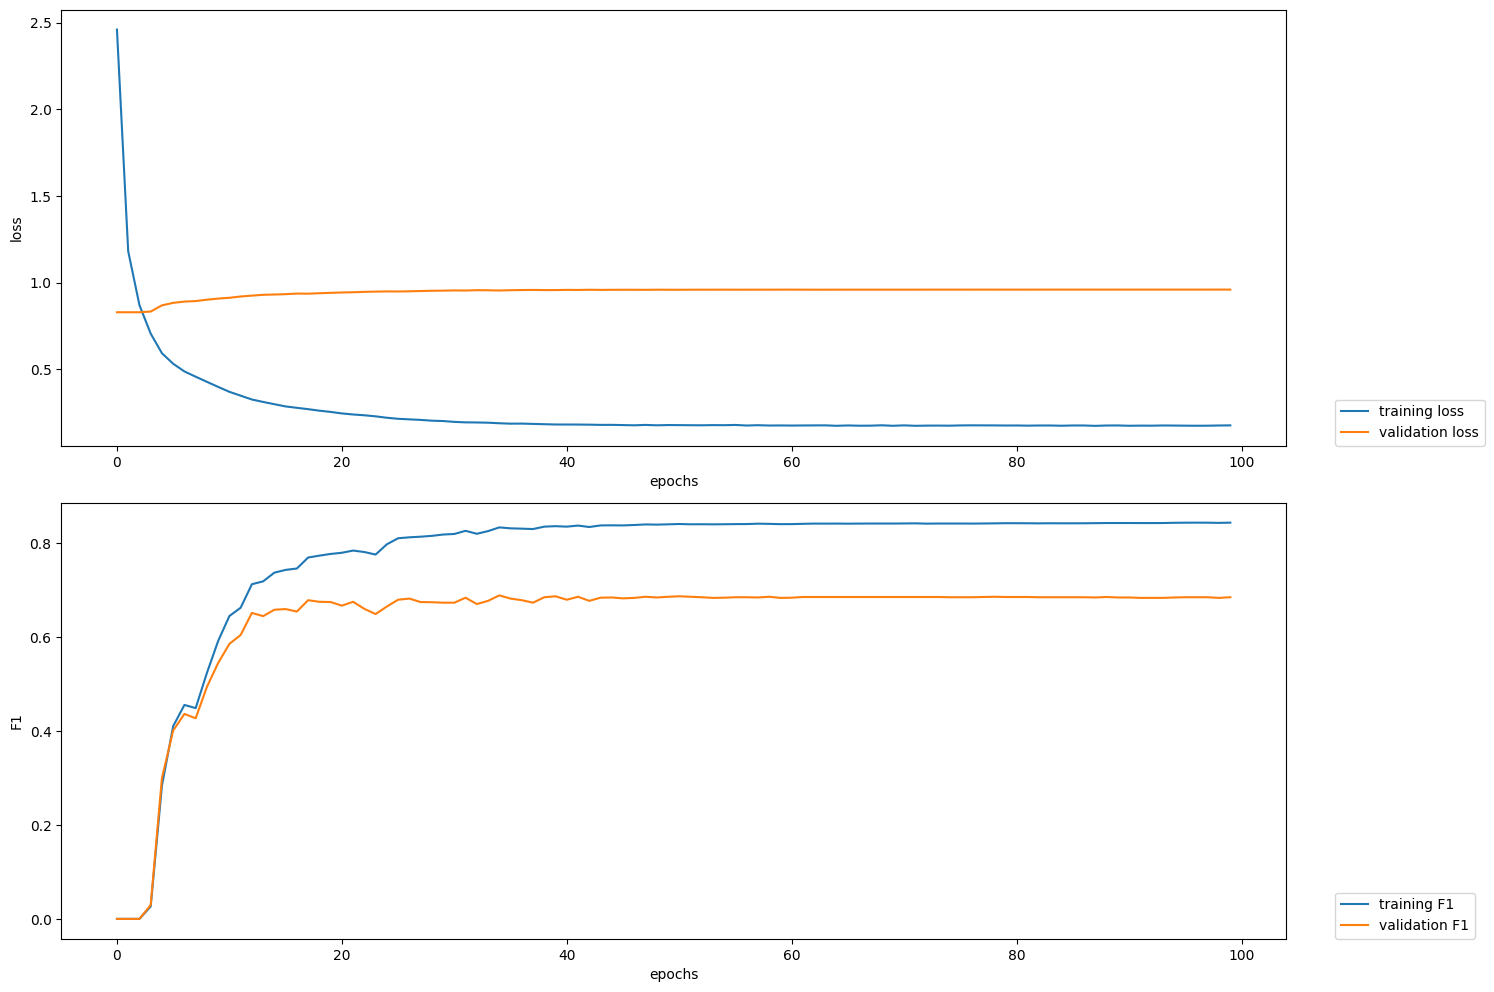

100%|██████████| 24/24 [00:10<00:00,  2.32it/s]


2023-04-21 16:46:58,351 Evaluating as a multi-label problem: True


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

2023-04-21 16:47:02,482 Evaluating as a multi-label problem: False



100%|██████████| 3/3 [00:01<00:00,  2.31it/s]

2023-04-21 16:47:03,876 Evaluating as a multi-label problem: True


,split,index,I-ADR,E-ADR,B-ADR,S-ADR,S-Drug,B-Finding,E-Finding,I-Finding,...,B-Symptom,B-Drug,S-Finding,I-Symptom,I-Drug,I-Disease,micro avg,macro avg,weighted avg,samples avg
0,train,precision,0.784784,0.785132,0.792851,0.556608,0.821452,0.111111,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.759985,0.192597,0.682909,0.129503
1,train,recall,0.839290,0.906731,0.874291,0.862069,0.976672,0.005000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.780626,0.223203,0.780626,0.129466
2,train,f1-score,0.811122,0.841562,0.831582,0.676454,0.892362,0.009569,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.770167,0.203133,0.726095,0.129478
3,train,support,4449.000000,3506.000000,3349.000000,1363.000000,1286.000000,200.000000,200.0,149.0,...,110.0,110.0,109.0,104.0,50.0,50.0,15722.000000,15722.000000,15722.000000,15722.000000
4,dev,precision,0.580762,0.692898,0.718941,0.497093,0.778325,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.645972,0.163401,0.561798,NaN
5,dev,recall,0.618956,0.804009,0.798643,0.818182,0.963415,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.659729,0.200160,0.659729,NaN
6,dev,f1-score,0.599251,0.744330,0.756699,0.618445,0.861035,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.652778,0.178988,0.604522,NaN
7,dev,support,517.000000,449.000000,442.000000,209.000000,164.000000,39.000000,34.0,20.0,...,12.0,20.0,25.0,23.0,7.0,13.0,2066.000000,2066.000000,2066.000000,NaN
8,test,precision,0.645472,0.726000,0.736957,0.707182,0.767347,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.710236,0.179148,0.616832,0.114332
9,test,recall,0.638095,0.821267,0.811005,0.810127,0.979167,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.680241,0.202983,0.680241,0.114247


In [23]:
print(suf)

os.mkdir('flair_ner_model'+suf+'/classification_report')
plotter.plot_training_curves('flair_ner_model'+suf+'/loss.tsv')

# evaluate the tagger on the test set
result = tagger.evaluate(corpus.train, 
                         embeddings_storage_mode='gpu',
                         mini_batch_size=40,
                         main_evaluation_metric = ("weighted avg", "f1-score"),
                         gold_label_type='ner',
                         gold_label_dictionary=tag_dictionary)
open('flair_ner_model'+suf+'/classification_report/train.txt', 'w').write(str(result))
res1 = pd.DataFrame.from_dict(result.classification_report).reset_index()
res1.insert(loc=0, column='split', value='train')

result = tagger.evaluate(corpus.dev, 
                         embeddings_storage_mode='gpu',
                         mini_batch_size=40,
                         main_evaluation_metric = ("weighted avg", "f1-score"),
                         gold_label_type='ner',
                         gold_label_dictionary=tag_dictionary)
open('flair_ner_model'+suf+'/classification_report/dev.txt', 'w').write(str(result))
res2 = pd.DataFrame.from_dict(result.classification_report).reset_index()
res2.insert(loc=0, column='split', value='dev')

result = tagger.evaluate(corpus.test, 
                         embeddings_storage_mode='gpu',
                         mini_batch_size=40,
                         main_evaluation_metric = ("weighted avg", "f1-score"),
                         gold_label_type='ner',
                         gold_label_dictionary=tag_dictionary)
open('flair_ner_model'+suf+'/classification_report/test.txt', 'w').write(str(result))
res3 = pd.DataFrame.from_dict(result.classification_report).reset_index()
res3.insert(loc=0, column='split', value='test')

res = pd.concat([res1,res2,res3],ignore_index=True)
res.to_csv('flair_ner_model'+suf+'/classification_report.csv',index=False)
res

In [ ]:
# import time
# start_time = time.time()
# while time.time() - start_time < 1:
#     time.sleep(1)
# print('Session has timed out (2 minutes). Disconnecting...')
# !kill -9 -1

Layering can be a good idea if the NER tags in the first layer have their own set of dependent values in the second layer. This can help capture more information about the entities being recognized and provide more context for downstream tasks. However, it also increases the complexity of the annotation and the training process, so it should be used judiciously. In general, it's a good idea to start with a simple tag scheme and gradually increase complexity as needed.

    does it really matter if u use the E header

It depends on the specific task and the requirements of the downstream model. In some cases, using the E tag can help disambiguate between overlapping entities, while in other cases it may not be necessary or even desired. Ultimately, it's up to the developer to determine the appropriate tagging scheme for their specific use case.

    would adding POS as an extra NER layer help model performance or not

Adding POS as an extra NER layer may or may not help model performance, depending on the specific use case and data being analyzed.

On one hand, incorporating POS tags could provide additional context to the model and help it better distinguish between named entities and other parts of speech. For example, knowing that a word is a noun or verb could help the model determine if it is likely to be a named entity or not.

On the other hand, adding an additional layer could also increase model complexity and training time without necessarily improving performance. It may also require additional manual annotation efforts to create a labeled dataset with both NER and POS tags.

Ultimately, whether to include POS as an additional layer will depend on the specific requirements and goals of the project, as well as the available data and resources.

    besides bioes ordering (which is up-to-down), it doesn't matter what order the tags in the same domain appear in left-to-right?

Yes, that is correct. As long as the BIOES order is maintained vertically, the order of tags in the same domain from left-to-right should not impact training in flai

    different typenames must be treated as separate tasks?

Yes, that's correct. Different typenames should be treated as separate tasks because they represent different types of annotations that you want to predict. For example, in a biomedical NER task, you might want to predict the entity types of both drugs and diseases, which would be represented by two different typenames in your annotation data. Predicting both types of entities would require different models and possibly different evaluation metrics.